In [17]:
import numpy as np
import os,sys
import math
from sklearn.cluster import KMeans
from scipy import spatial
import scipy.stats as sp
import uproot


#--------------------------------------------------------------------------------------------------------------------------------------------

def getData(fname="", procName="Events"):
    file = uproot.open(fname)
    dq_dict = file[procName].arrays(library="np")
    dq_events = {
        "Hits":{
            "detID": dq_dict["hit_detID"],
            "edep": dq_dict["hit_edep"],
            "elmID": dq_dict["hit_elmID"],
            "hit_pos": dq_dict["hit_pos"]
        },
        "track":{
            "x": dq_dict["track_x_CAL"],
            "y": dq_dict["track_y_CAL"],
            "ID": dq_dict["eventID"],
            "pz": dq_dict["track_pz_st1"]
        },
        "st23": {
            "ntrack23": dq_dict["n_st23tracklets"],
            "px":   dq_dict["st23tracklet_px_st3"],
            "py":   dq_dict["st23tracklet_py_st3"],
            "pz":   dq_dict["st23tracklet_pz_st3"],
            "x":   dq_dict["st23tracklet_x_st3"],
            "y":   dq_dict["st23tracklet_y_st3"],
            "z":   dq_dict["st23tracklet_z_st3"],
            "Cal_x": dq_dict["st23tracklet_x_CAL"],
            "Cal_y": dq_dict["st23tracklet_y_CAL"]
        }
    }

    return dq_events
#--------------------------------------------------------------------------------------------------------------------------------------------

ntowersx=72
ntowersy=36
sizex=5.53 # in cm
sizey=5.53 # in cm
ecalx=[-200,200] #size in cm
ecaly=[-100,100]
binsx=ecalx[1]- ecalx[0]
binsy=ecaly[1]- ecaly[0]
sfc = 0.1146337964120158 #sampling fraction of emcal
emin=0.0005
det_z={41: 2130.27, 42: 2146.45, 43:2200.44 , 44:2216.62 , 45:2251.71 , 46: 2234.29}


#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_bytuple(dq_events):
    dq_hits = dq_events["Hits"]
    x_pos = []
    y_pos = []
    eve_energy = []
    for i in range(len(dq_events["Hits"]["edep"])):
        output = emcal_byevent(dq_hits, i)
        if len(output[0]) != 0:
            x_pos.append(output[0])
            y_pos.append(output[1])
            eve_energy.append(output[2])
        else:
            x_pos.append(np.array([]))
            y_pos.append(np.array([]))
            eve_energy.append(np.array([]))
            
    return x_pos, y_pos, eve_energy

#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_byevent(dq_hits, evtNum):
    raw_elmID = dq_hits["elmID"][evtNum]
    raw_edep = dq_hits["edep"][evtNum]
    
    emcal_mask = dq_hits["detID"][evtNum] == 100
    eng_mask = raw_edep[emcal_mask] >= emin
    
    elmID = raw_elmID[emcal_mask][eng_mask]#could also use dstack here to zip (elmID and edep)
    edep = raw_edep[emcal_mask][eng_mask]
    
    emcal_towerx = elmID // ntowersy
    emcal_towery = elmID % ntowersy
    emcal_x = ecalx[0] + emcal_towerx * sizex
    emcal_y = ecaly[0] + emcal_towery * sizey
    emcal_edep = edep / sfc
    
    return emcal_x, emcal_y, emcal_edep

#--------------------------------------------------------------------------------------------------------------------------------------------

def find_energy_seeds(x, y, energy, min_energy=1, seed_radius=50):
    high_energy_mask =energy >min_energy
    high_energy_points = np.column_stack((x[high_energy_mask], y[high_energy_mask], energy[high_energy_mask]))
    seeds = []
    indices = []
    for i, (x_val, y_val, energy_val) in enumerate(high_energy_points):
        distances = np.array(np.sqrt((high_energy_points[:, 0] - x_val)**2 + (high_energy_points[:, 1] - y_val)**2))
        distances[i] = seed_radius + 1
        points_within_radius_mask = distances < seed_radius
        points_within_radius = high_energy_points[points_within_radius_mask]
        if len(points_within_radius) == 0 or energy_val > np.max(points_within_radius[:, 2], initial=0):
            seeds.append([x_val, y_val])
            indices.append(np.where(high_energy_mask)[0][i])
            
    return np.array(seeds), indices
    
#--------------------------------------------------------------------------------------------------------------------------------------------
def multi_clusters(dq_events):
    (x, y, eng)=emcal_bytuple(dq_events)
    labels=[]
    seeds=[]
    labels_decrease=[]
    seed_labels = []
    kmeans_ctr = []
    for i in range(len(eng)):
        (seed, index)=find_energy_seeds(x[i], y[i], eng[i])
        seeds.append(seed)
        points=np.column_stack((x[i],y[i]))
        try:
            kmeans = KMeans(n_clusters=len(seed), init=seed , random_state=0, n_init=1).fit(points)#since center given to grow, n_init==1
            labels.append(kmeans.labels_)
            label_decr = label_clus_eng(kmeans.labels_, eng[i])
            labels_decrease.append(label_decr)
            seed_labels.append(kmeans.labels_[index])
        except:
            labels.append([])
            labels_decrease.append([])
            seed_labels.append([])
    return x, y, eng, labels, labels_decrease, seeds, seed_labels
#--------------------------------------------------------------------------------------------------------------------------------------------

def label_clus_eng(label, eng_eve):#return sorted labels by decreasing order of energy
    unique_labels = np.unique(label)
    cluster_energy = np.zeros(len(unique_labels), dtype=np.int64)
    for i in range(len(label)):
        cluster_energy[label[i]] += eng_eve[i]
    sorted_labels = unique_labels[np.argsort(cluster_energy)[::-1]]
    return sorted_labels

#--------------------------------------------------------------------------------------------------------------------------------------------

def h4_bytuple(dq_events):
    dq_hits = dq_events["Hits"]
    

    hits = np.squeeze(np.dstack((dq_hits["detID"], dq_hits["hit_pos"])), axis=0)

    h4x = []
    h4y = []

    for index, item in enumerate(hits):
        h4x_mask = (41 <= item[0]) & (item[0] <= 44)
        h4y_mask = (45 <= item[0]) & (item[0] <= 46)
        ID_pos = np.squeeze(np.dstack((hits[index][0],hits[index][1])), axis=0)
        h4x.append(ID_pos[h4x_mask])
        h4y.append(ID_pos[h4y_mask])
    return h4x, h4y

#--------------------------------------------------------------------------------------------------------------------------------------------
def gen_wew(x_eve, y_eve, eng_eve):
    eng_tot = np.sum(eng_eve)
    x_bar = np.dot(x_eve, eng_eve) / eng_tot
    y_bar = np.dot(y_eve, eng_eve) / eng_tot

    x_sq_eve = eng_eve * (x_eve - x_bar) ** 2
    y_sq_eve = eng_eve * (y_eve - y_bar) ** 2

    try:
        wew_x = np.sqrt(np.sum(x_sq_eve) / eng_tot)
    except ZeroDivisionError:
        wew_x = -1

    try:
        wew_y = np.sqrt(np.sum(y_sq_eve) / eng_tot)
    except ZeroDivisionError:
        wew_y = -1

    return [wew_x, wew_y]
#--------------------------------------------------------------------------------------------------------------------------------------------
def gen_wid(x_eve, y_eve):
    x_bar = np.mean(x_eve)
    y_bar = np.mean(y_eve)

    x_sq_eve = (x_eve - x_bar) ** 2
    y_sq_eve = (y_eve - y_bar) ** 2

    try:
        wid_x = np.sqrt(np.mean(x_sq_eve))
    except ZeroDivisionError:
        wid_x = -1

    try:
        wid_y = np.sqrt(np.mean(y_sq_eve))
    except ZeroDivisionError:
        wid_y = -1

    return [wid_x, wid_y]
#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------------------------------------------------------------







In [5]:
#443 samplesfot both Aee and Amm
def emcal_eng(x, y, eng):
    x_bins = np.linspace(-150, 150, 50)
    y_bins = np.linspace(-150, 150, 50)
    bin_means = binned_statistic_2d(x, y, eng, statistic='mean', bins=[x_bins, y_bins])
    
    fig, ax = plt.subplots()
    im = ax.imshow(np.flip(bin_means.statistic.T, 0), extent=(-150, 150, -150, 150), aspect='auto')
    plt.colorbar(im, ax=ax, label='Energy Deposit/GeV')
    ax.set_xlabel('EMCal x Position/cm')
    ax.set_ylabel('EMCal y Position/cm')
    
    return fig


In [25]:
def each_file(fname):
    print(fname)
    dq_events = getData(fname, "Events")
    x, y, eng = emcal_bytuple(dq_events)
    os.chdir("/Users/dwong/Desktop/DQ_Dowling/plots/580_training/")
    pdf_filename =  '%s.pdf' % fname
    pdf_pages = PdfPages(pdf_filename)
    for i in range(len(x)):
        try:
            fig = emcal_eng(x[i], y[i], eng[i])
            pdf_pages.savefig(fig)
            plt.close(fig)
        except:
            fig, ax = plt.subplots()  # Create a new figure and axis
            ax.set_title("Empty plot")
            
          
    pdf_pages.close()

klong_520_p580.root


/var/folders/j2/3ctm5ghn63gblh0bftd80v7r0000gq/T/ipykernel_2185/2164422902.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/var/folders/j2/3ctm5ghn63gblh0bftd80v7r0000gq/T/ipykernel_2185/1279403049.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()  # Create a new figure and axis


pi0_520_p580.root


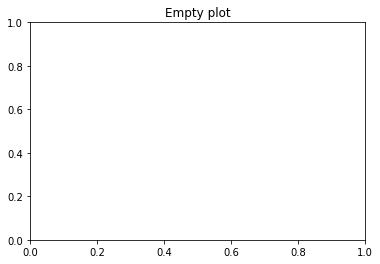

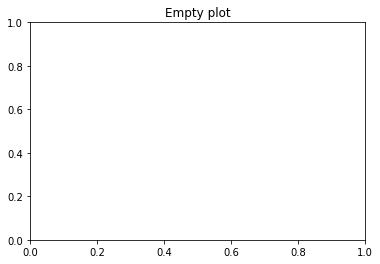

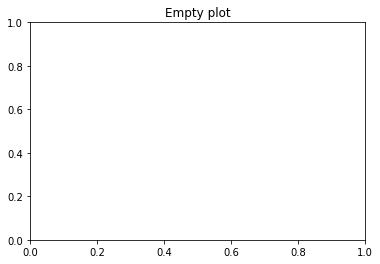

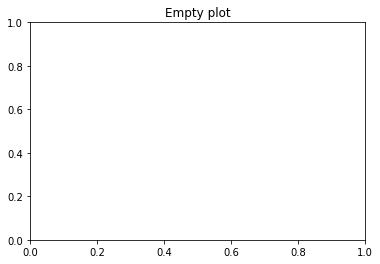

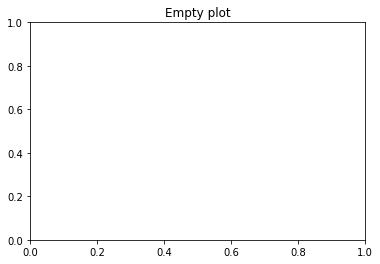

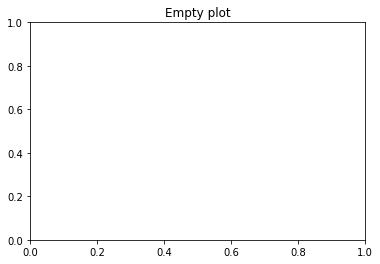

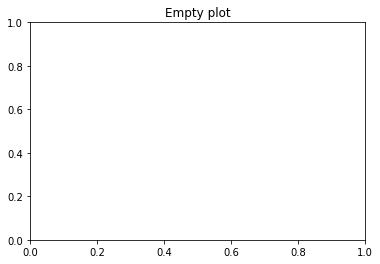

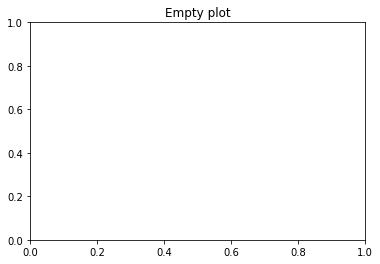

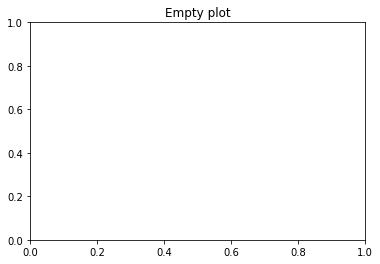

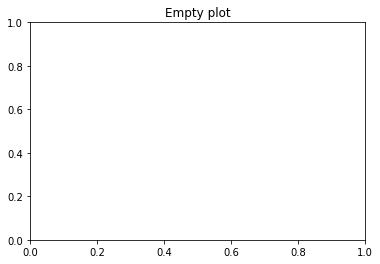

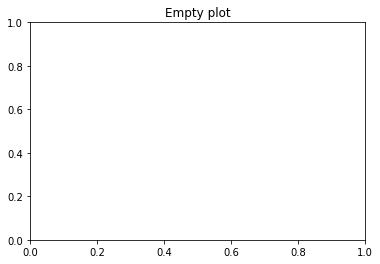

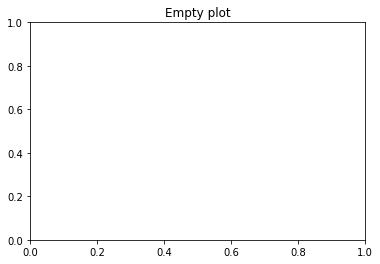

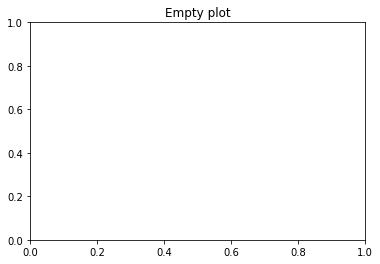

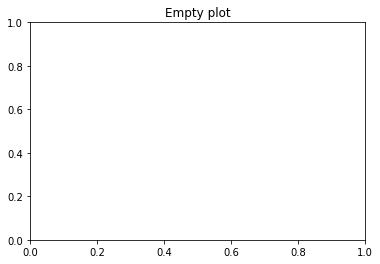

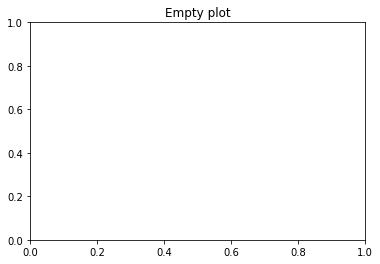

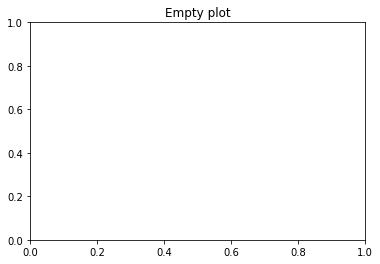

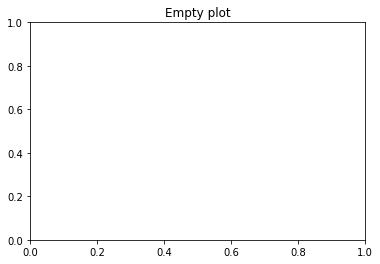

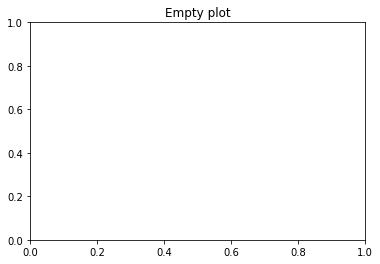

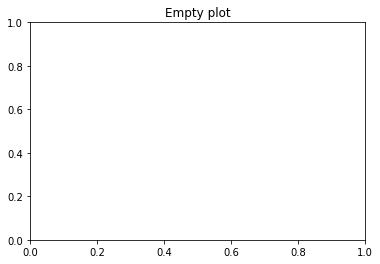

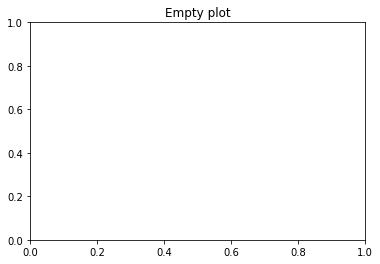

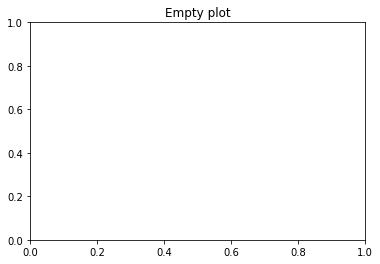

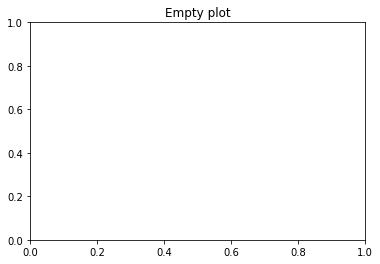

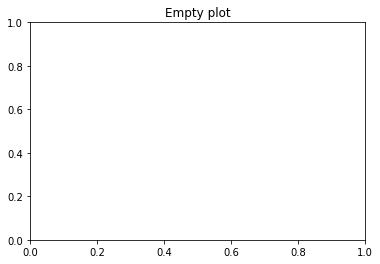

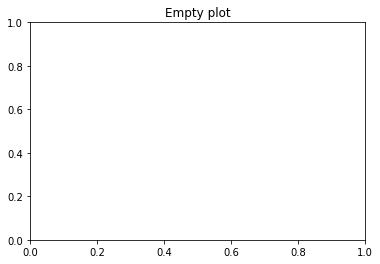

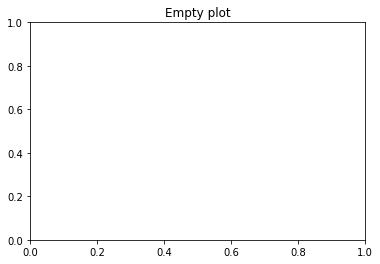

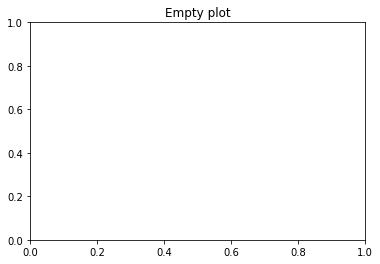

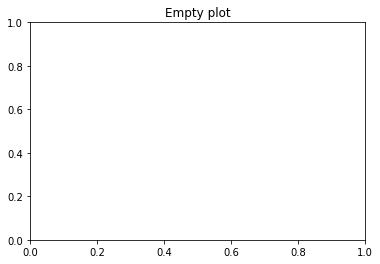

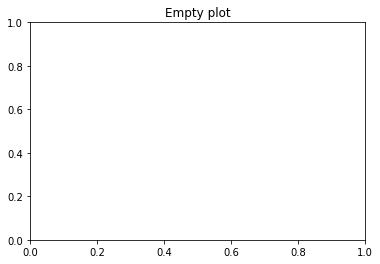

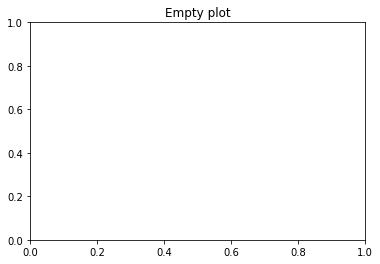

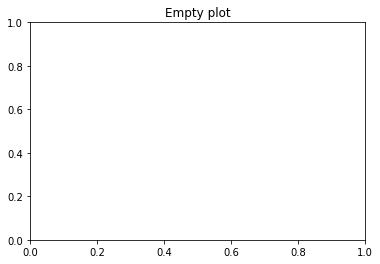

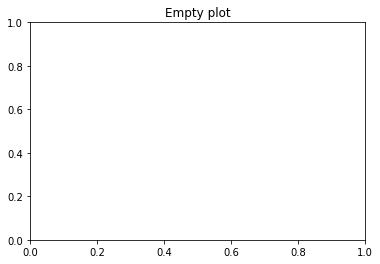

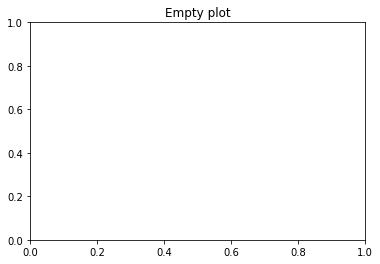

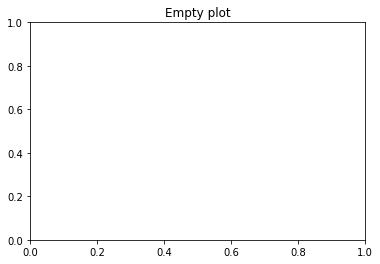

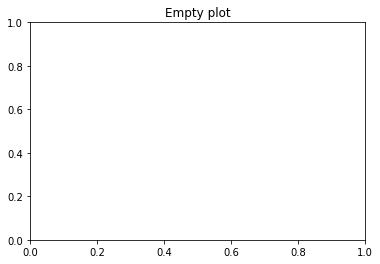

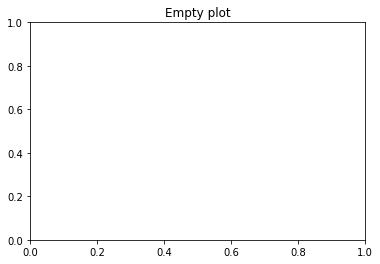

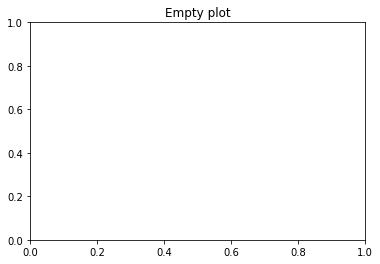

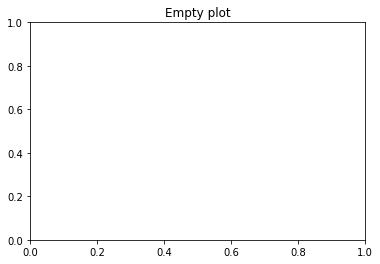

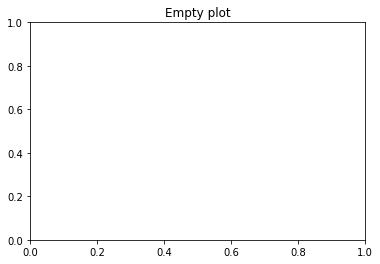

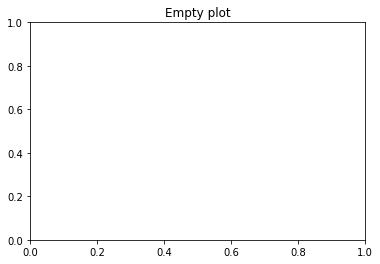

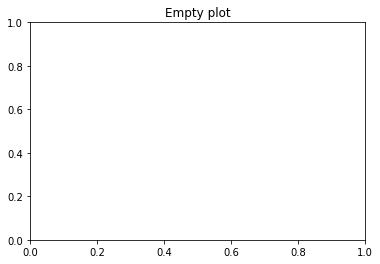

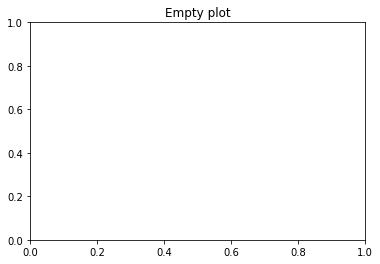

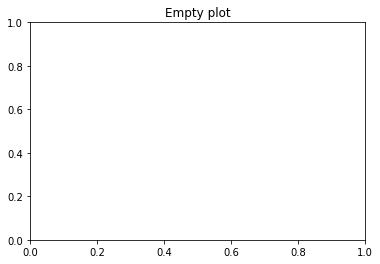

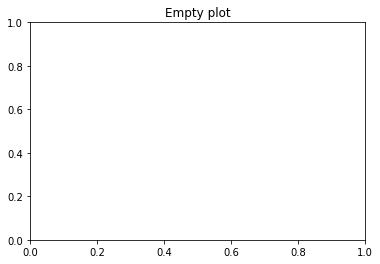

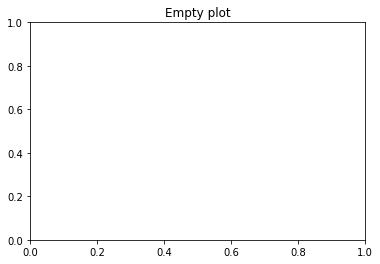

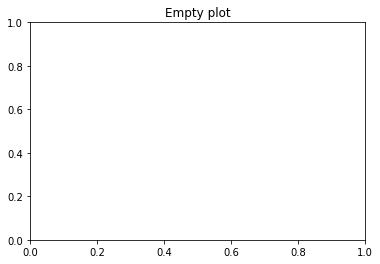

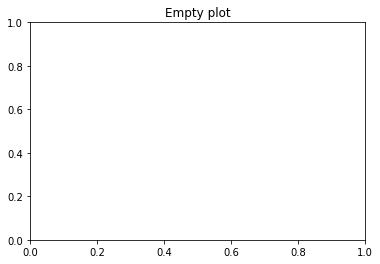

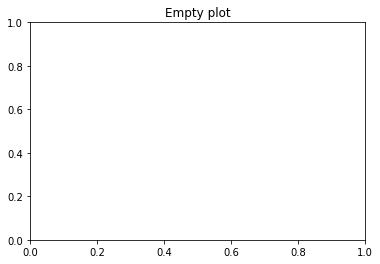

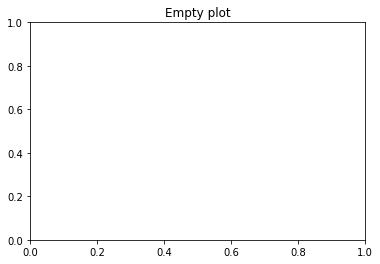

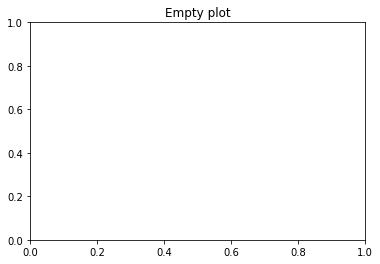

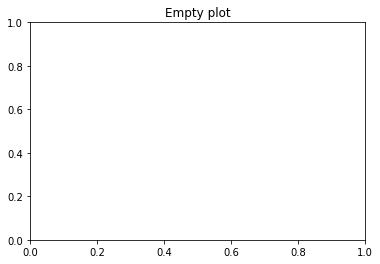

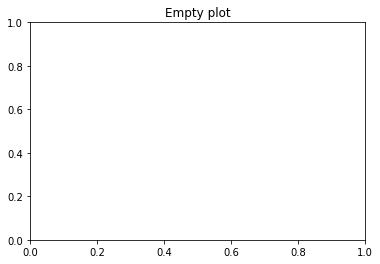

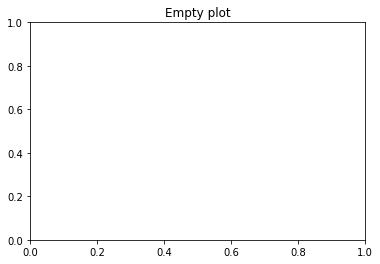

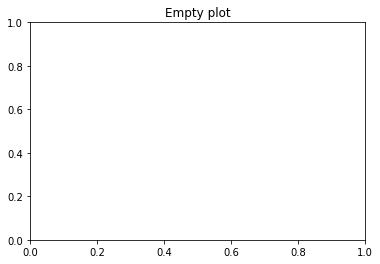

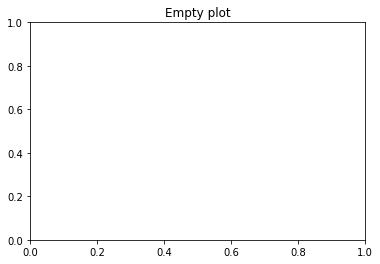

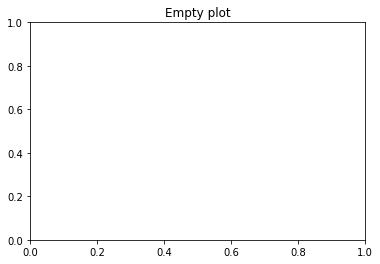

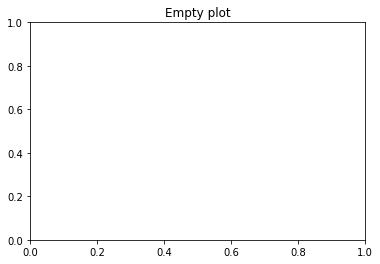

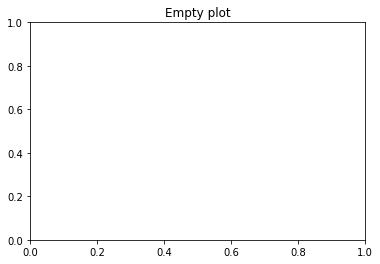

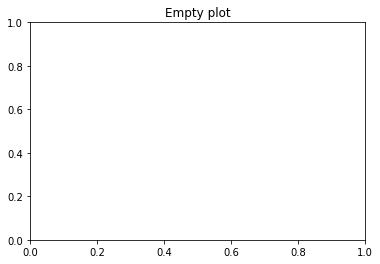

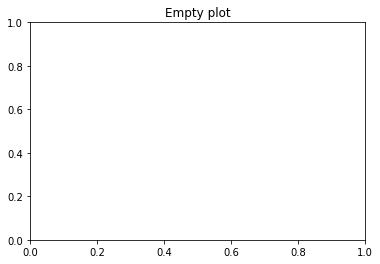

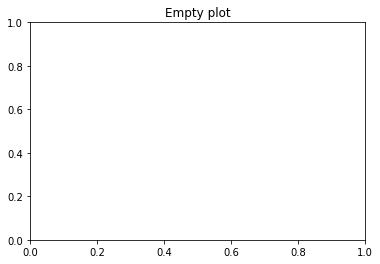

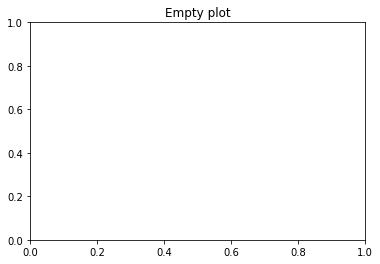

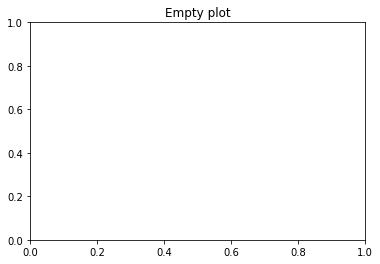

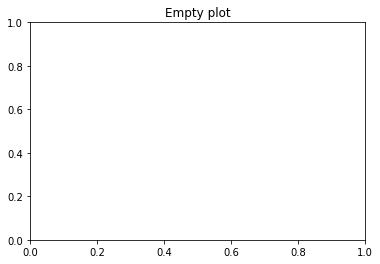

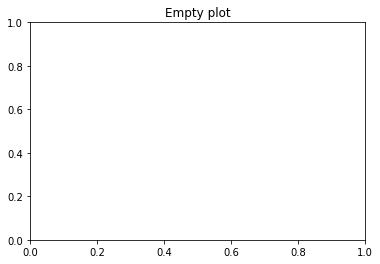

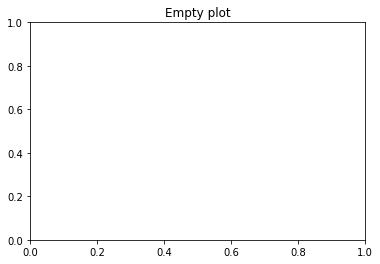

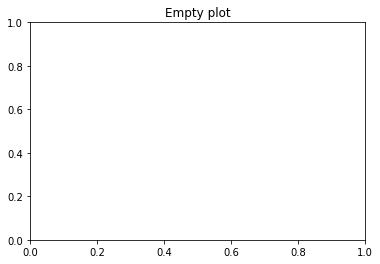

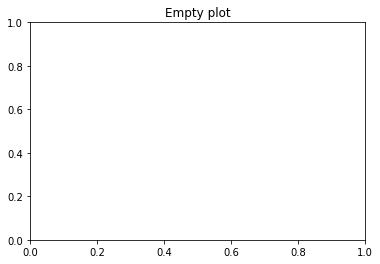

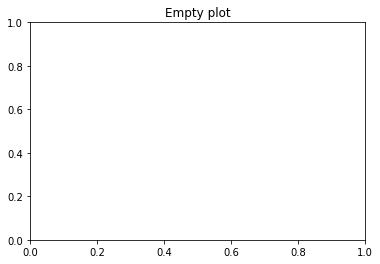

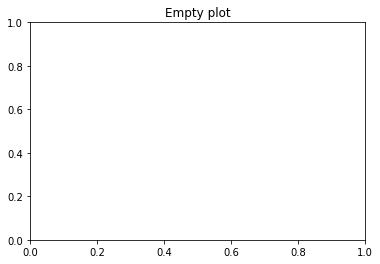

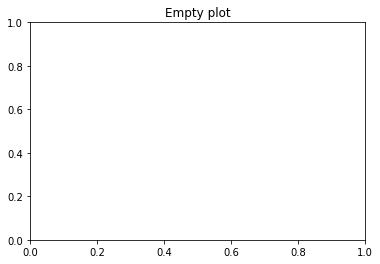

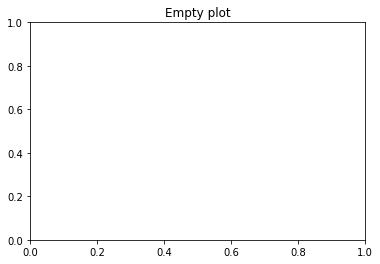

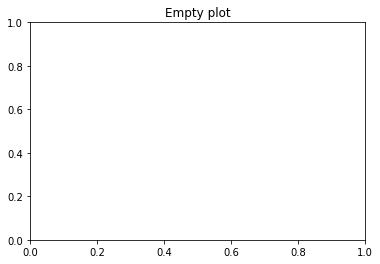

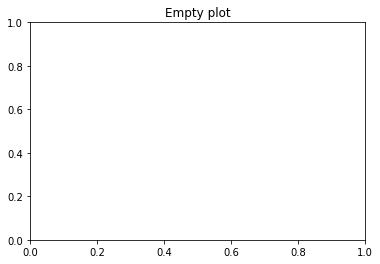

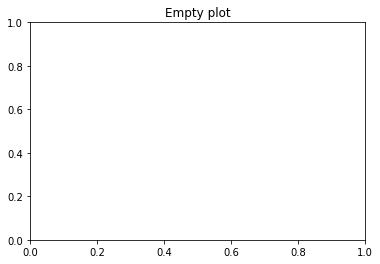

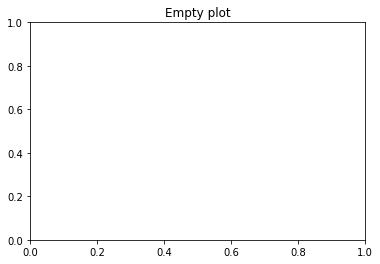

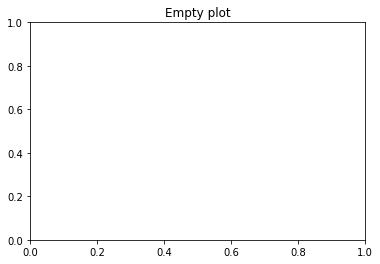

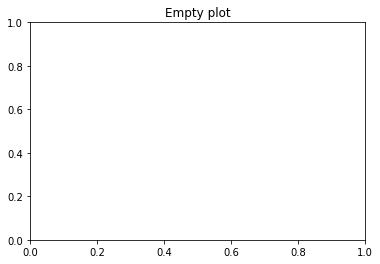

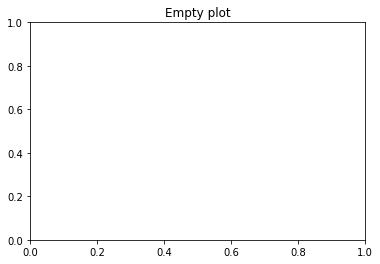

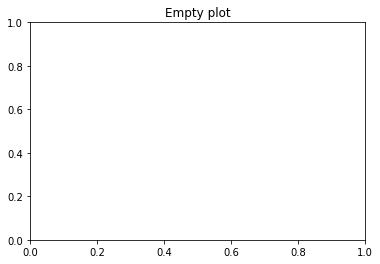

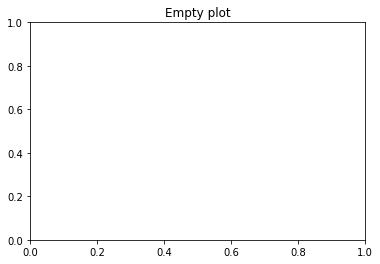

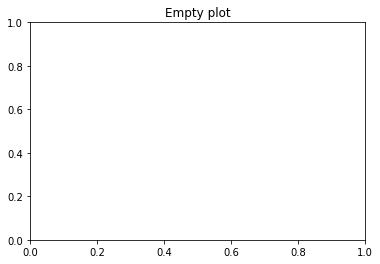

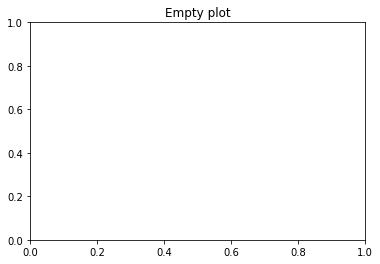

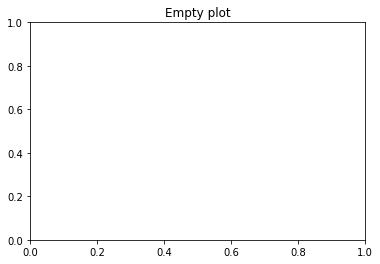

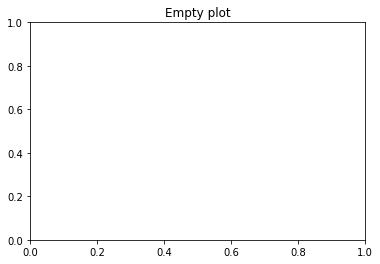

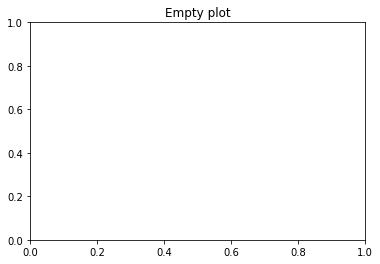

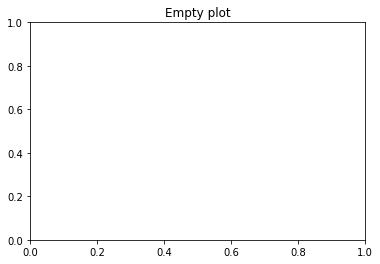

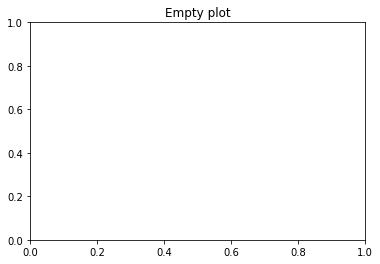

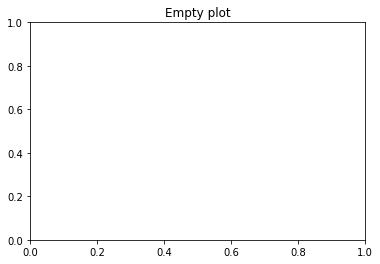

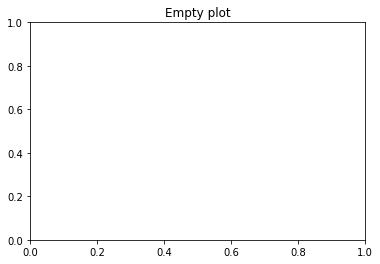

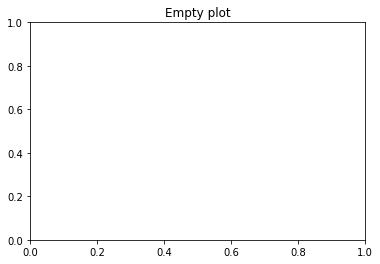

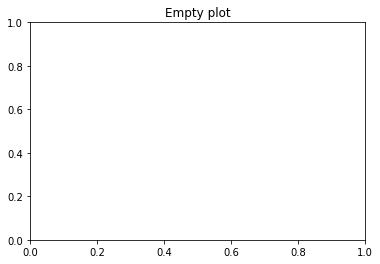

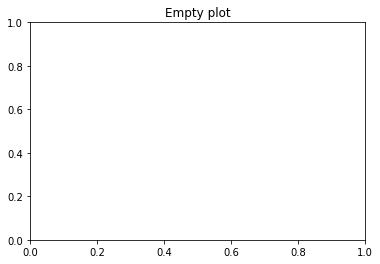

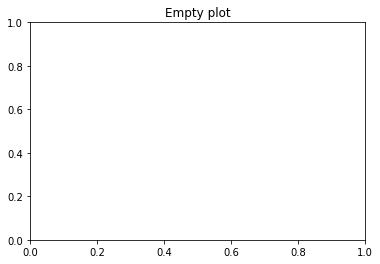

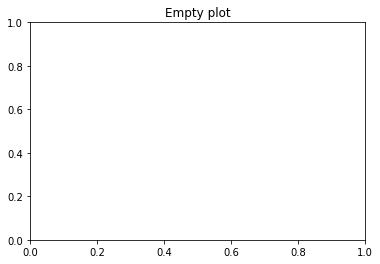

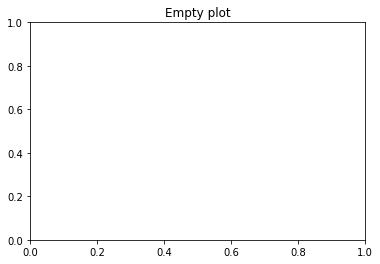

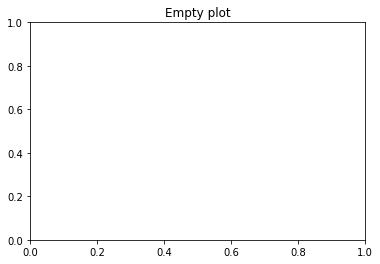

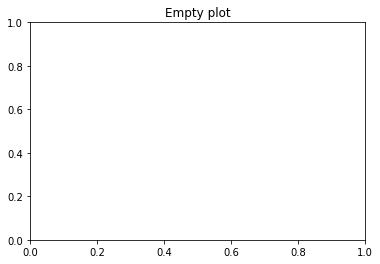

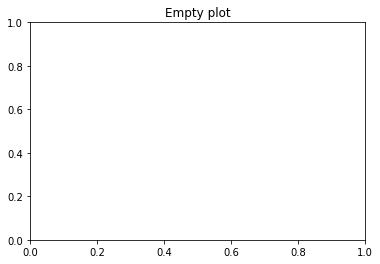

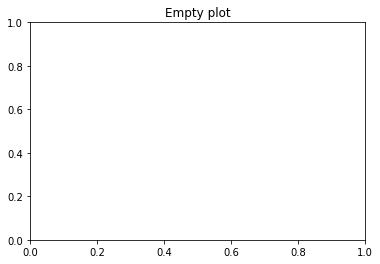

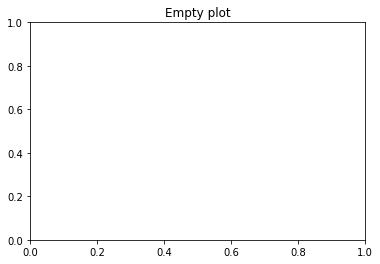

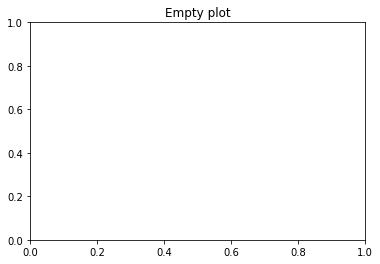

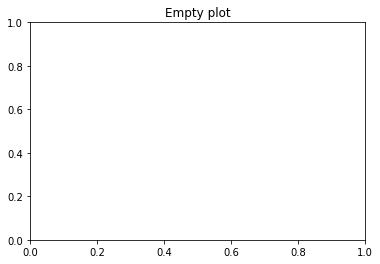

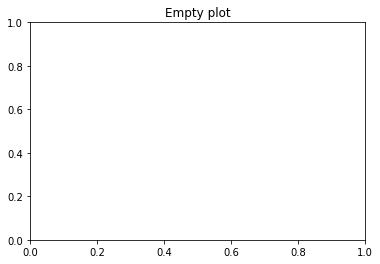

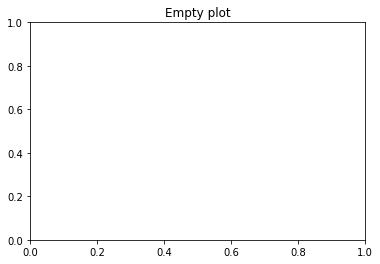

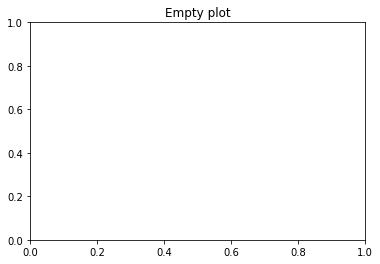

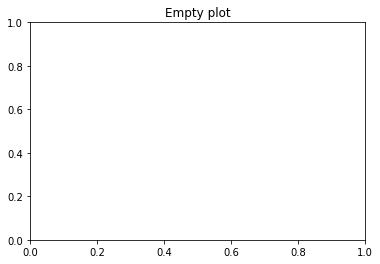

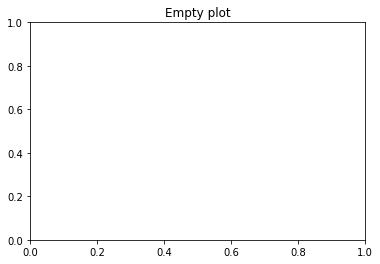

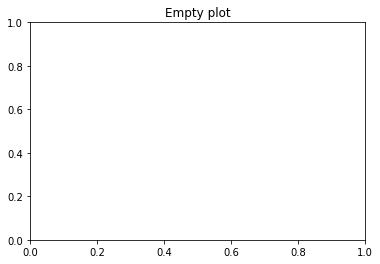

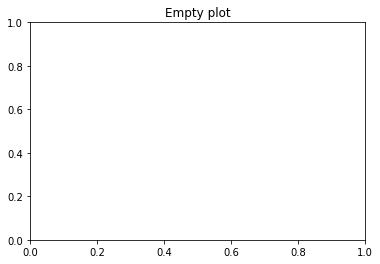

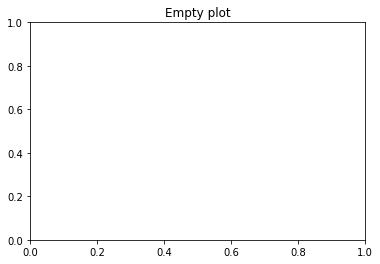

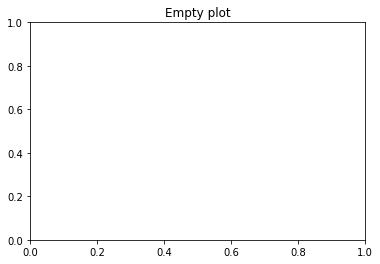

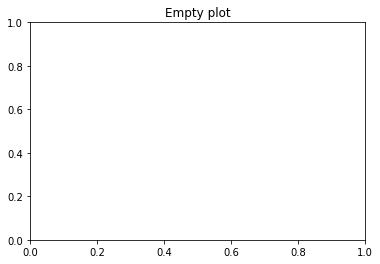

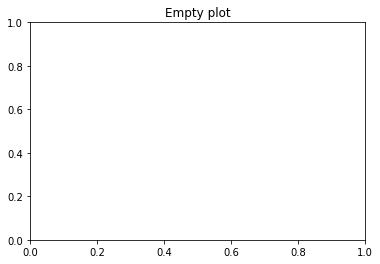

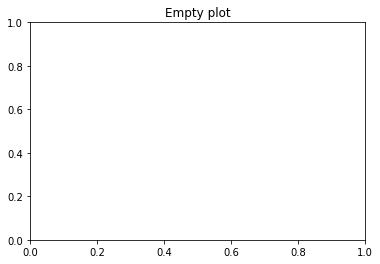

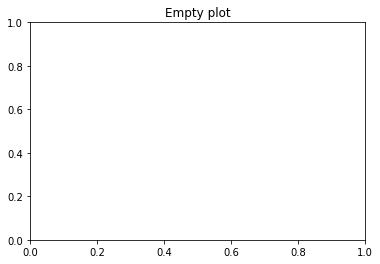

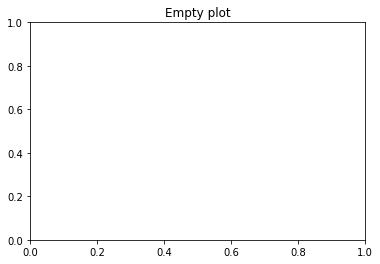

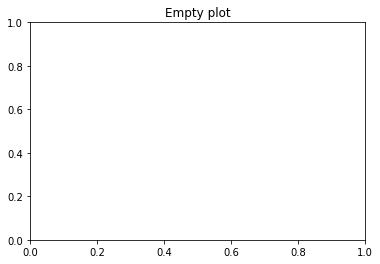

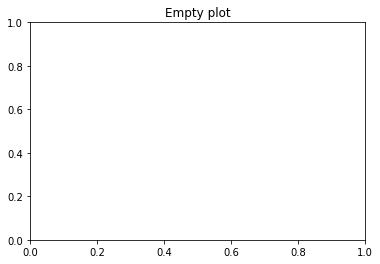

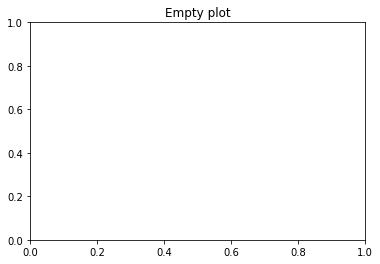

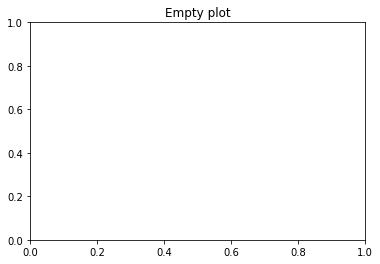

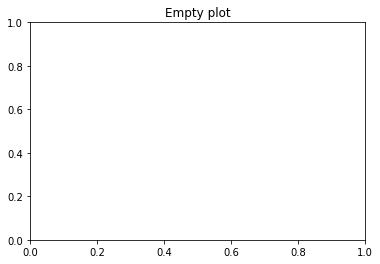

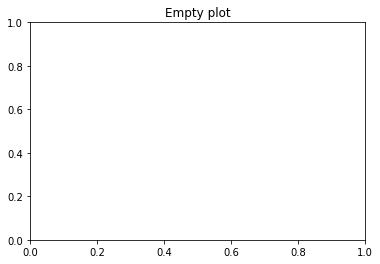

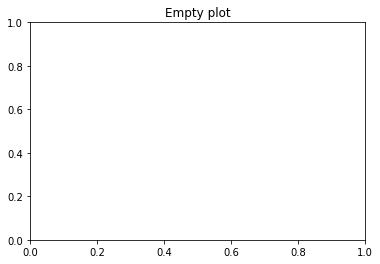

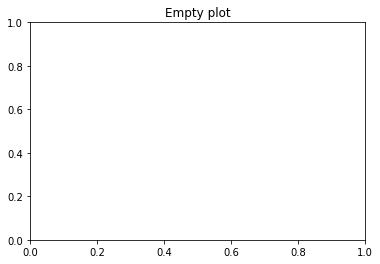

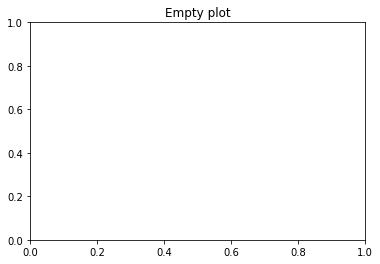

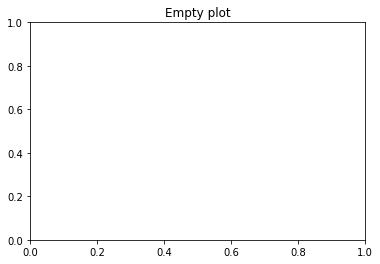

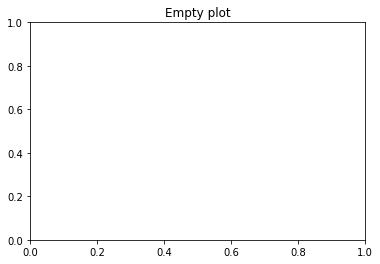

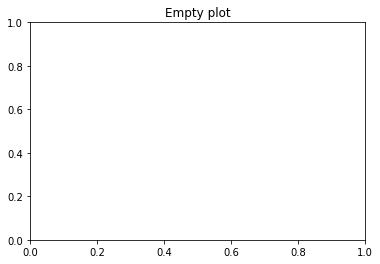

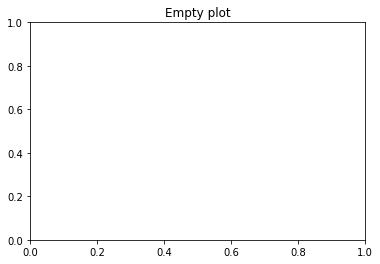

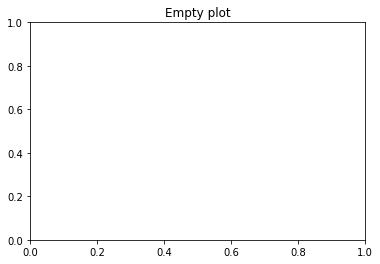

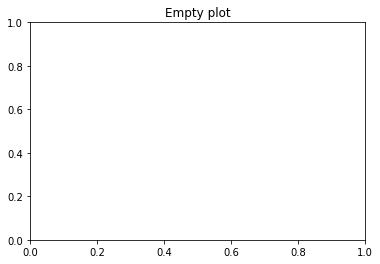

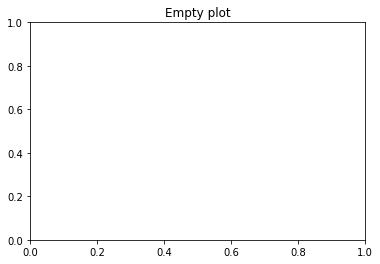

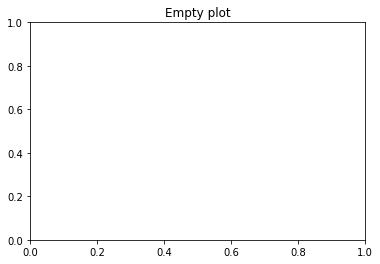

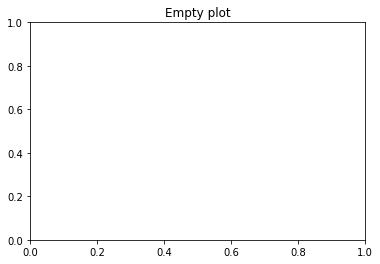

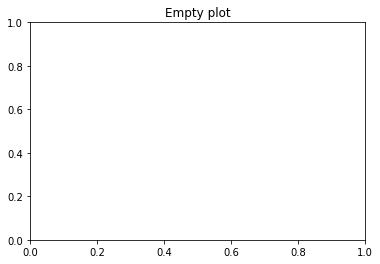

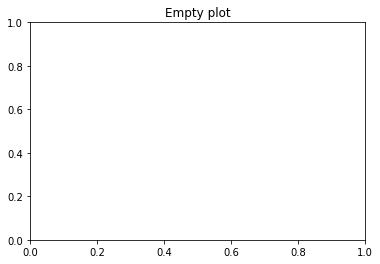

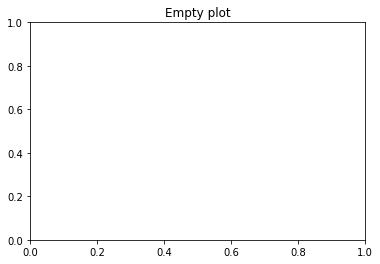

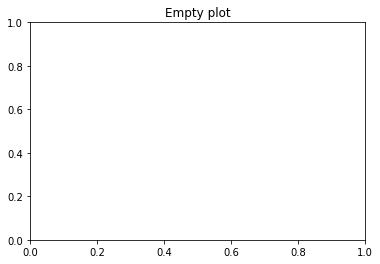

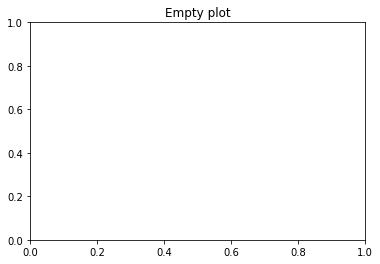

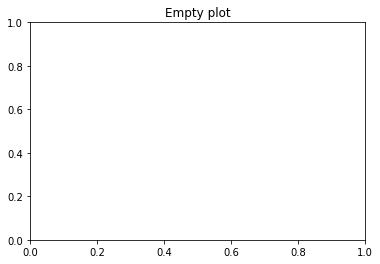

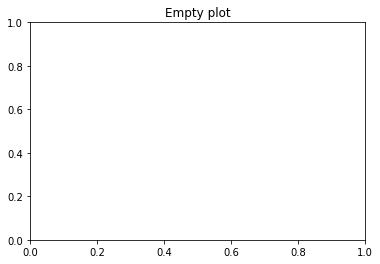

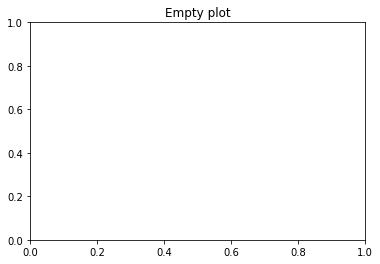

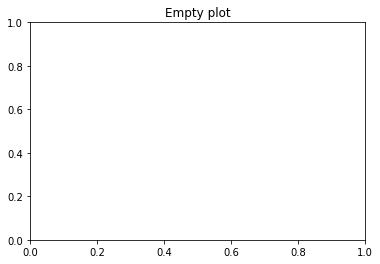

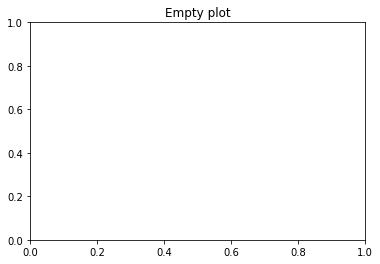

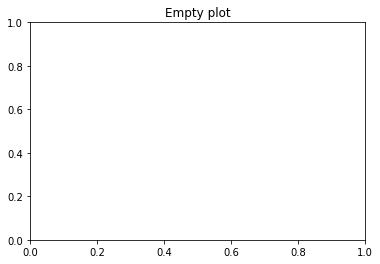

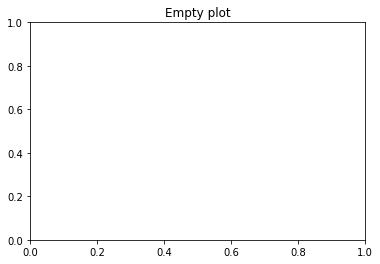

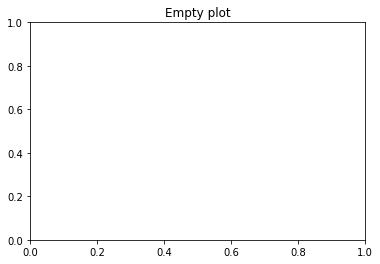

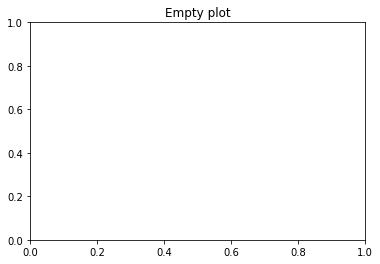

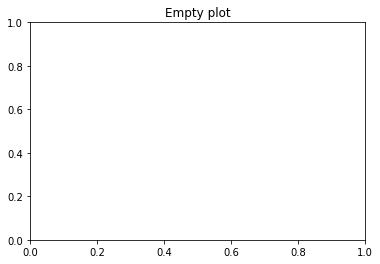

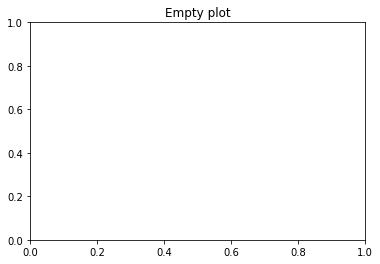

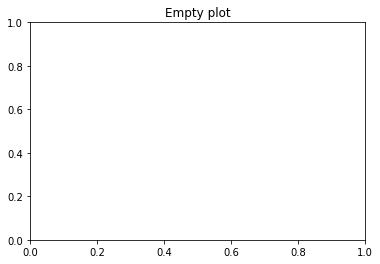

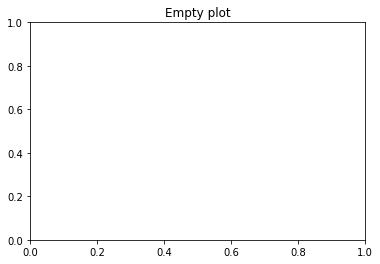

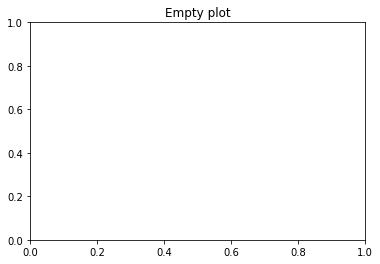

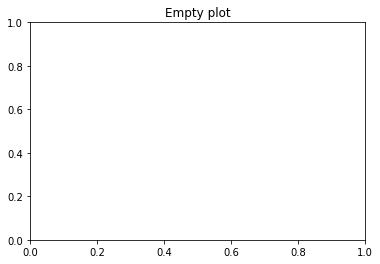

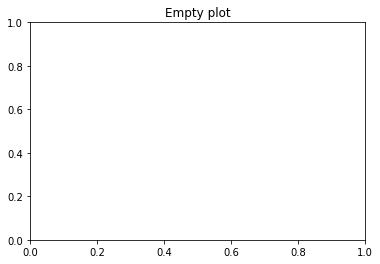

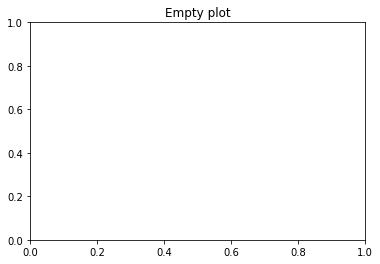

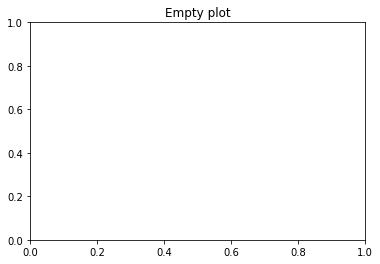

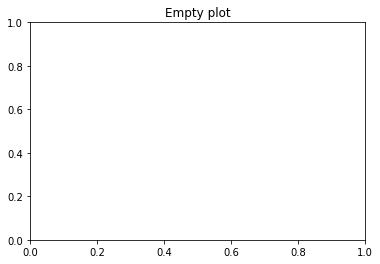

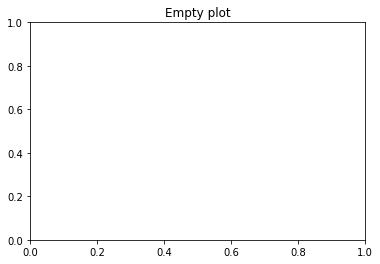

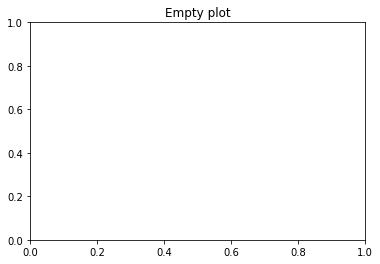

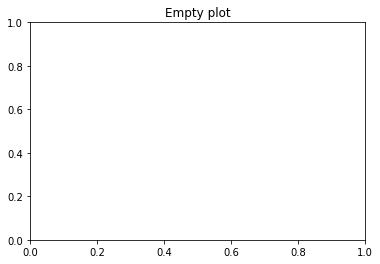

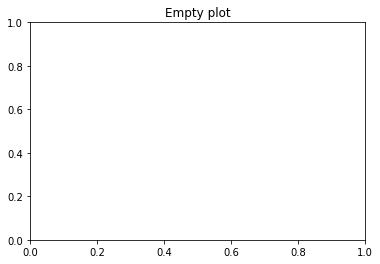

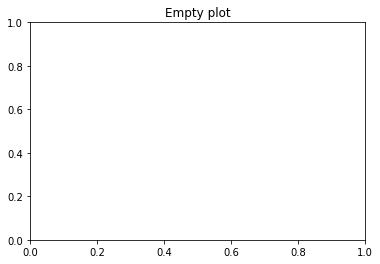

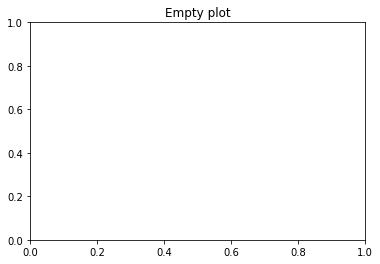

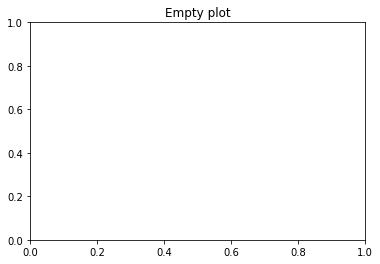

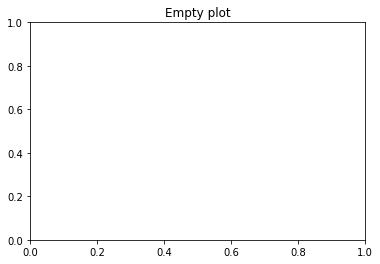

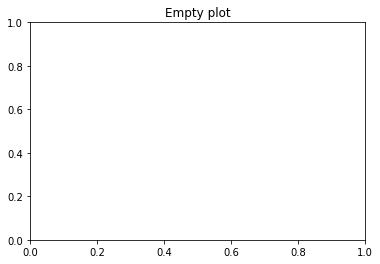

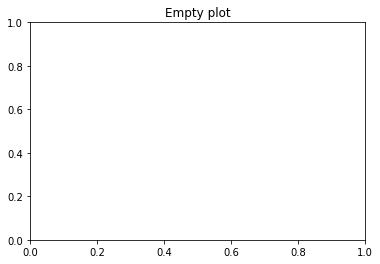

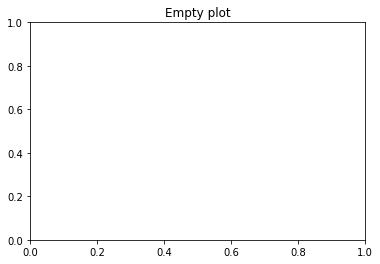

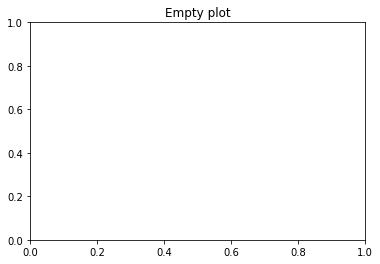

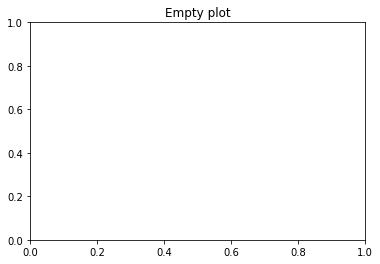

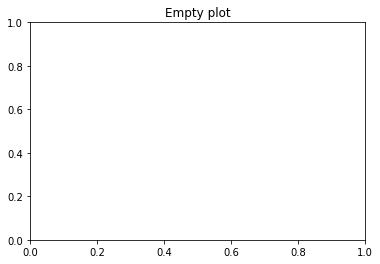

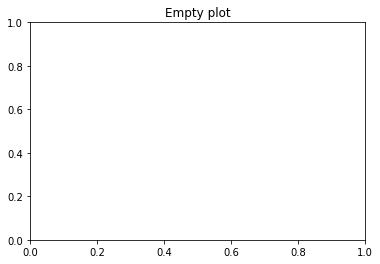

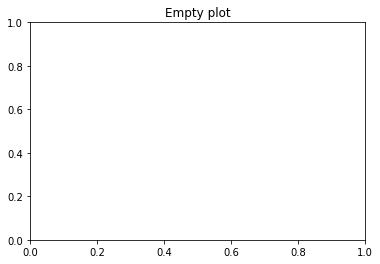

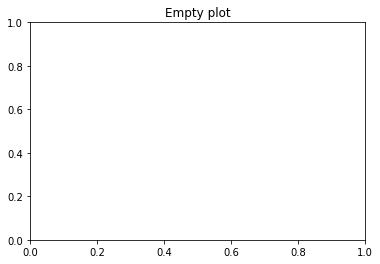

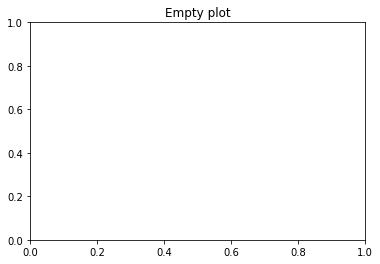

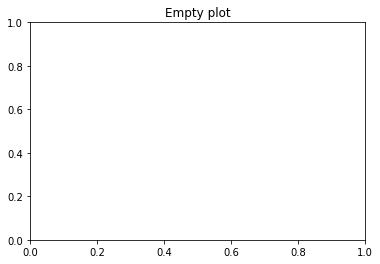

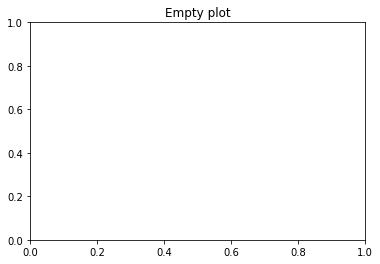

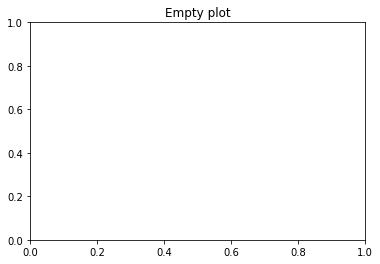

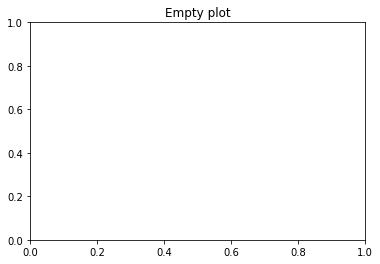

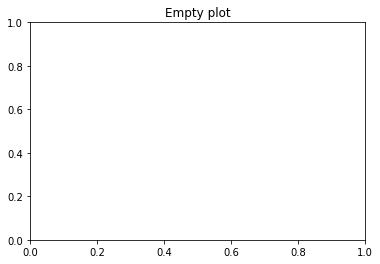

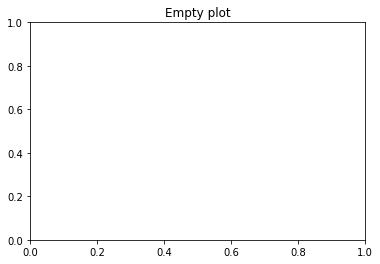

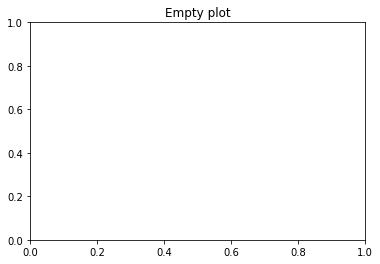

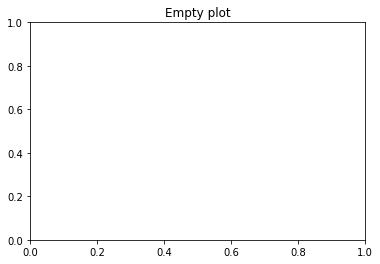

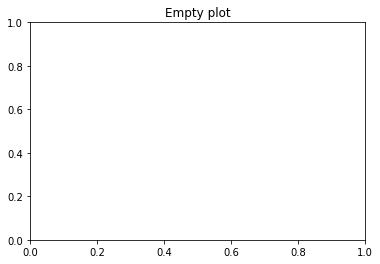

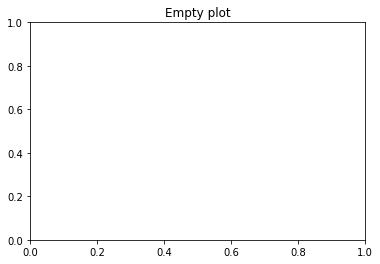

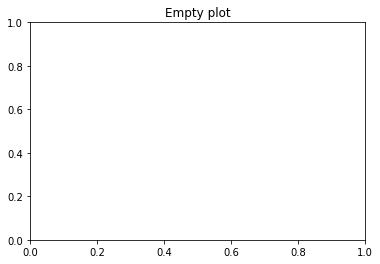

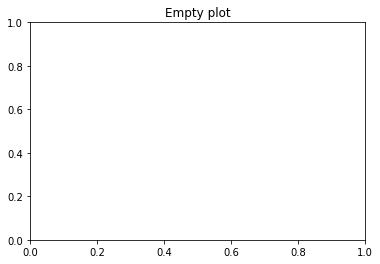

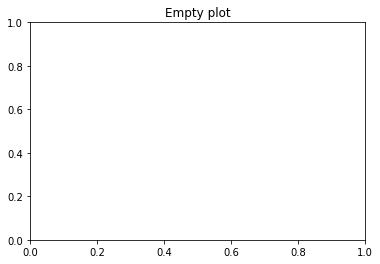

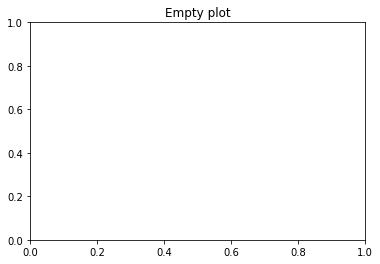

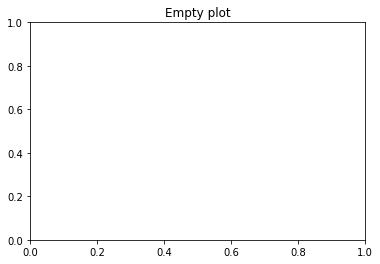

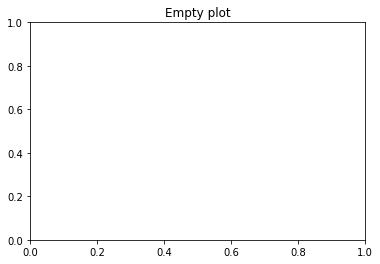

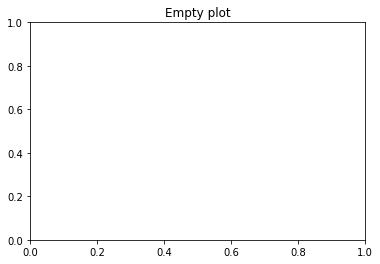

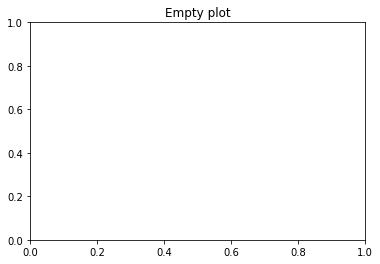

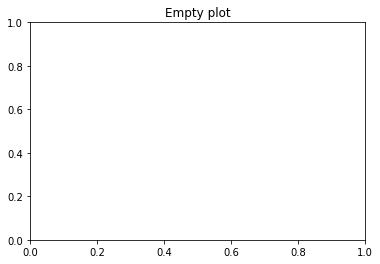

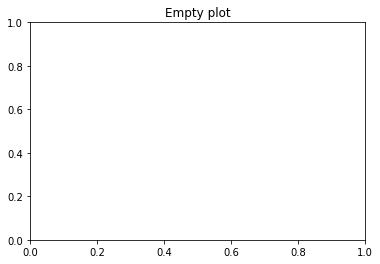

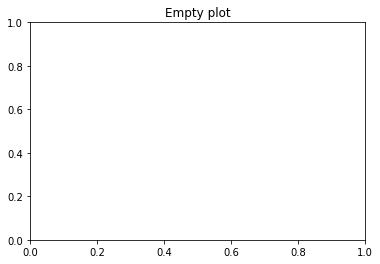

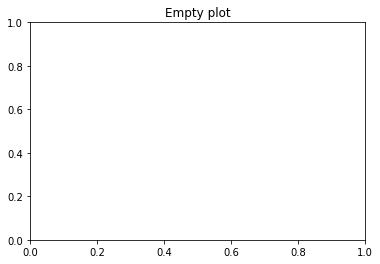

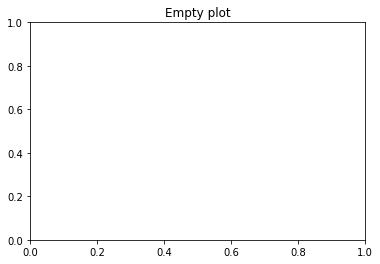

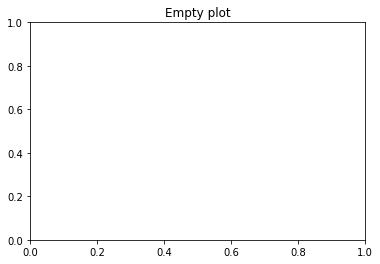

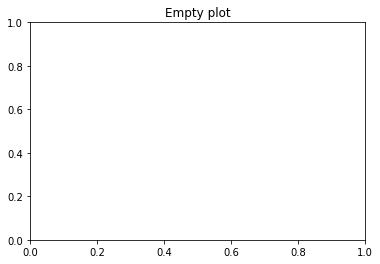

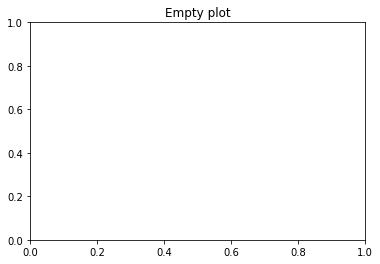

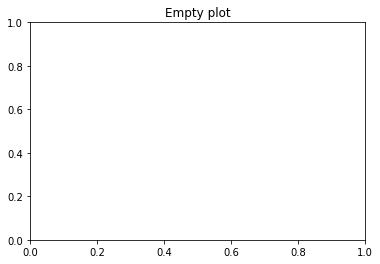

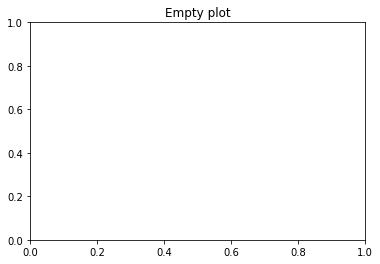

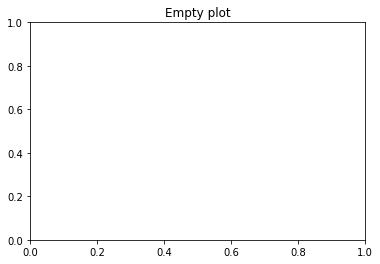

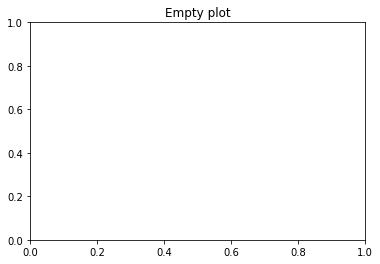

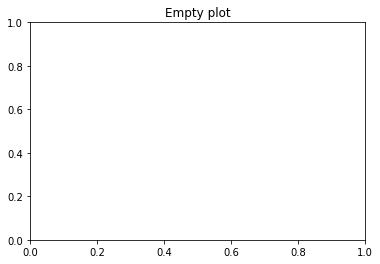

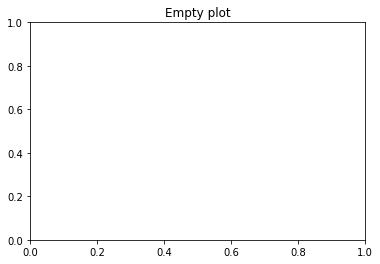

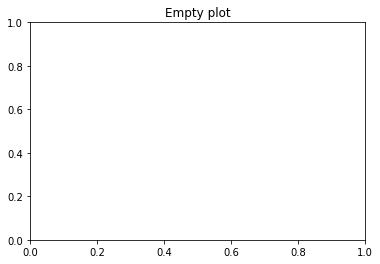

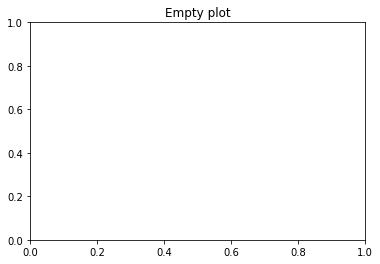

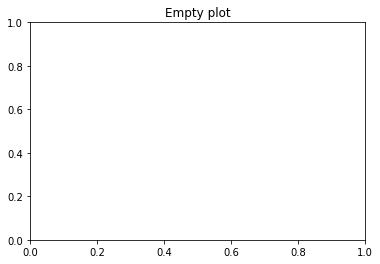

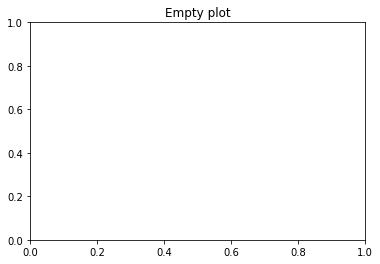

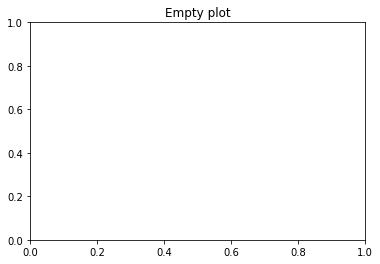

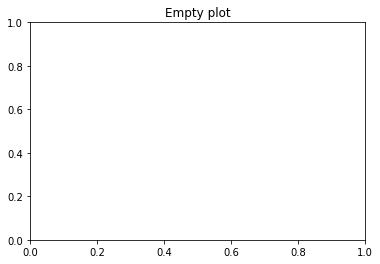

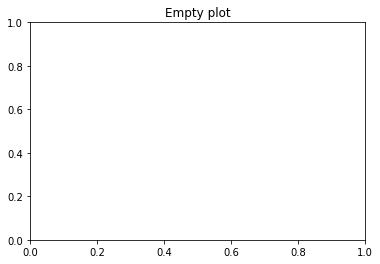

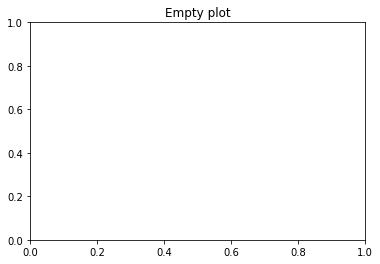

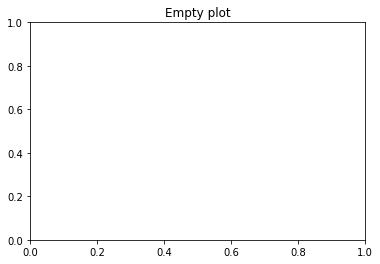

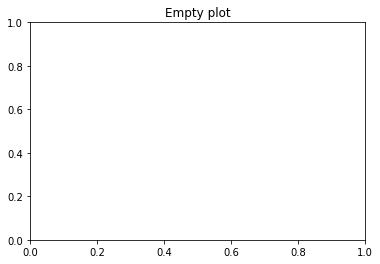

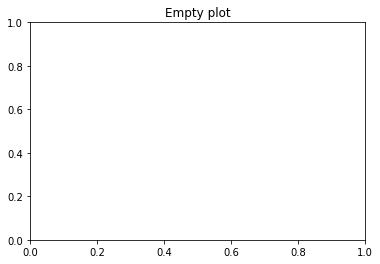

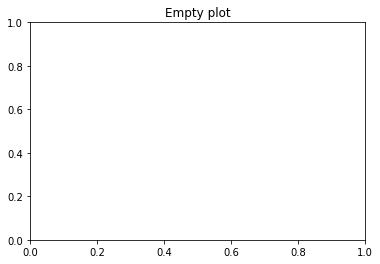

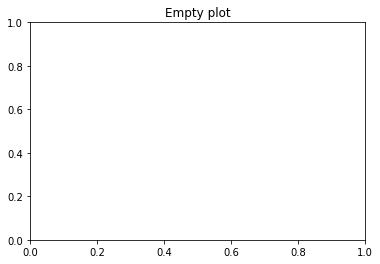

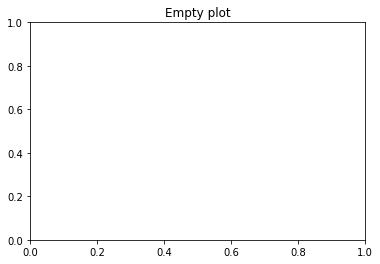

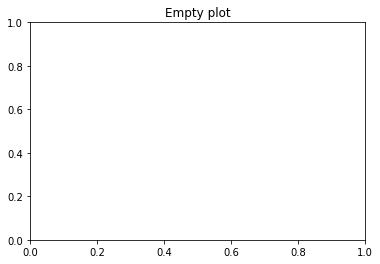

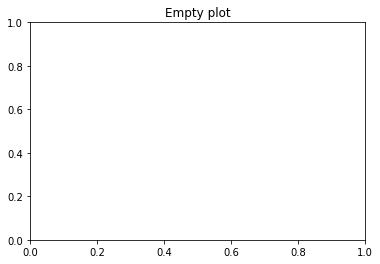

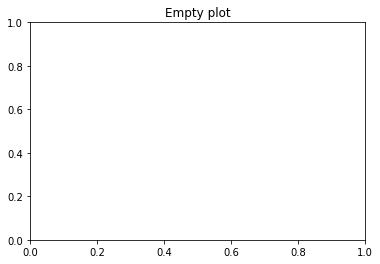

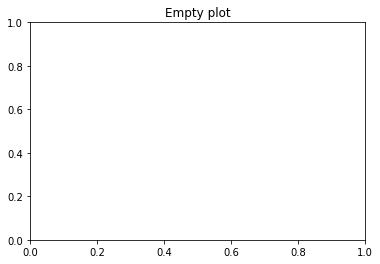

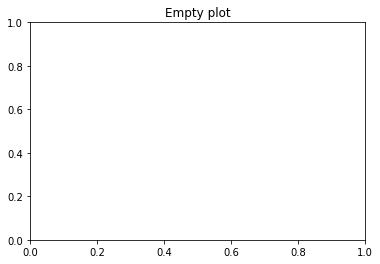

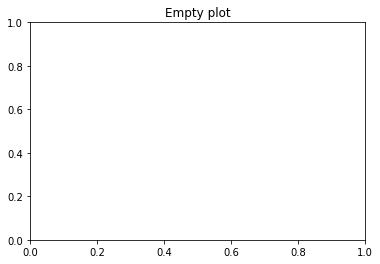

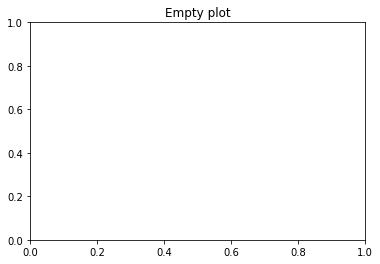

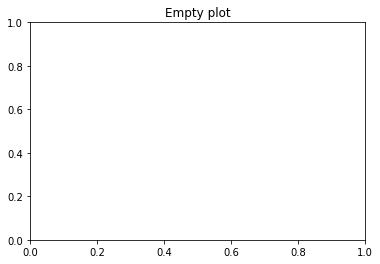

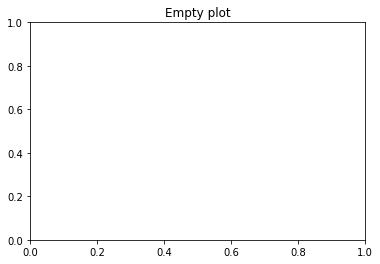

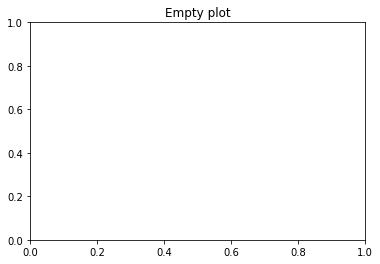

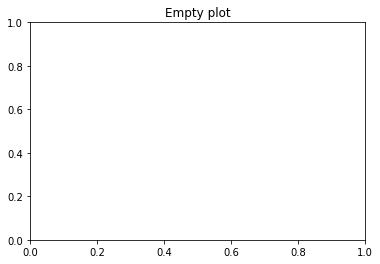

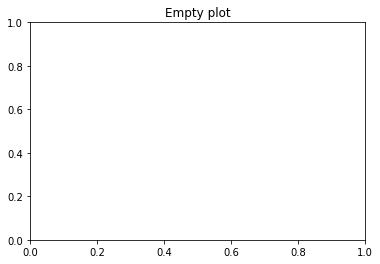

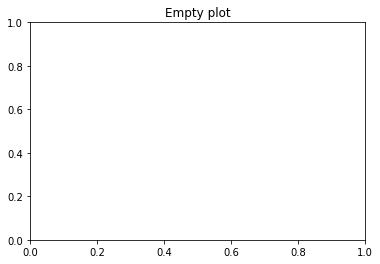

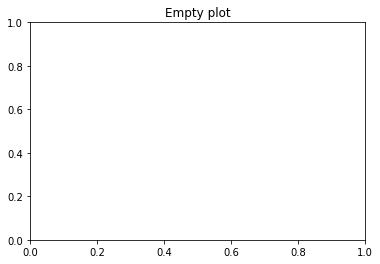

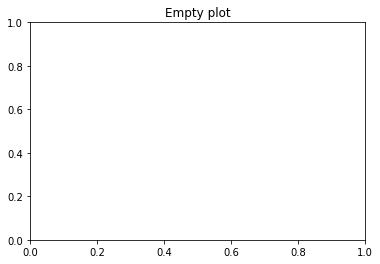

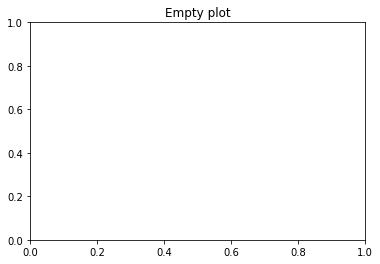

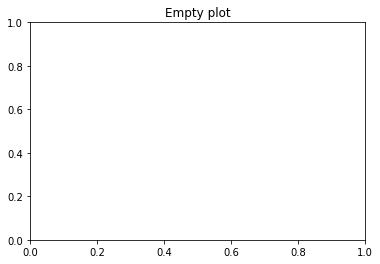

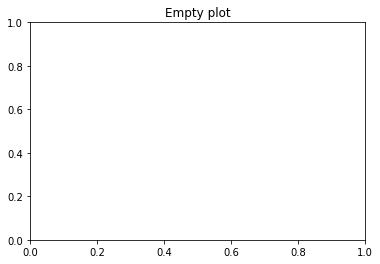

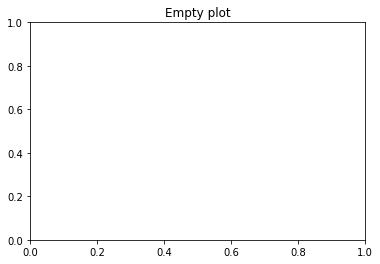

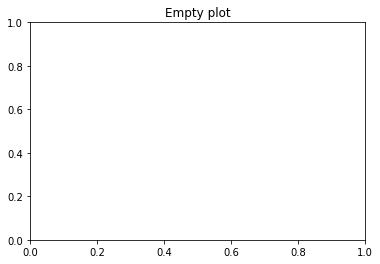

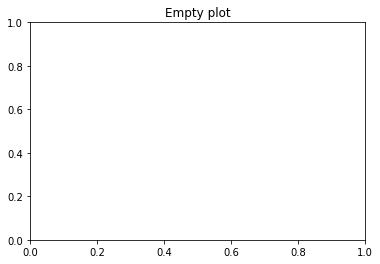

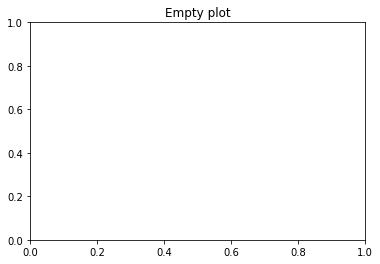

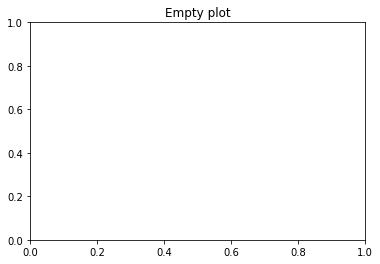

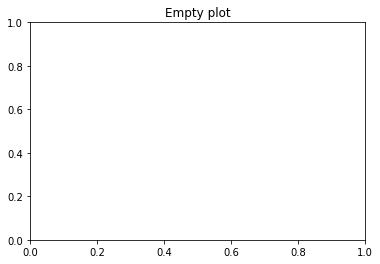

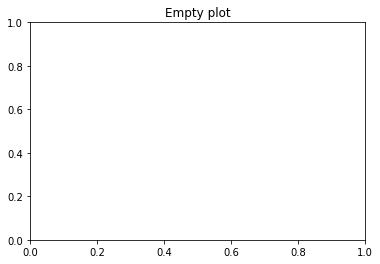

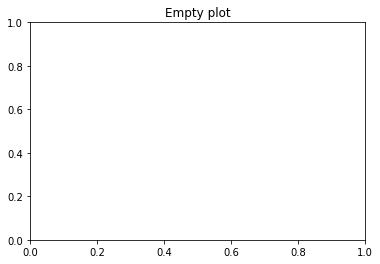

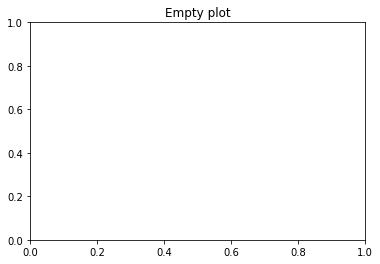

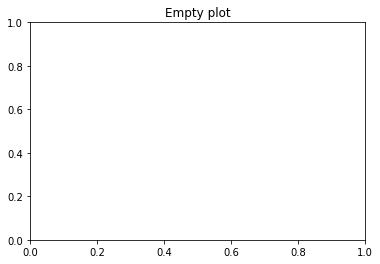

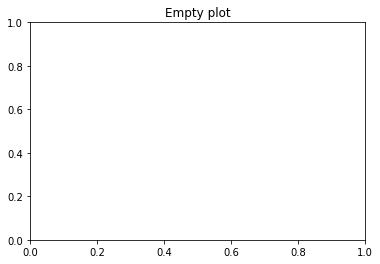

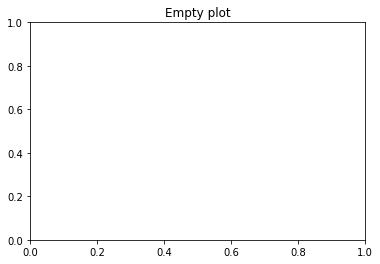

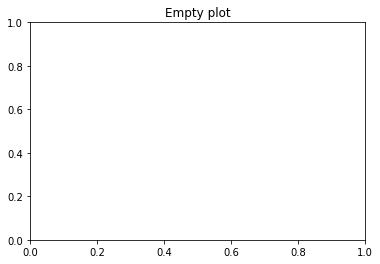

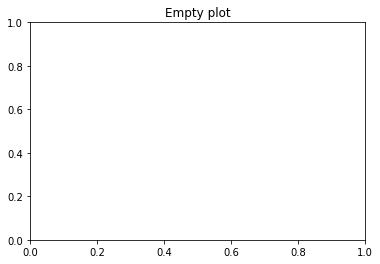

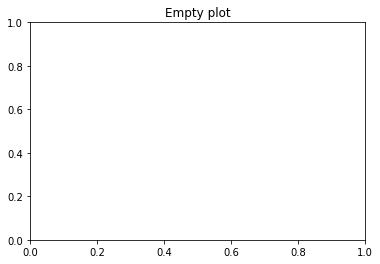

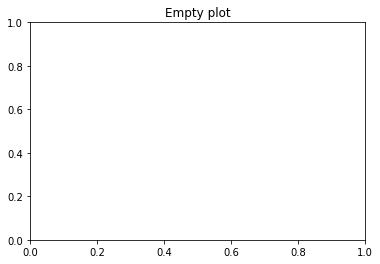

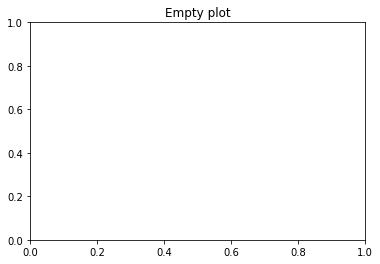

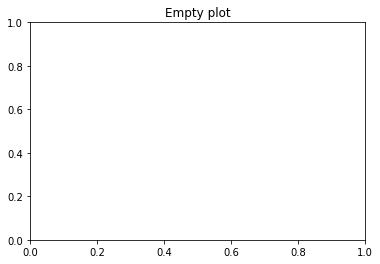

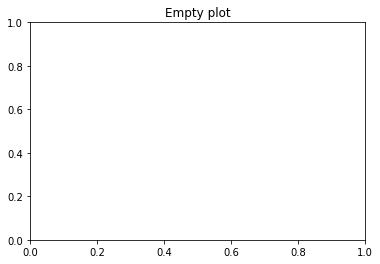

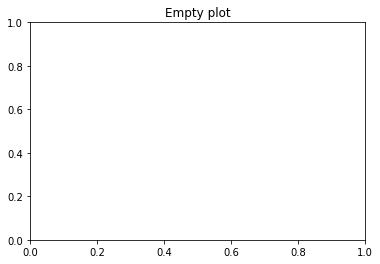

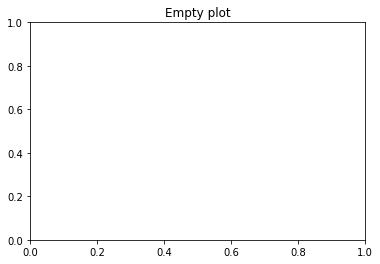

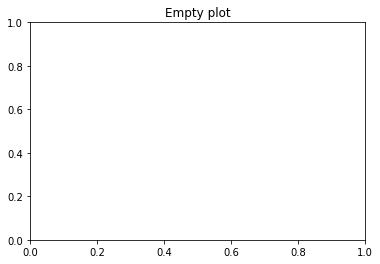

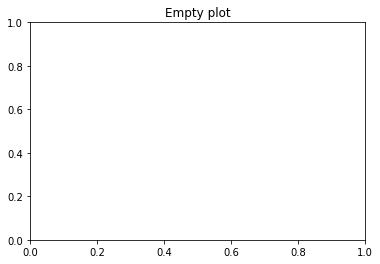

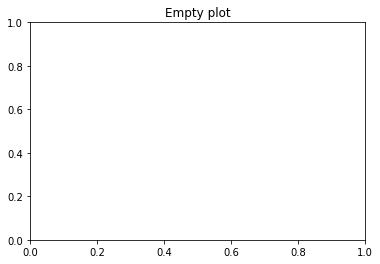

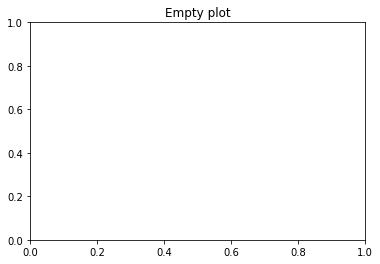

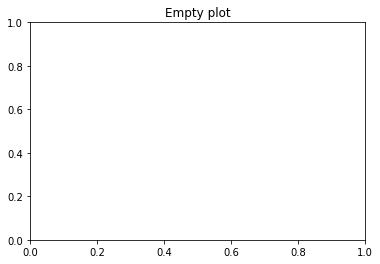

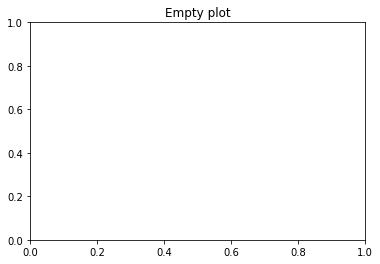

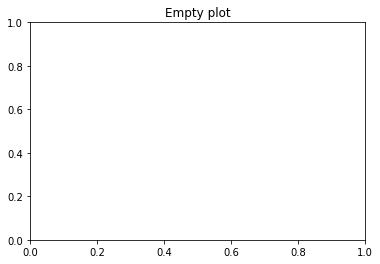

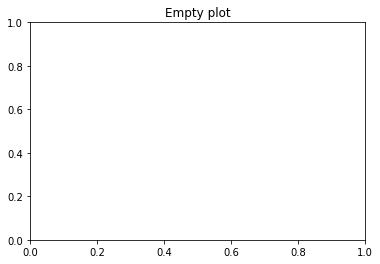

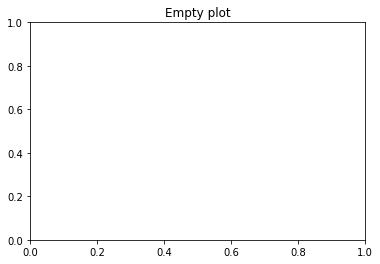

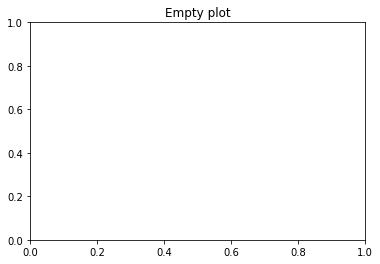

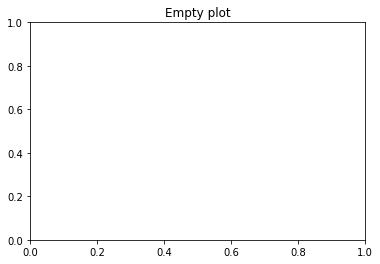

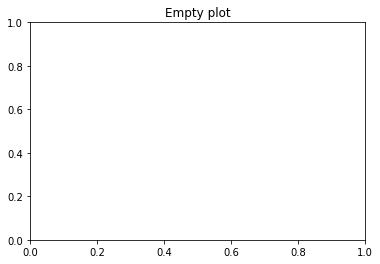

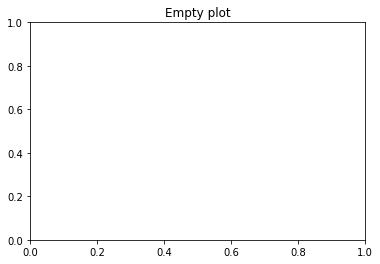

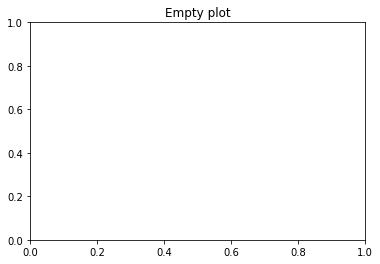

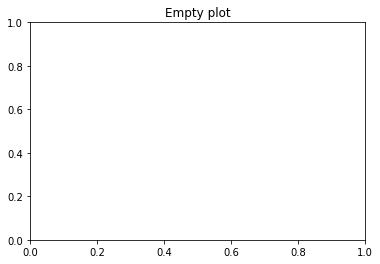

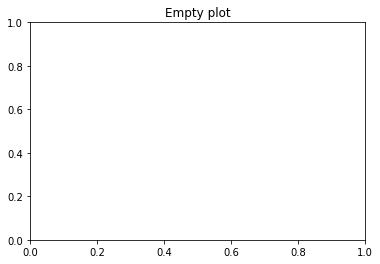

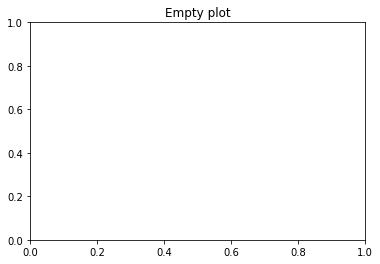

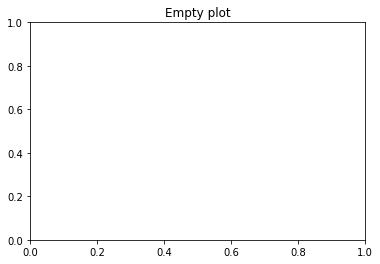

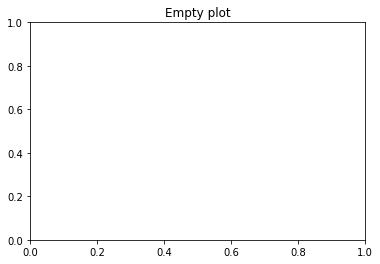

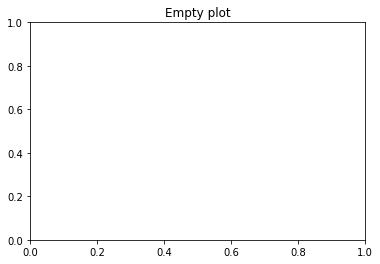

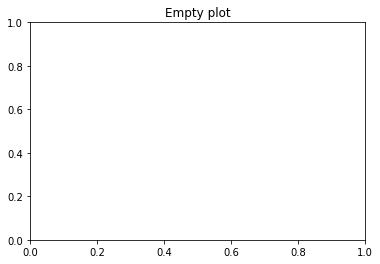

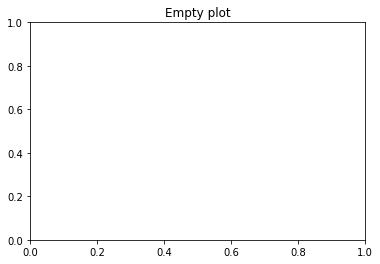

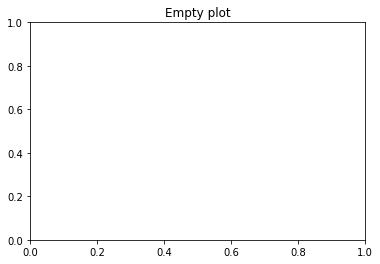

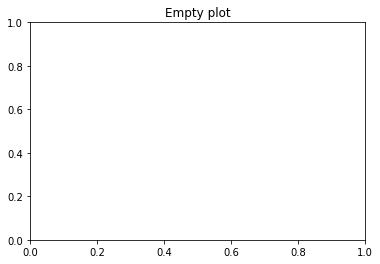

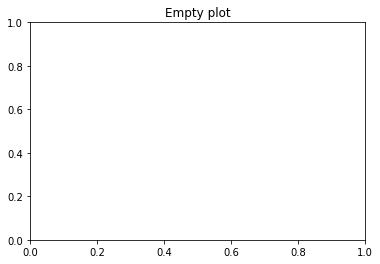

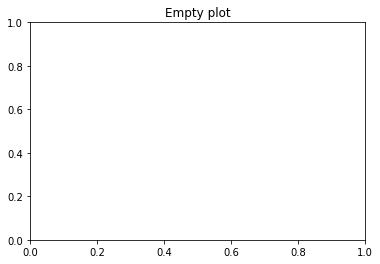

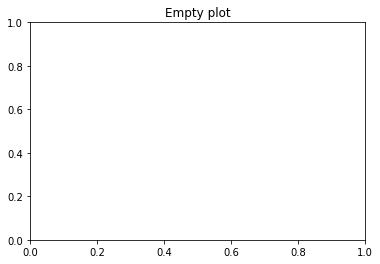

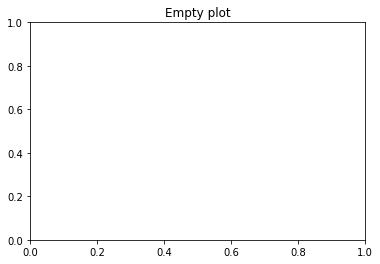

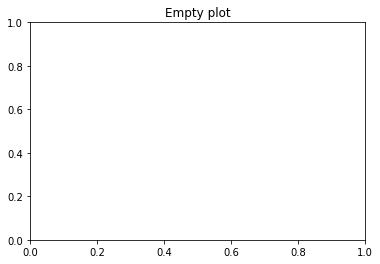

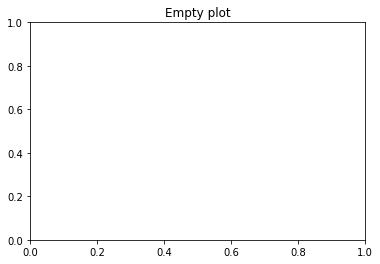

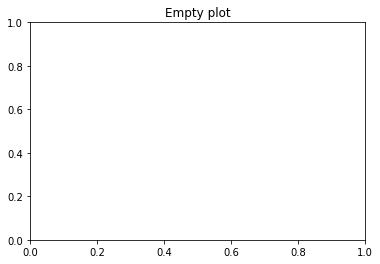

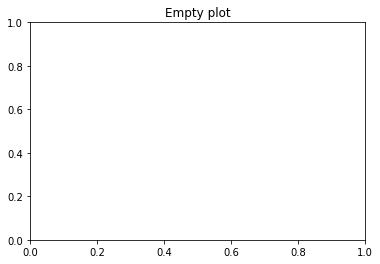

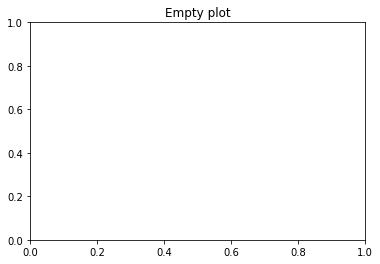

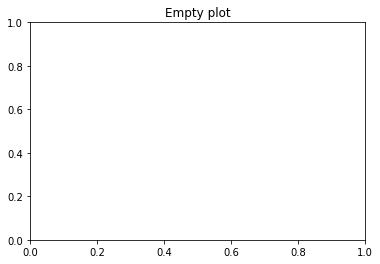

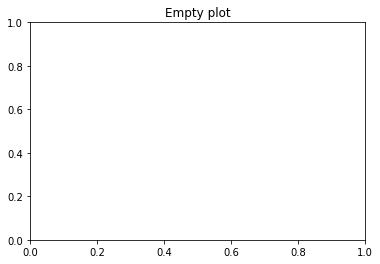

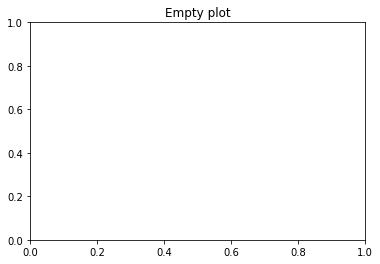

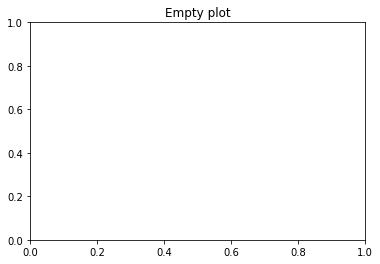

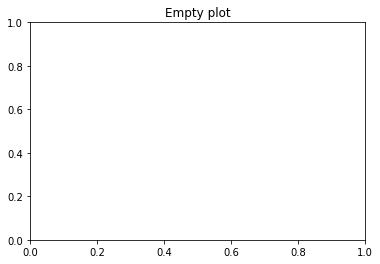

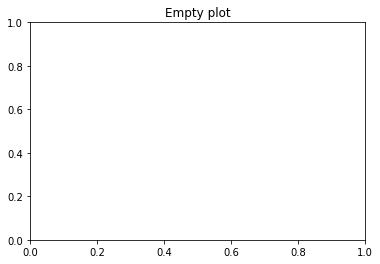

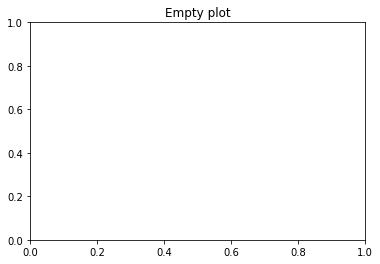

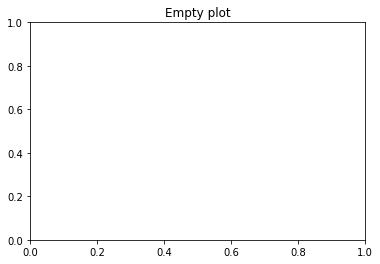

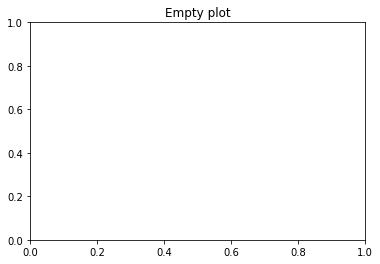

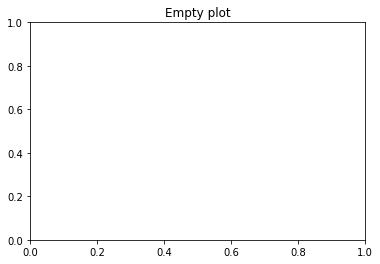

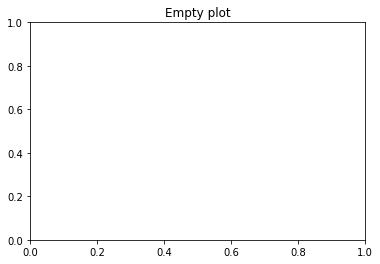

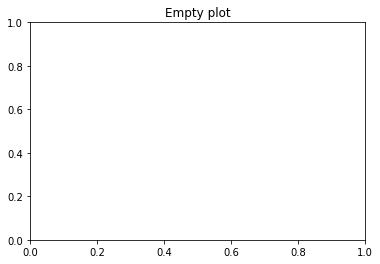

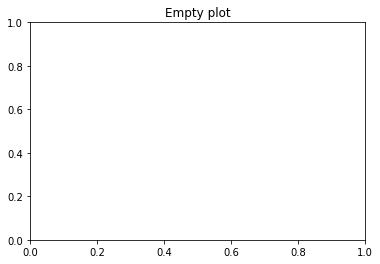

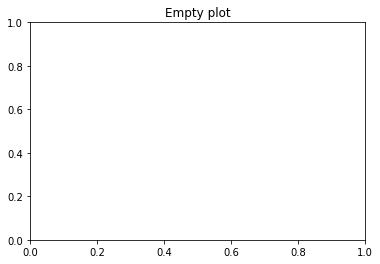

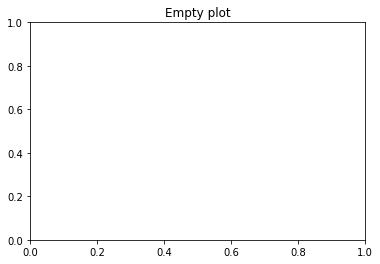

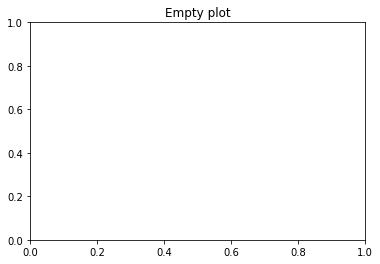

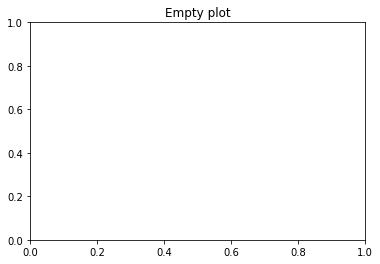

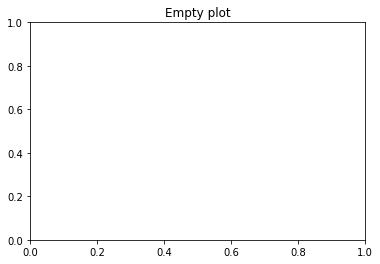

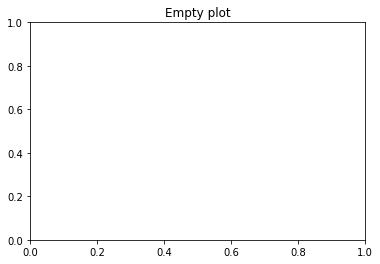

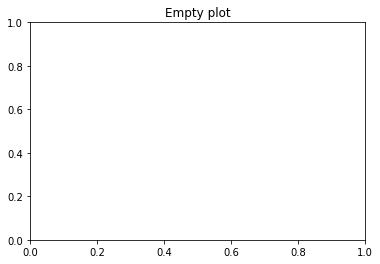

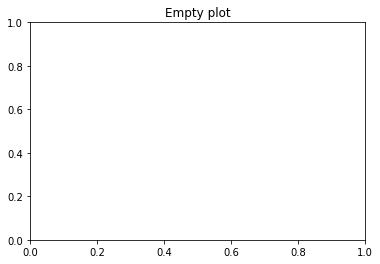

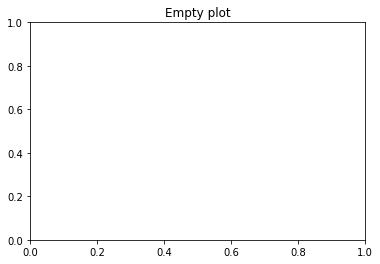

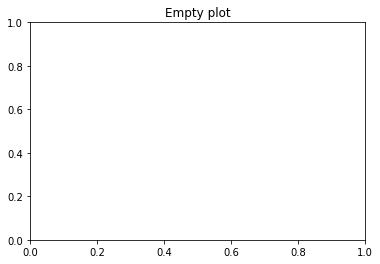

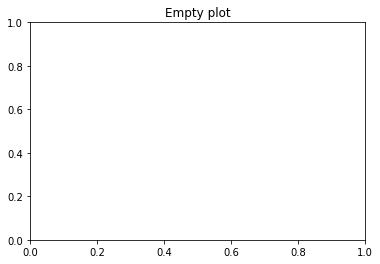

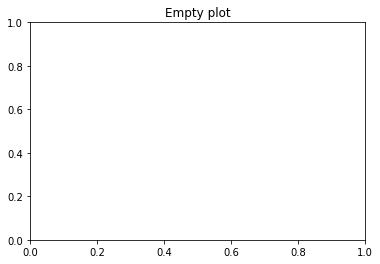

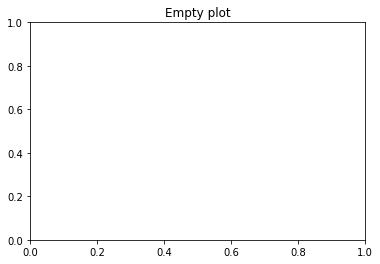

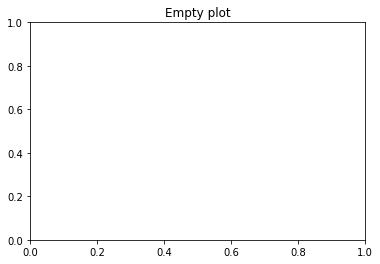

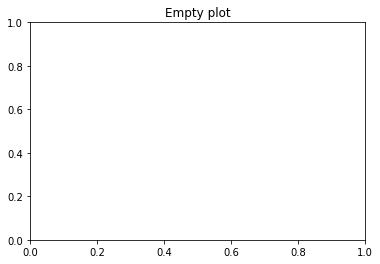

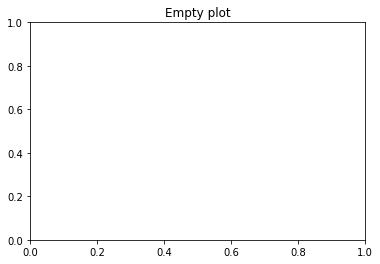

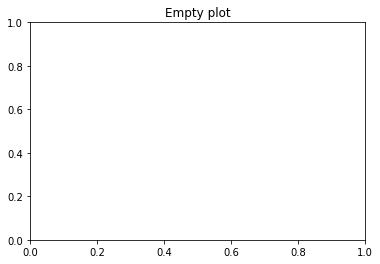

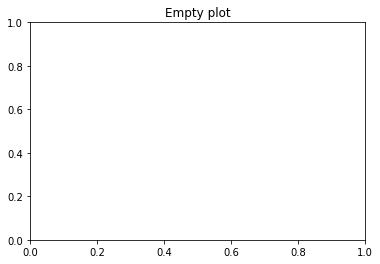

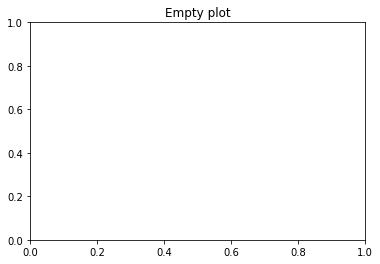

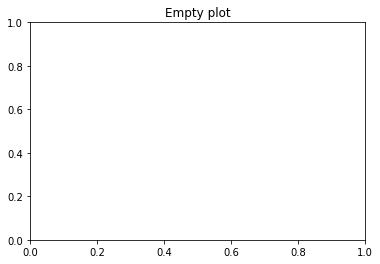

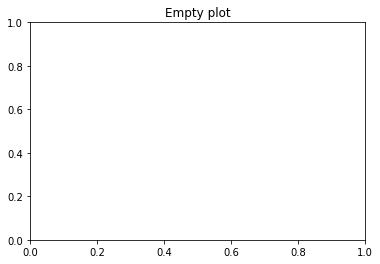

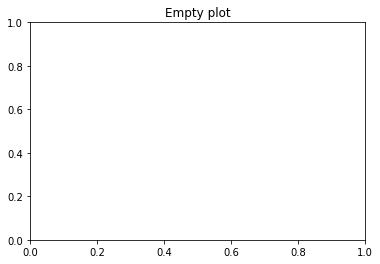

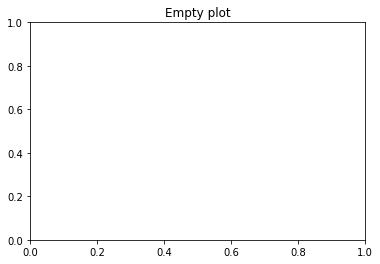

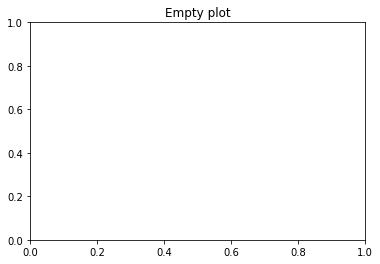

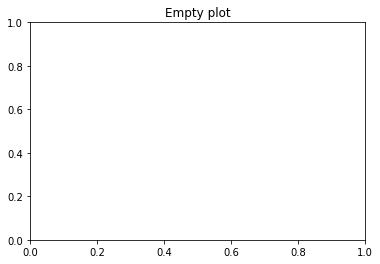

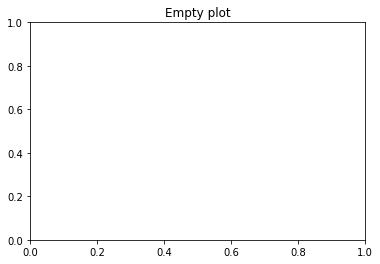

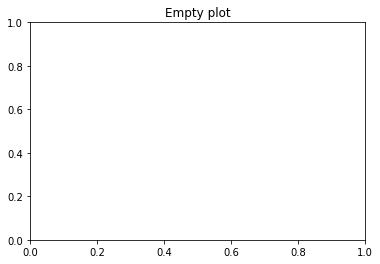

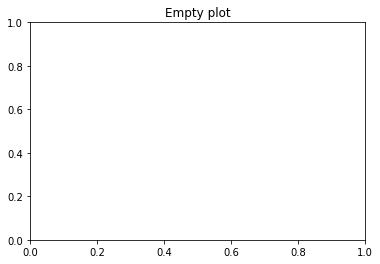

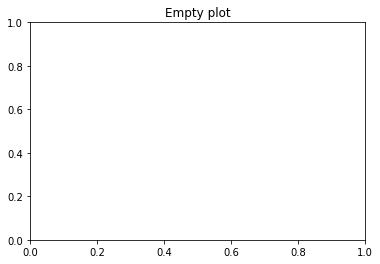

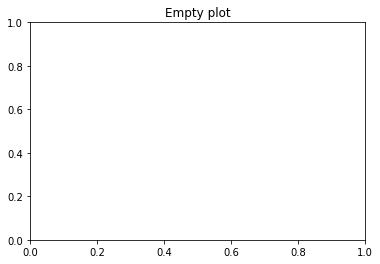

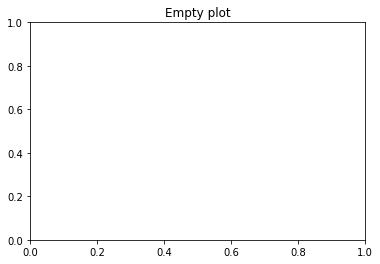

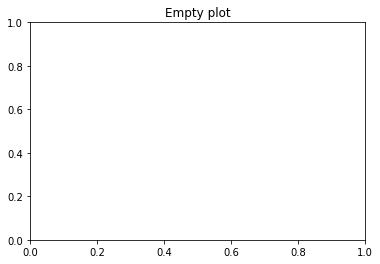

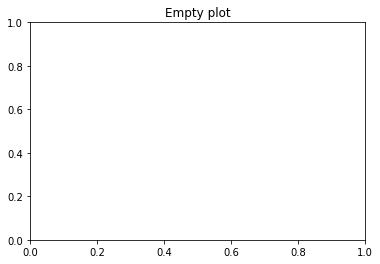

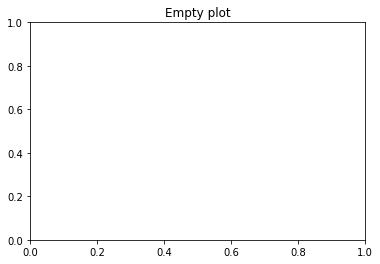

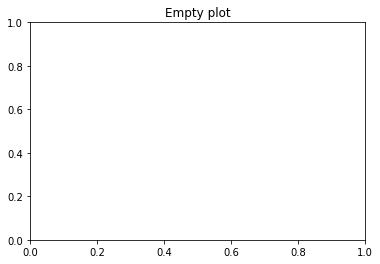

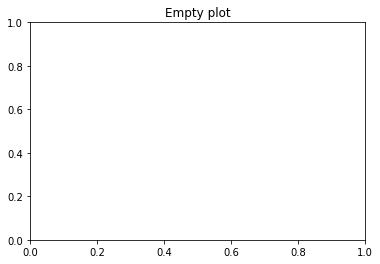

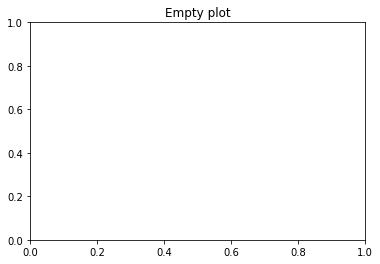

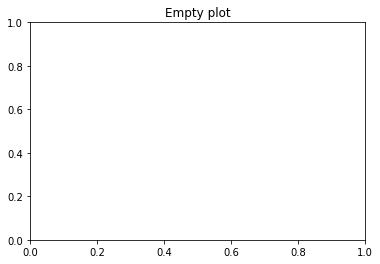

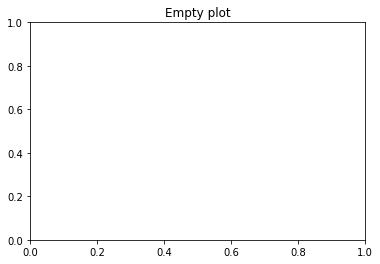

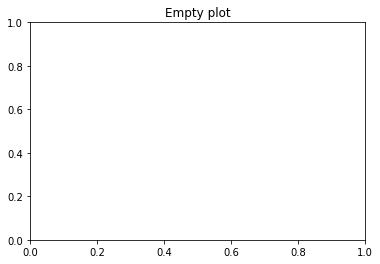

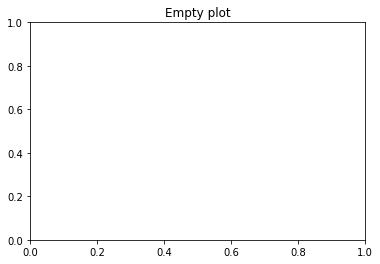

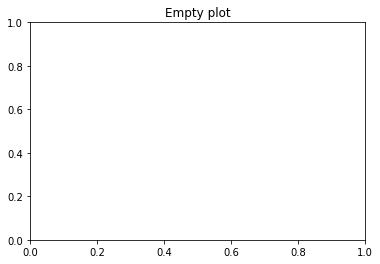

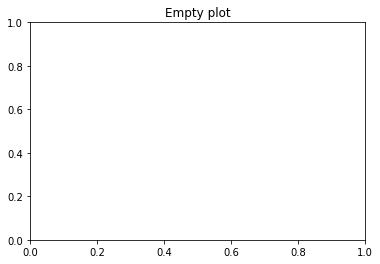

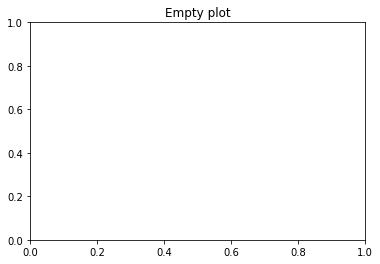

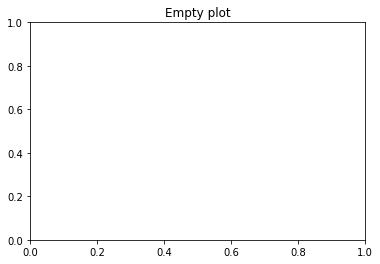

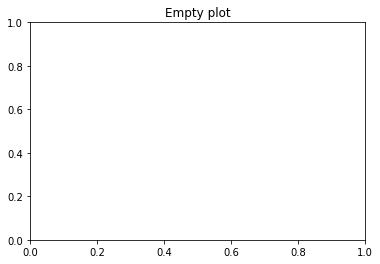

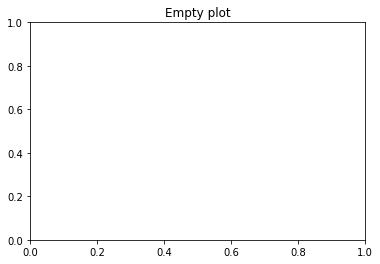

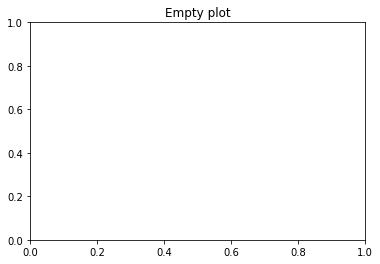

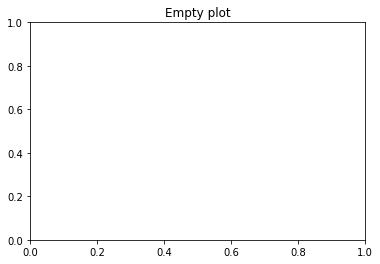

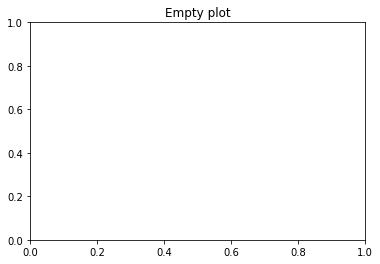

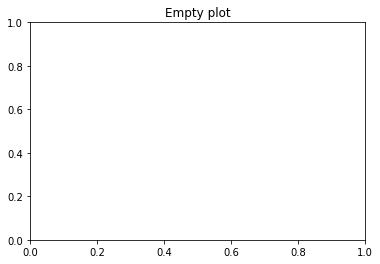

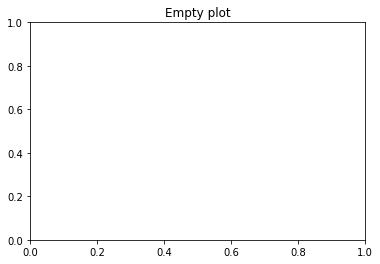

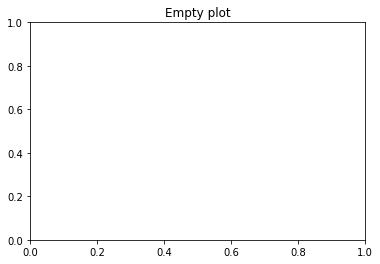

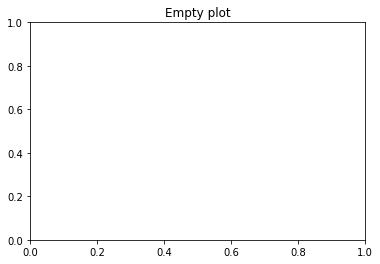

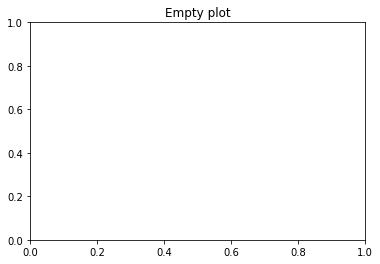

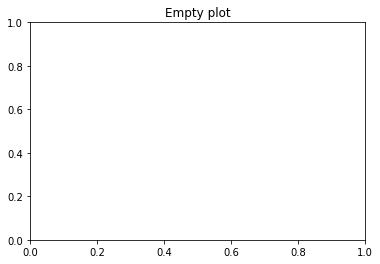

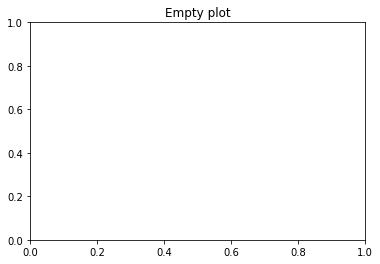

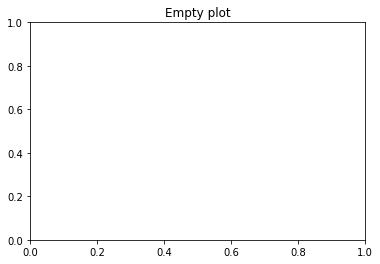

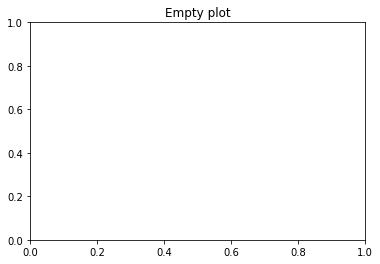

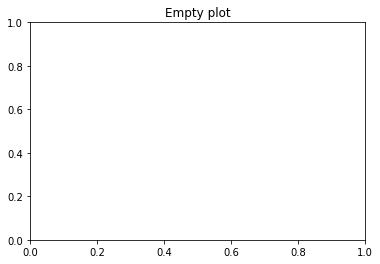

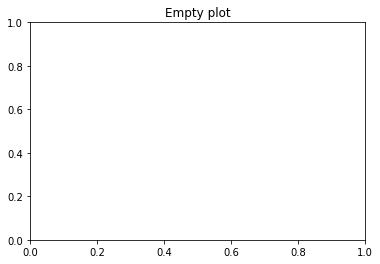

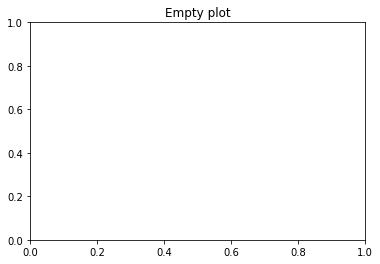

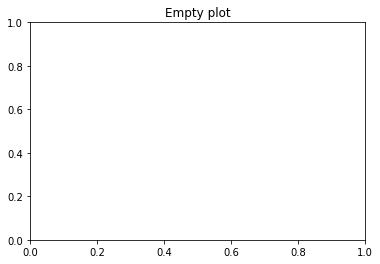

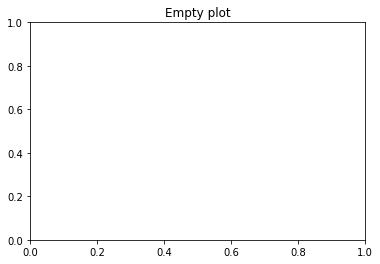

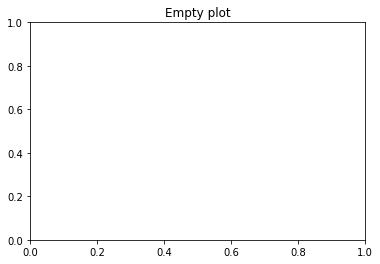

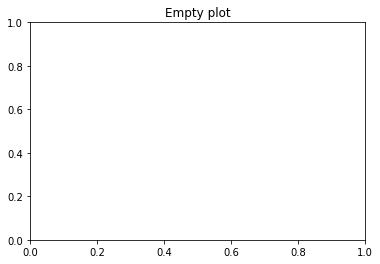

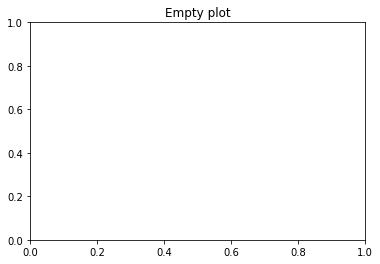

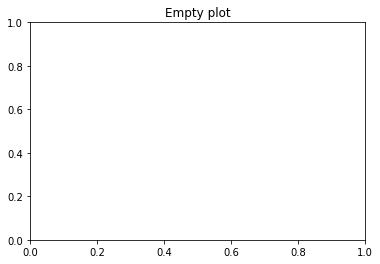

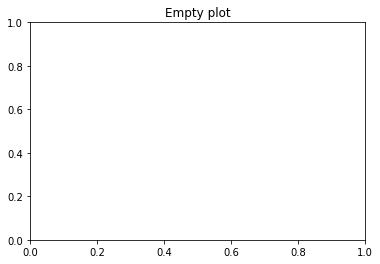

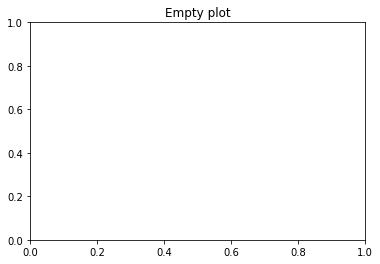

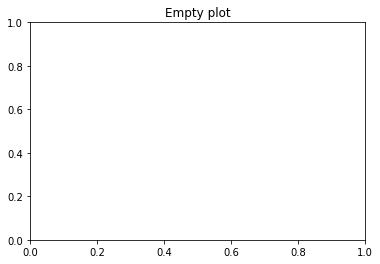

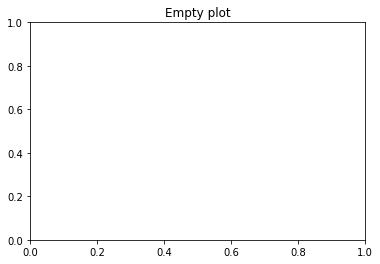

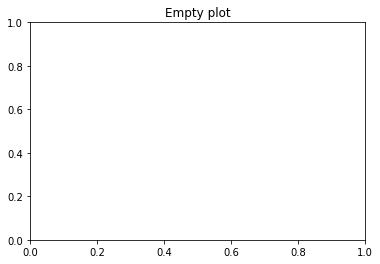

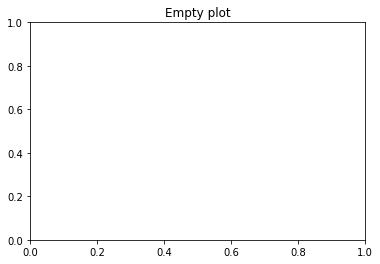

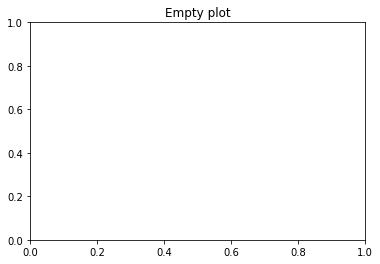

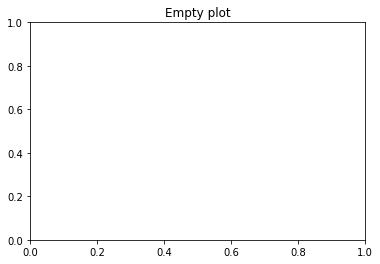

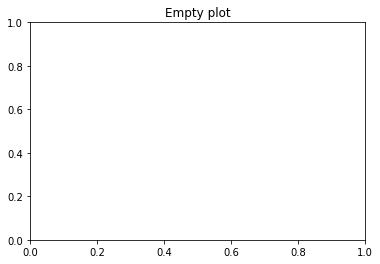

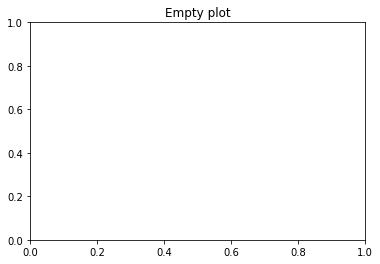

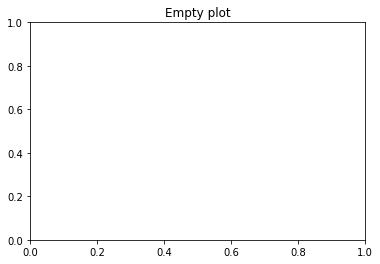

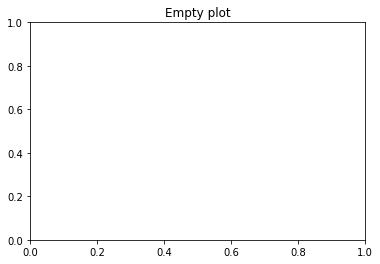

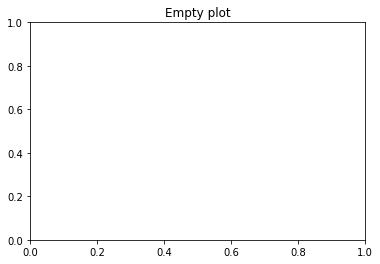

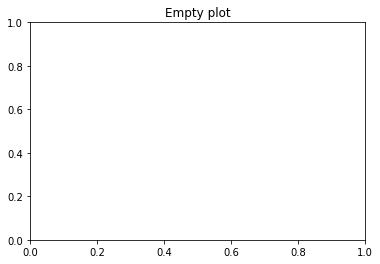

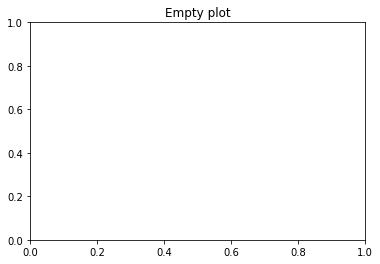

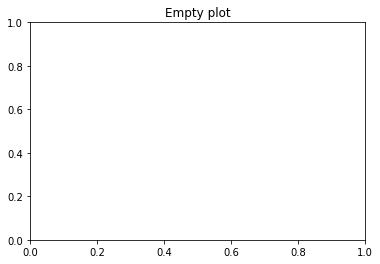

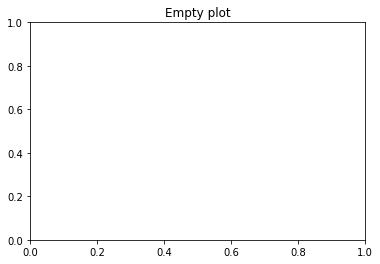

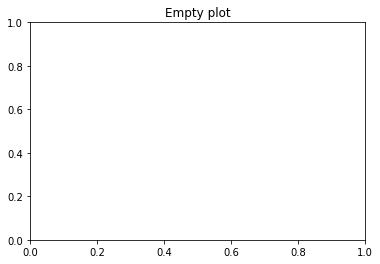

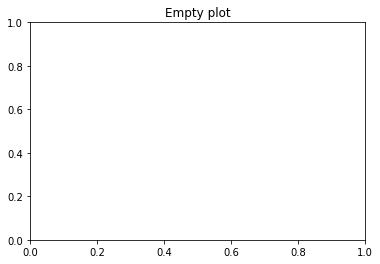

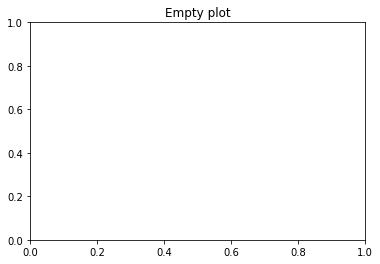

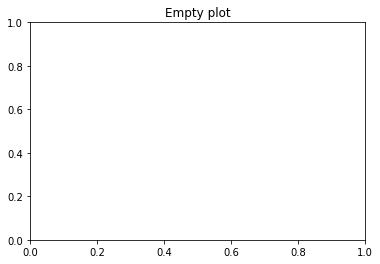

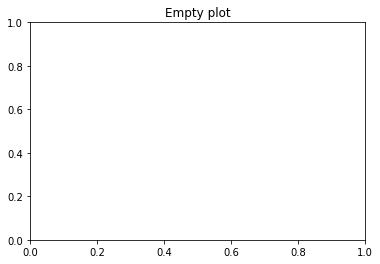

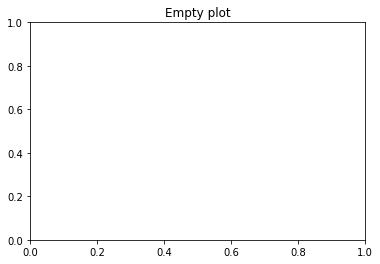

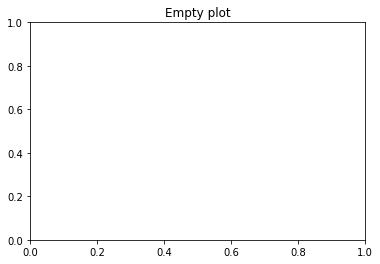

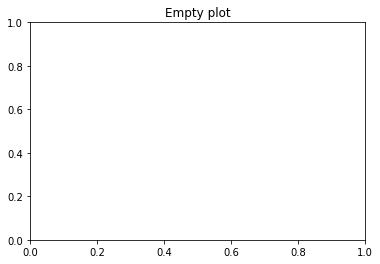

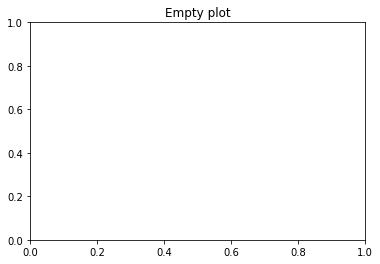

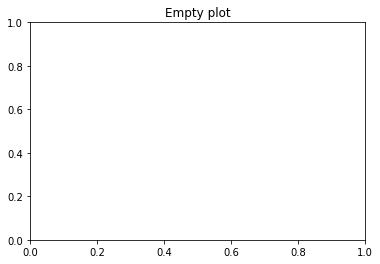

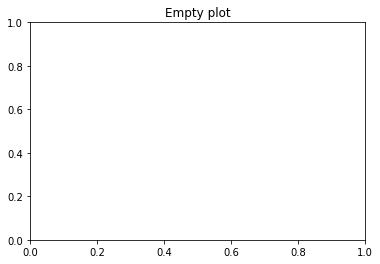

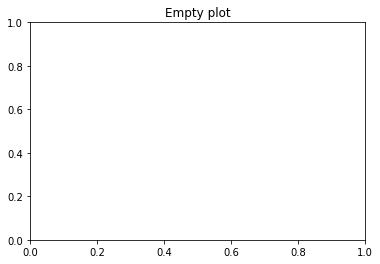

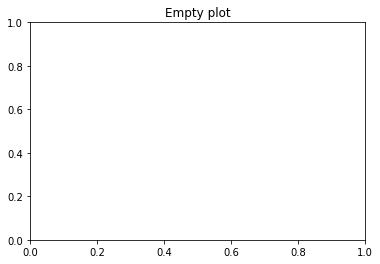

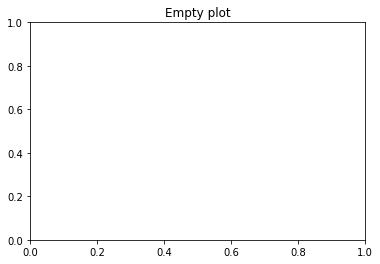

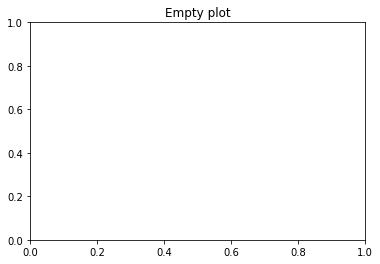

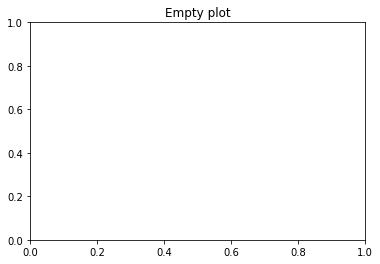

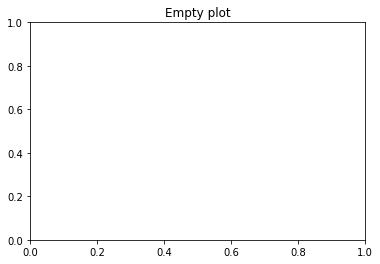

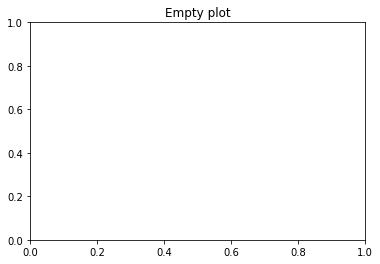

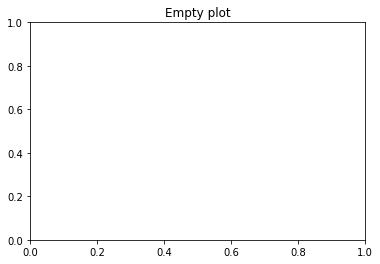

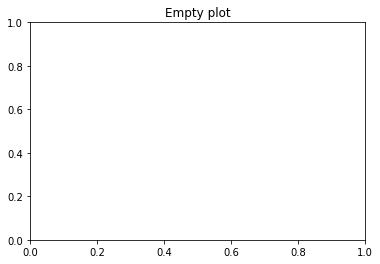

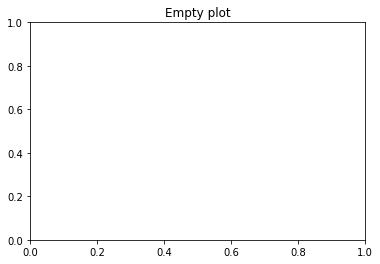

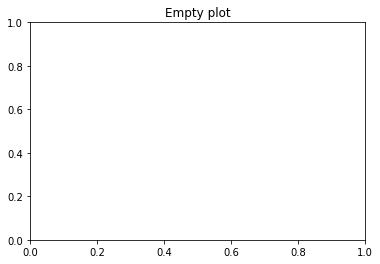

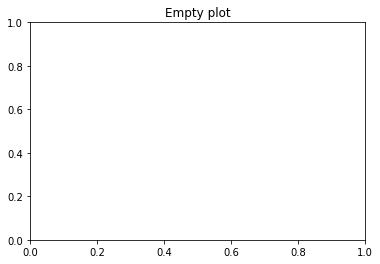

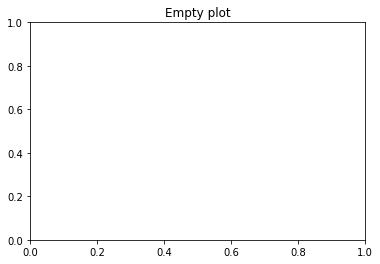

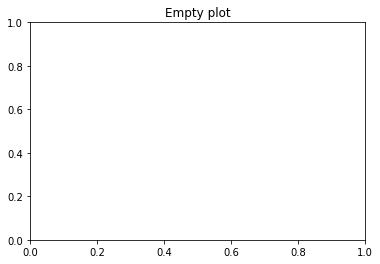

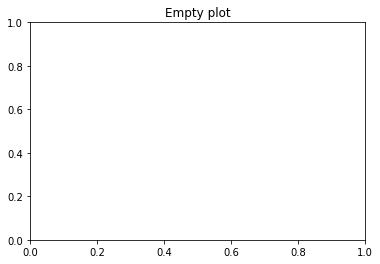

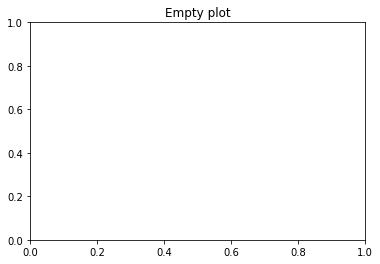

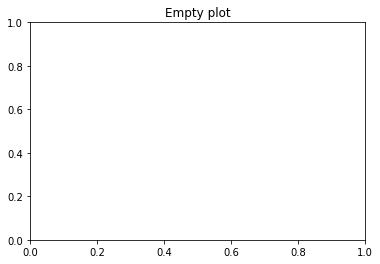

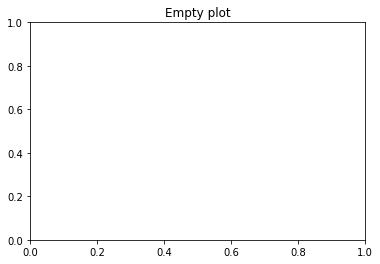

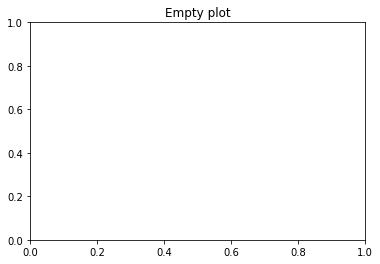

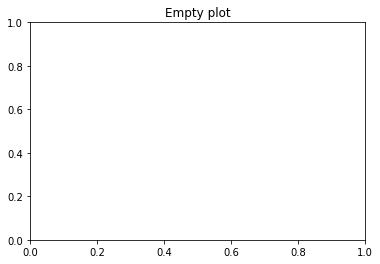

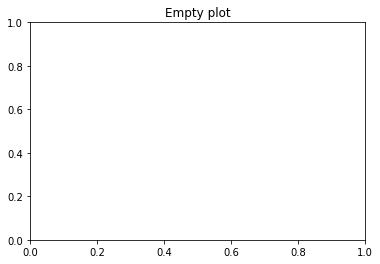

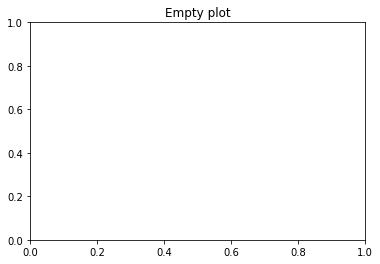

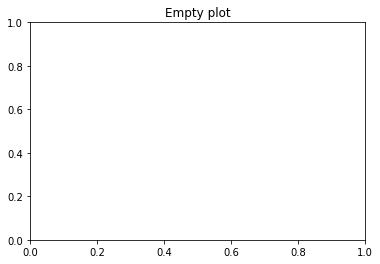

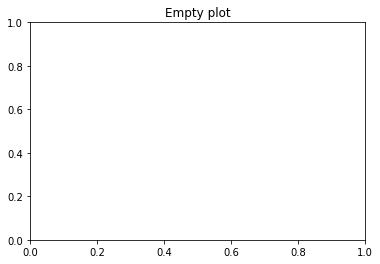

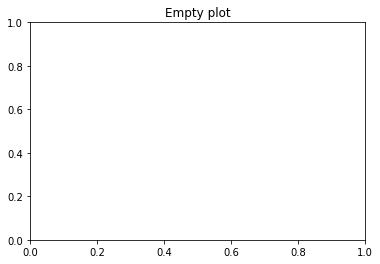

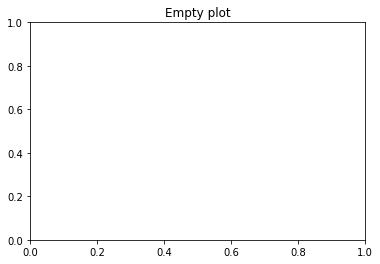

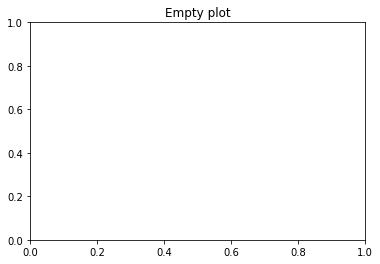

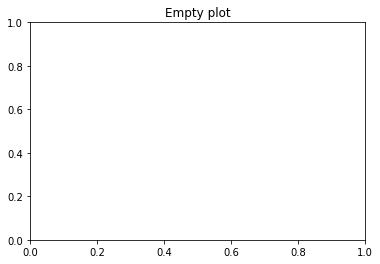

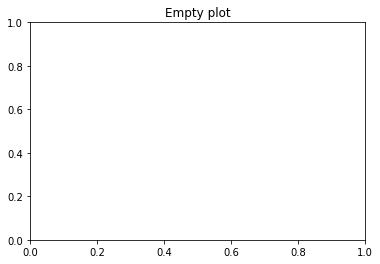

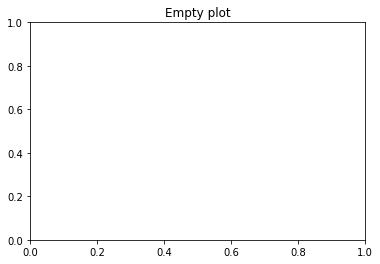

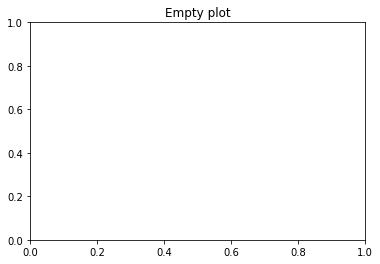

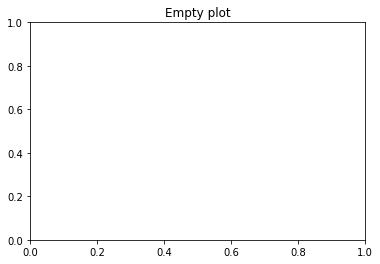

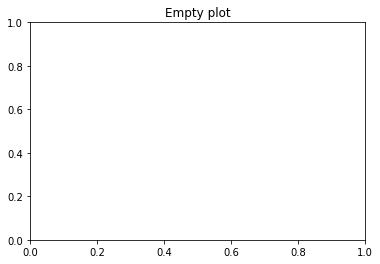

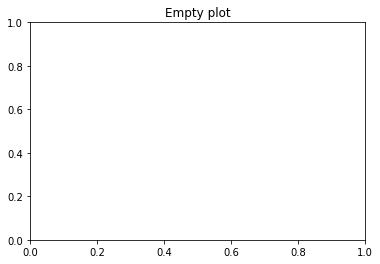

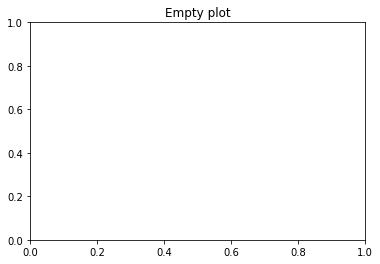

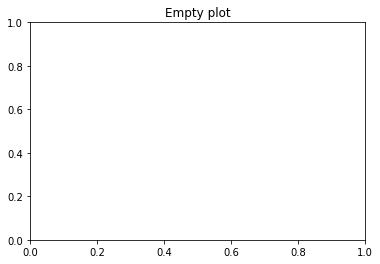

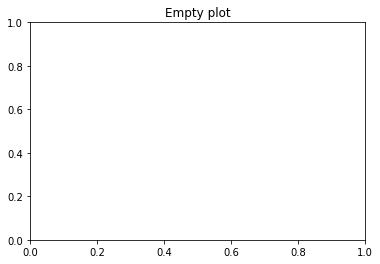

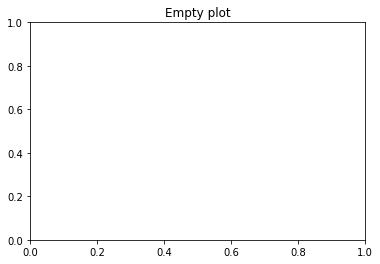

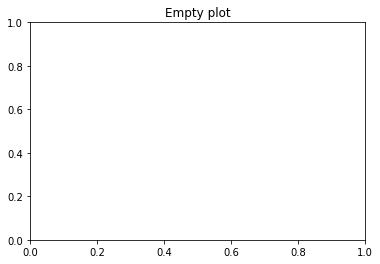

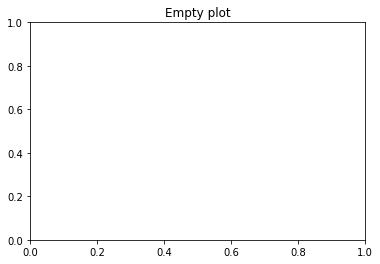

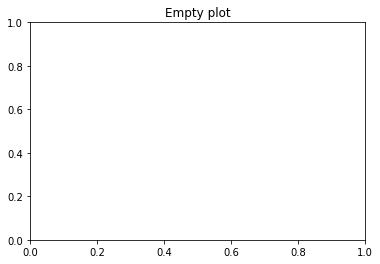

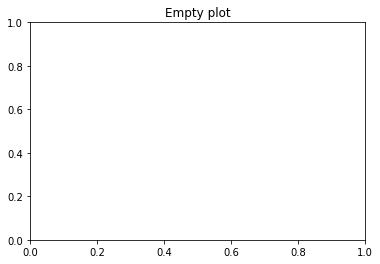

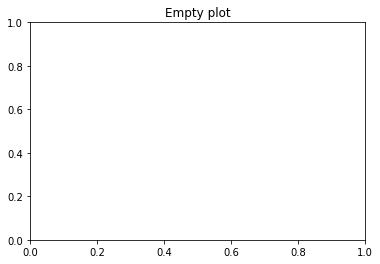

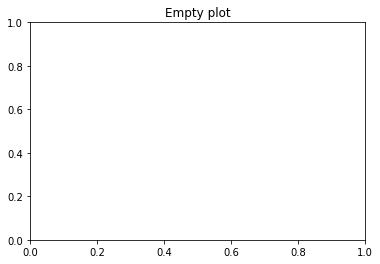

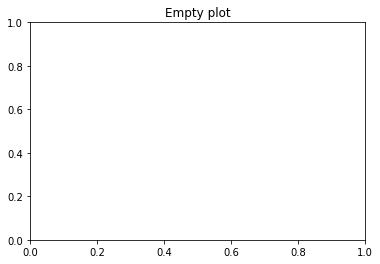

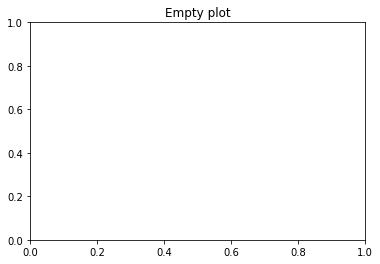

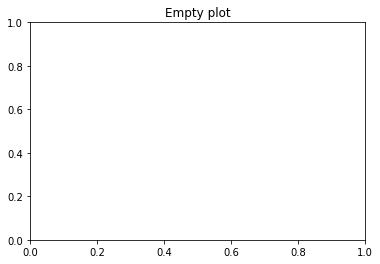

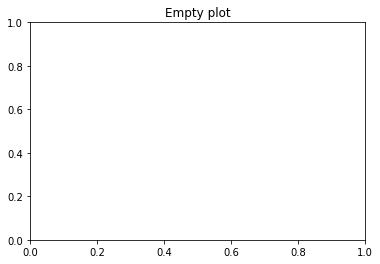

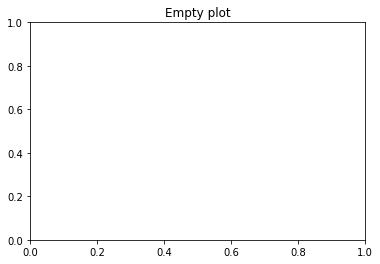

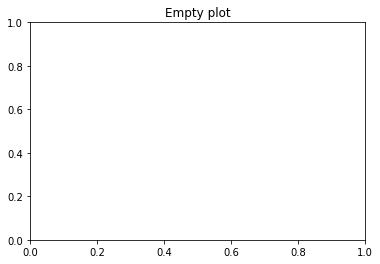

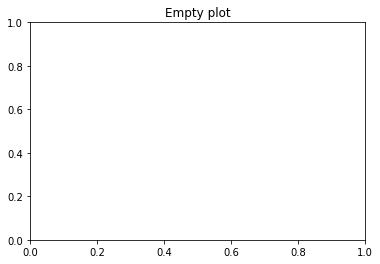

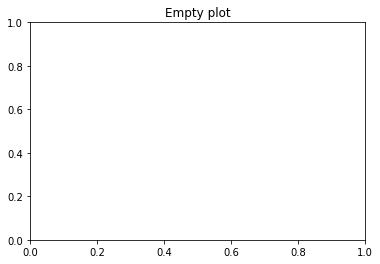

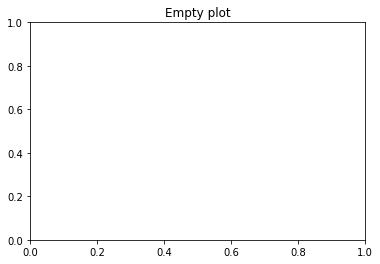

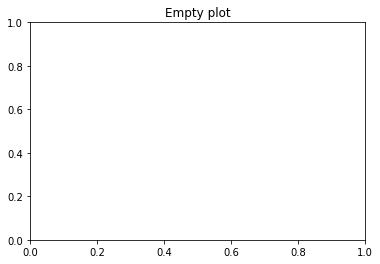

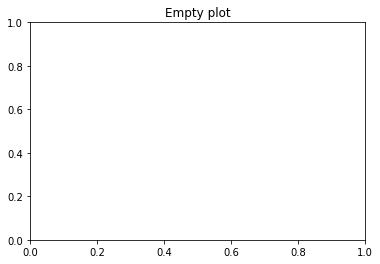

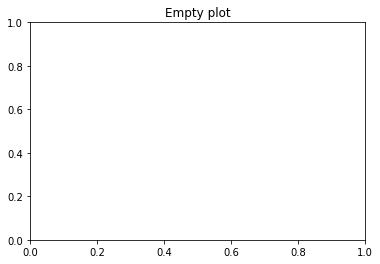

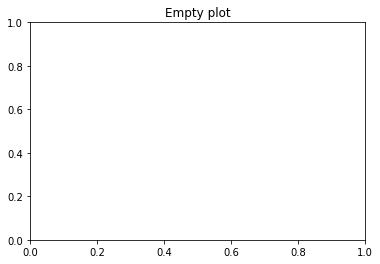

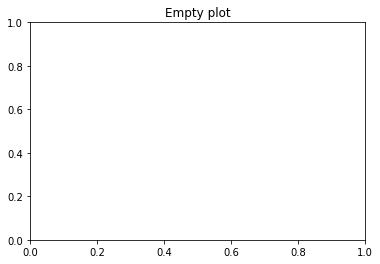

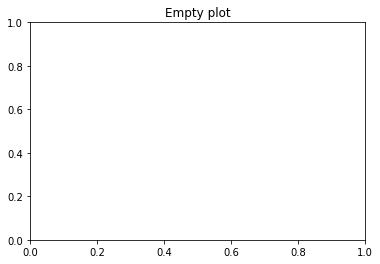

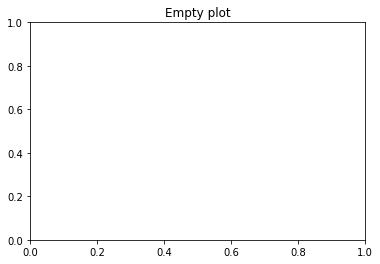

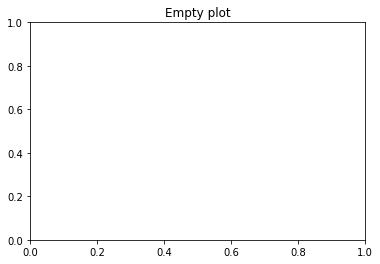

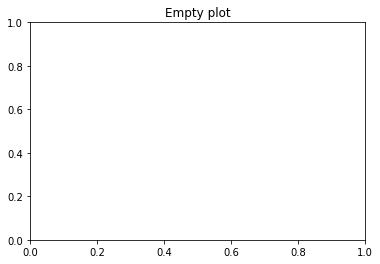

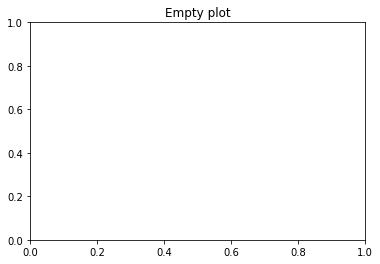

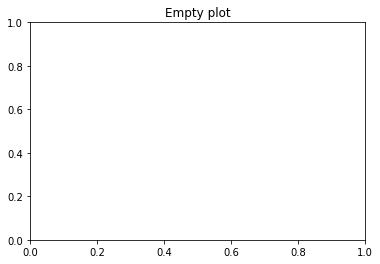

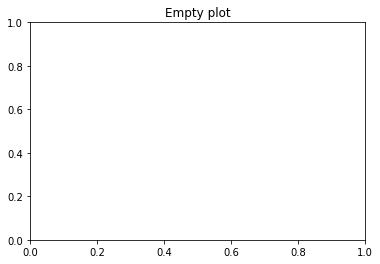

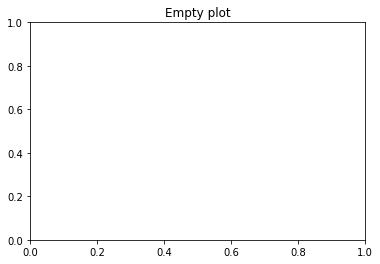

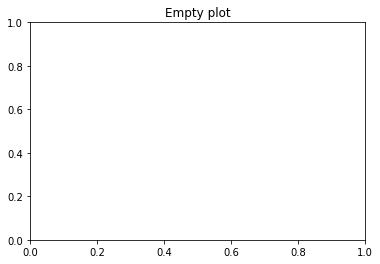

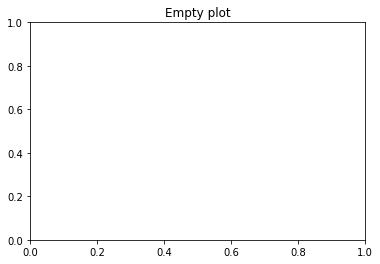

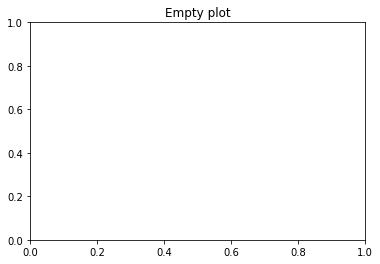

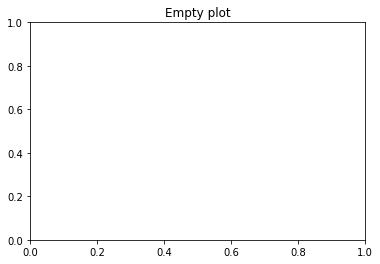

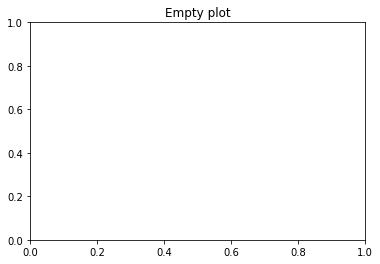

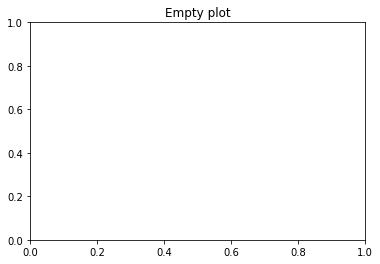

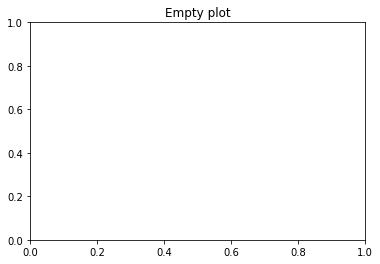

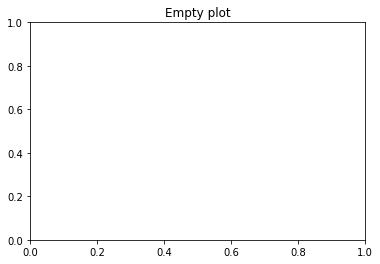

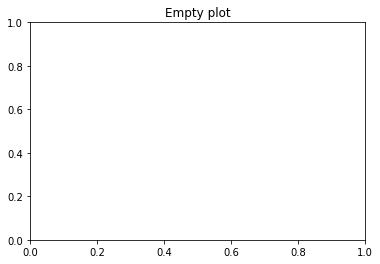

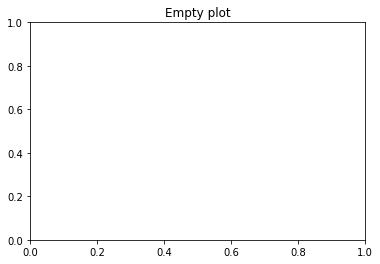

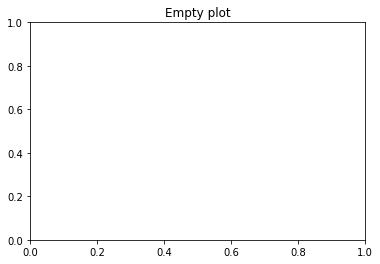

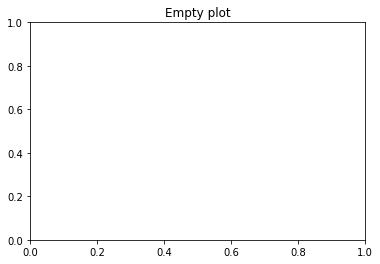

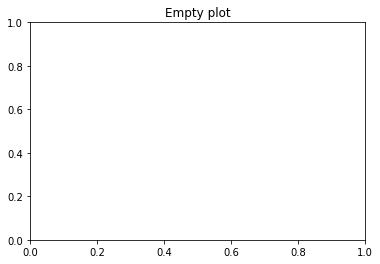

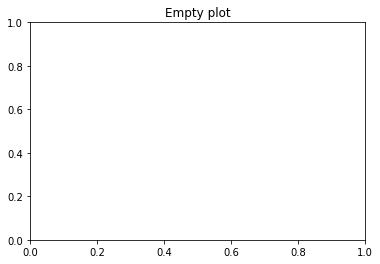

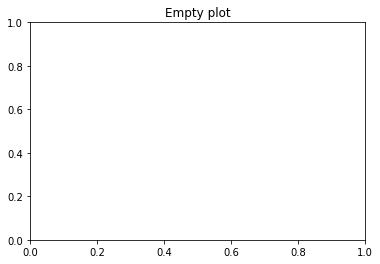

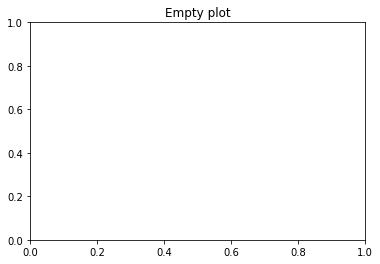

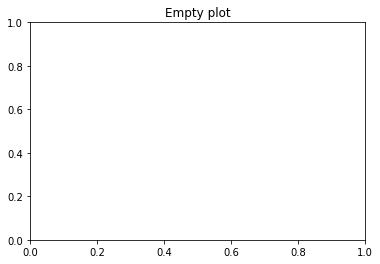

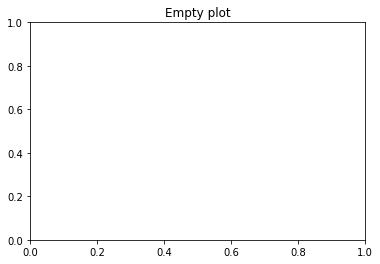

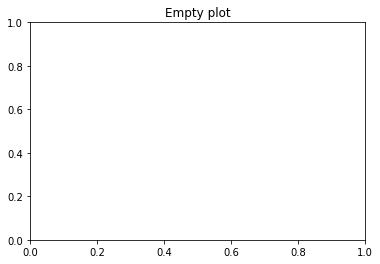

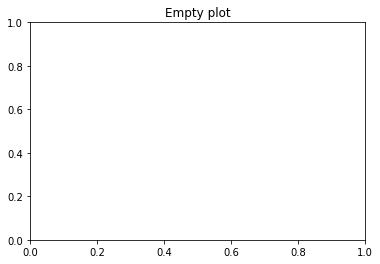

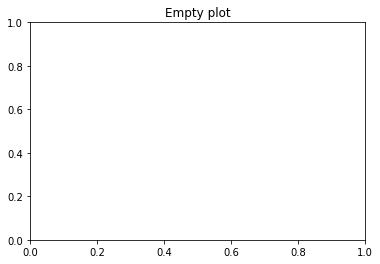

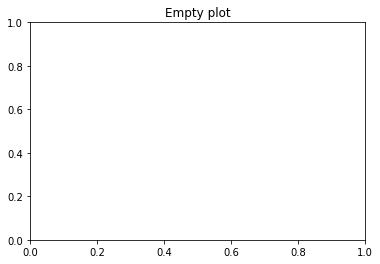

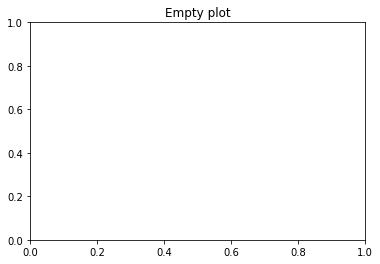

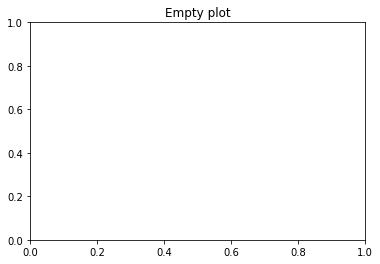

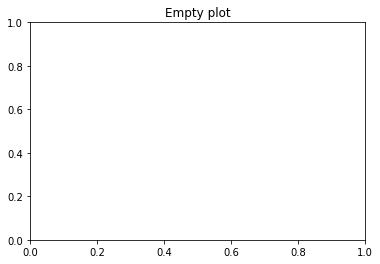

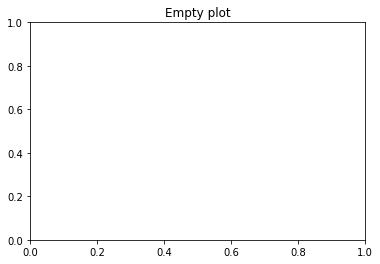

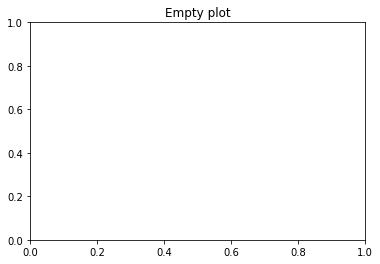

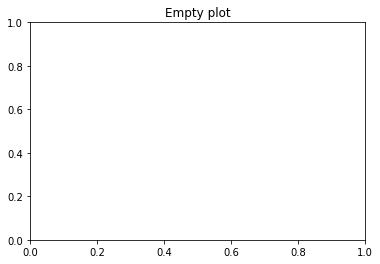

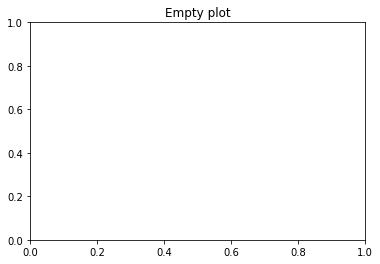

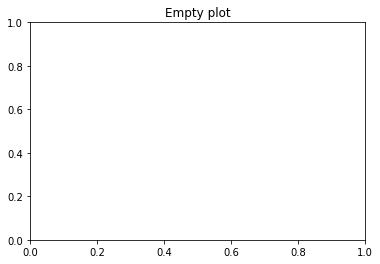

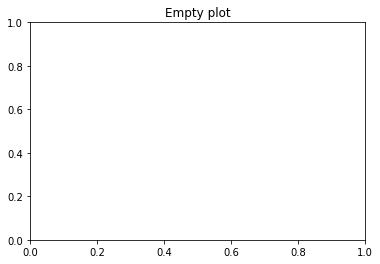

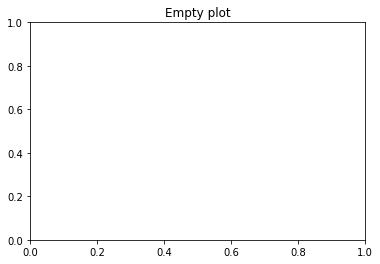

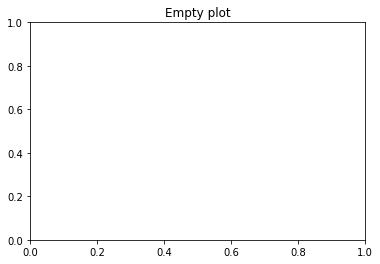

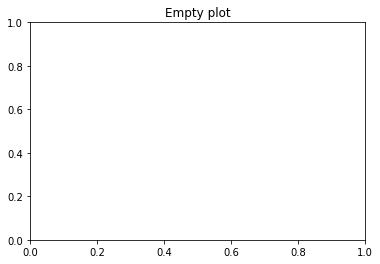

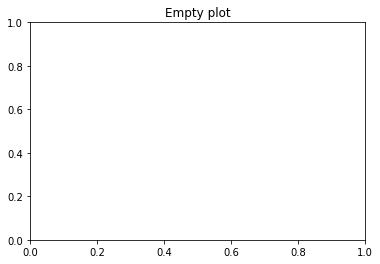

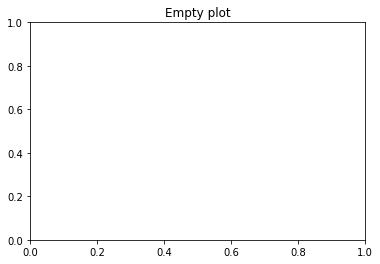

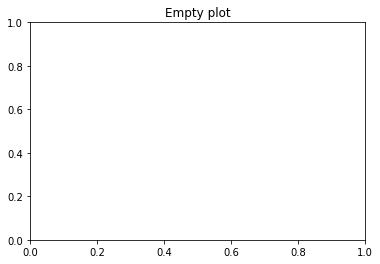

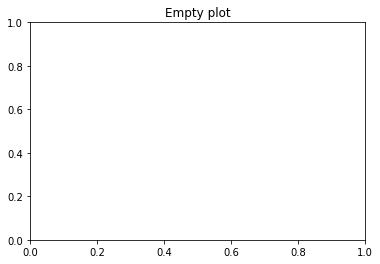

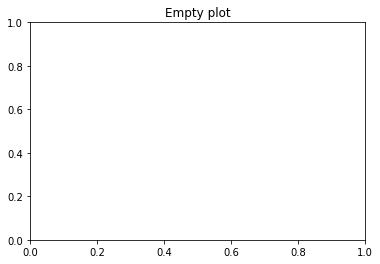

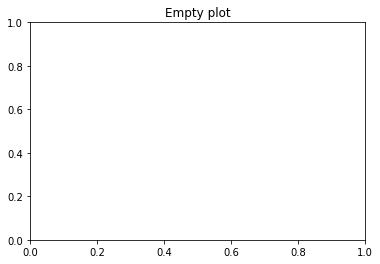

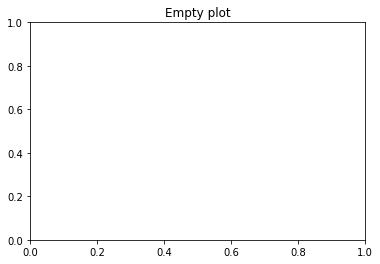

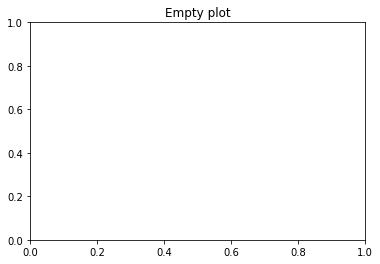

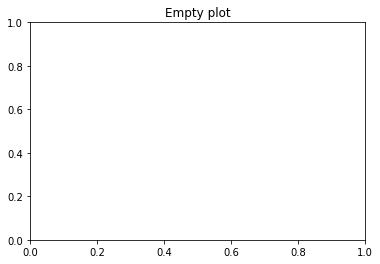

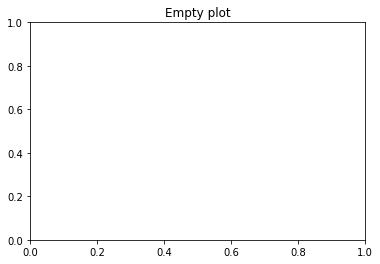

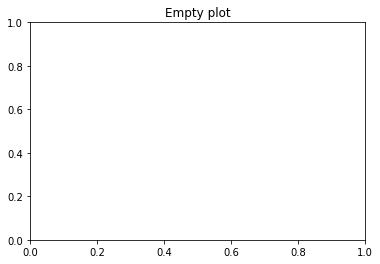

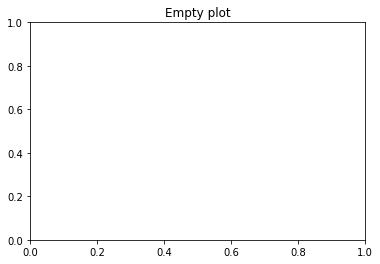

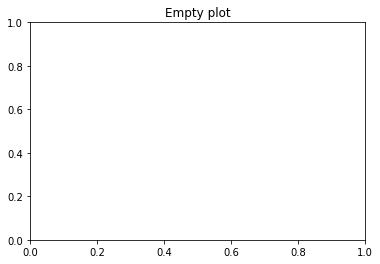

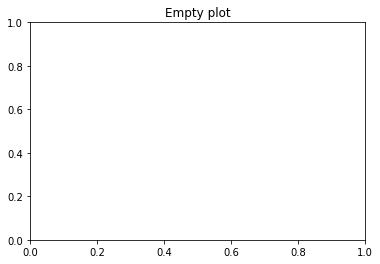

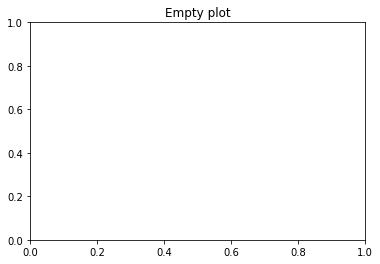

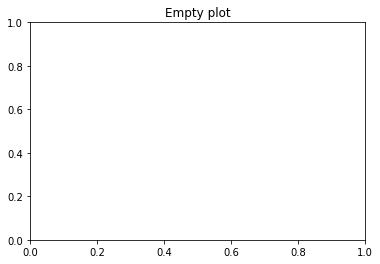

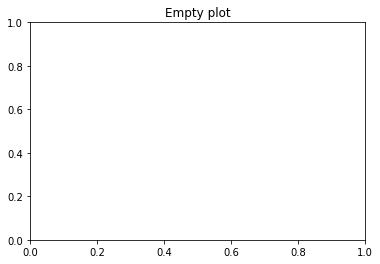

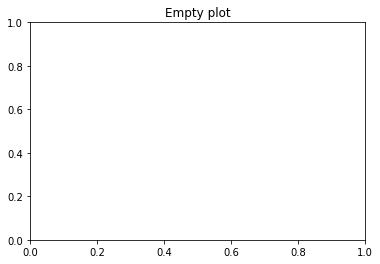

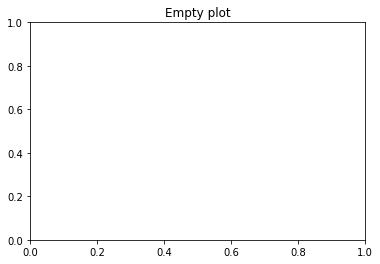

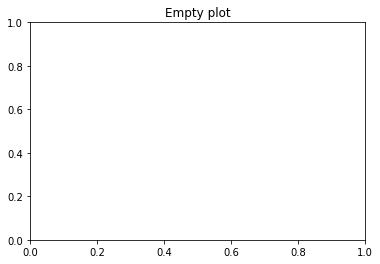

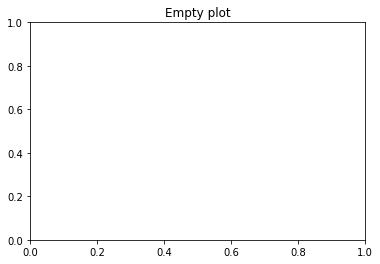

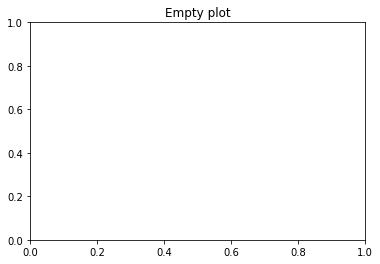

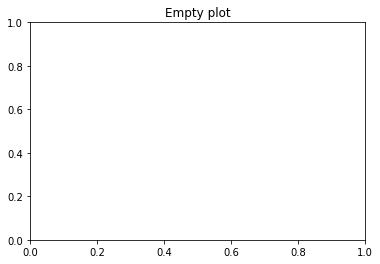

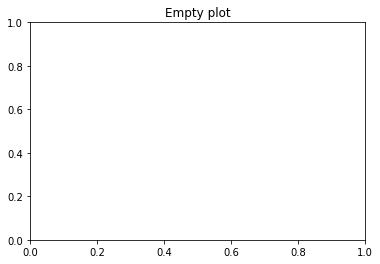

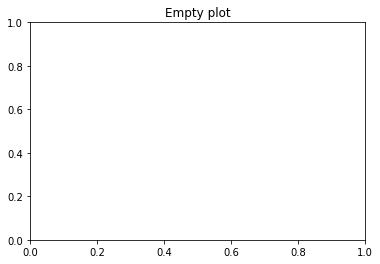

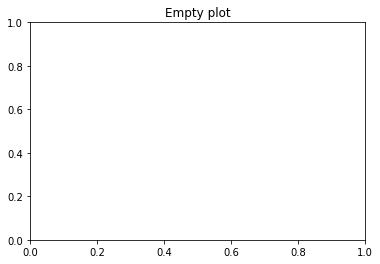

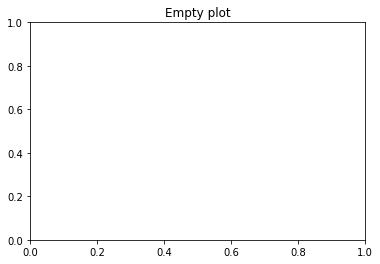

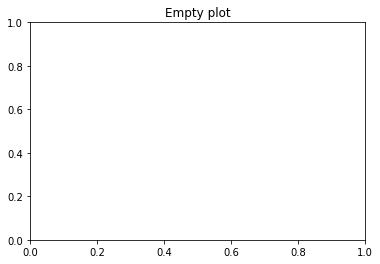

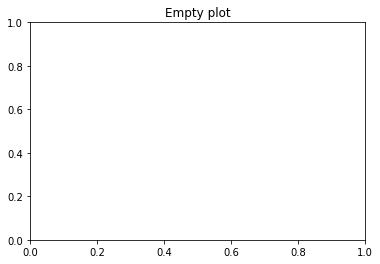

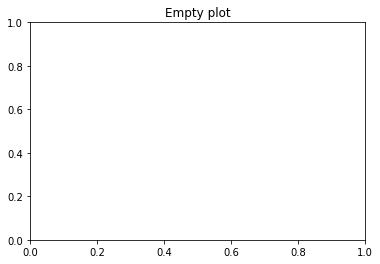

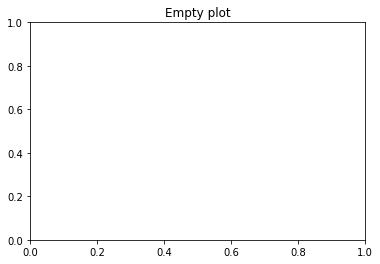

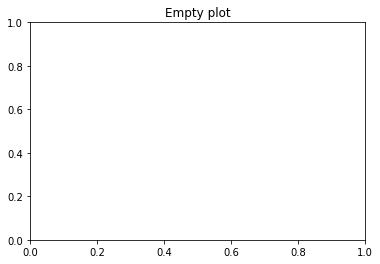

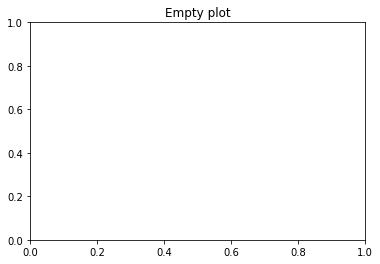

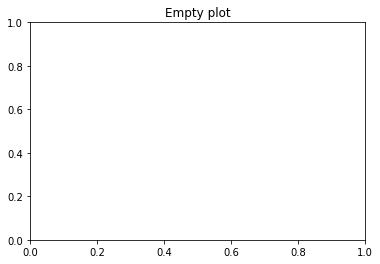

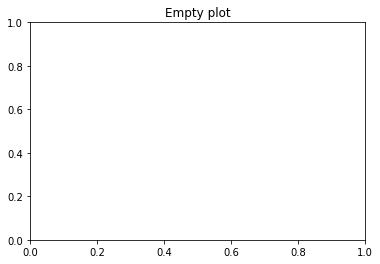

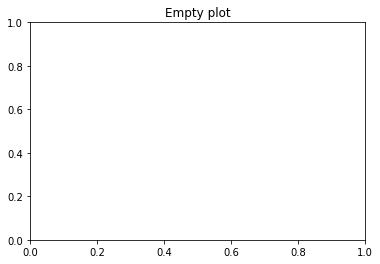

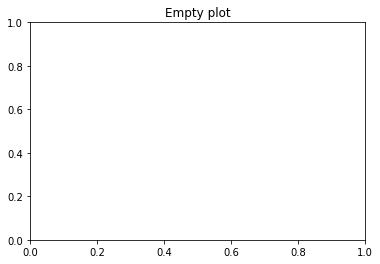

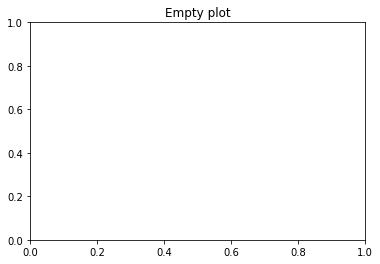

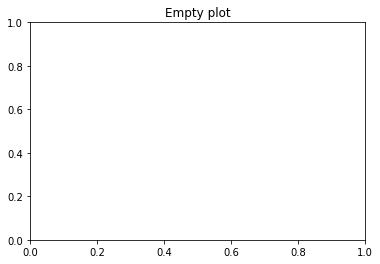

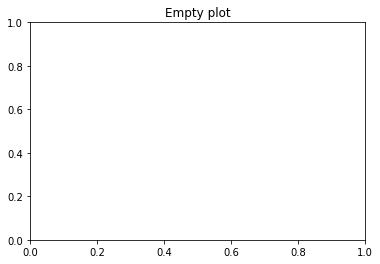

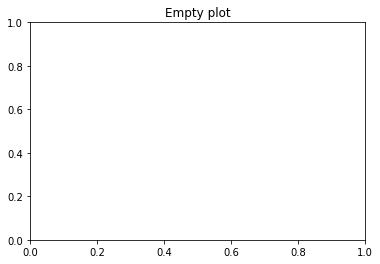

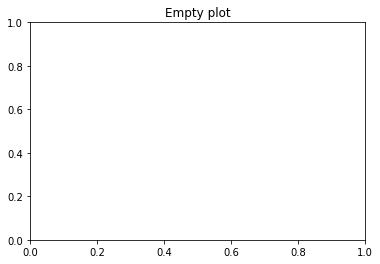

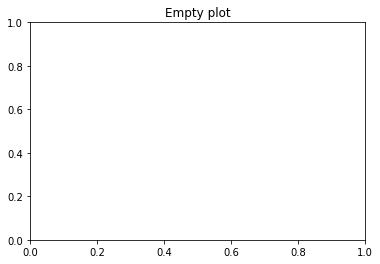

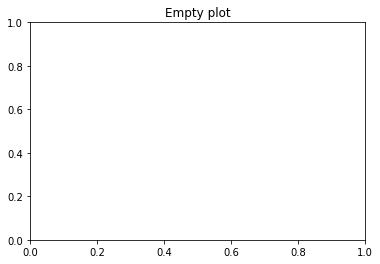

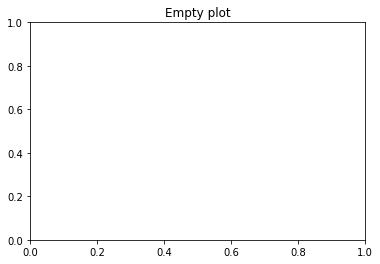

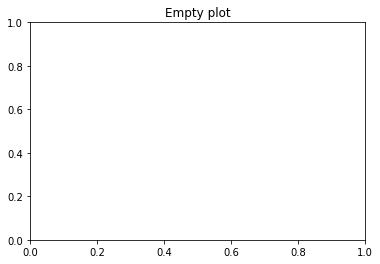

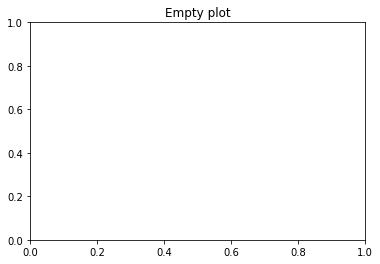

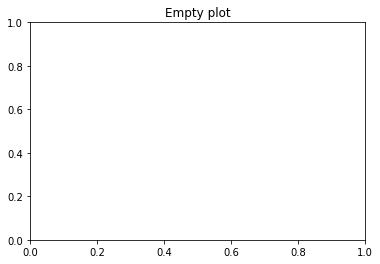

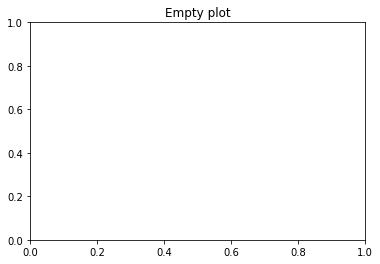

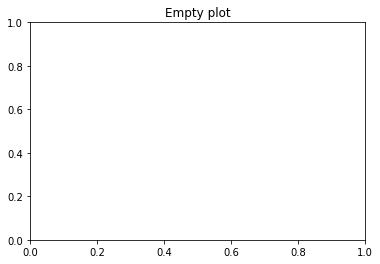

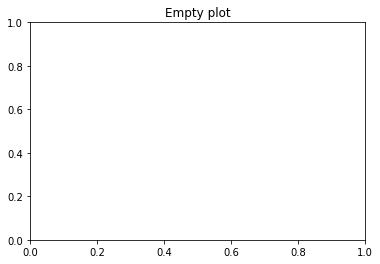

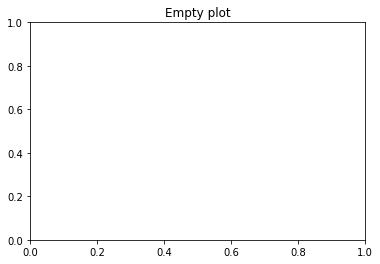

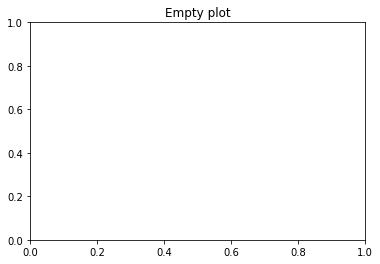

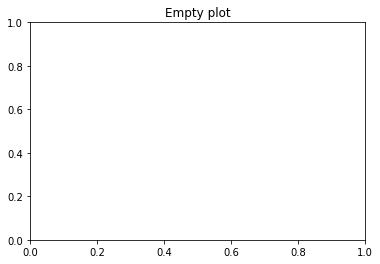

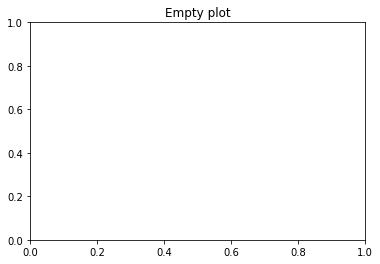

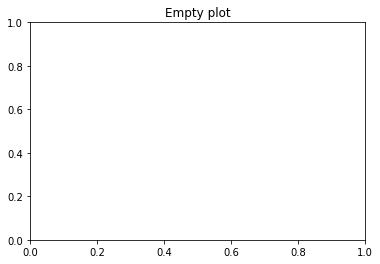

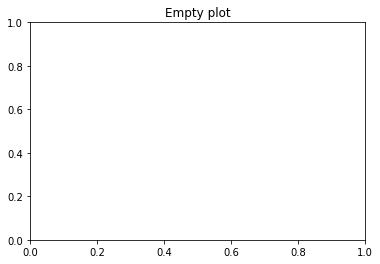

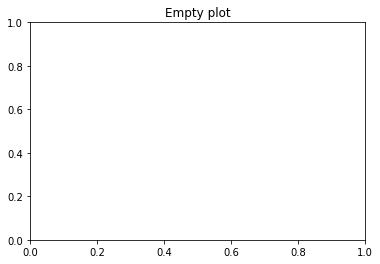

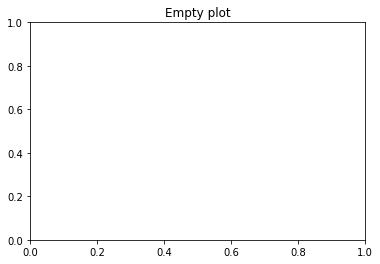

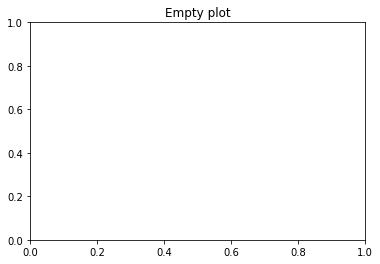

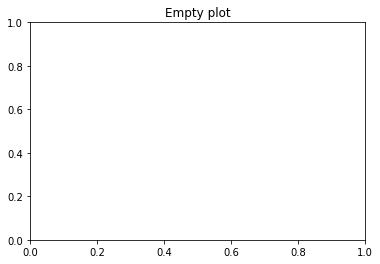

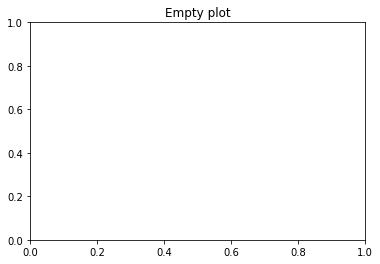

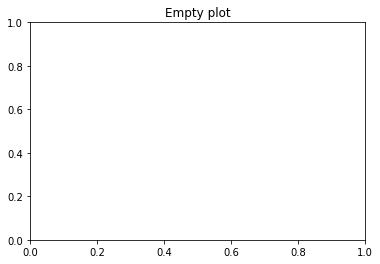

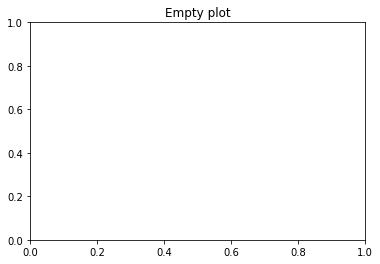

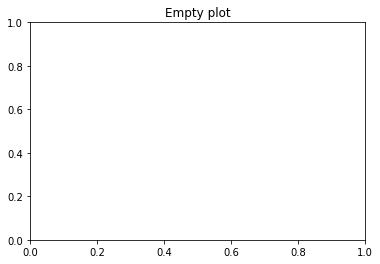

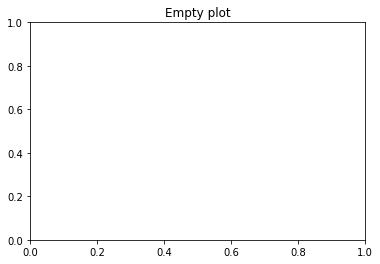

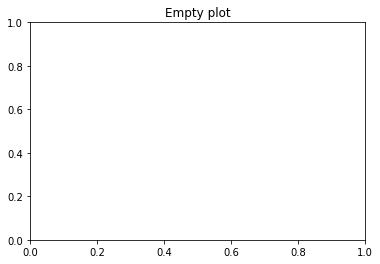

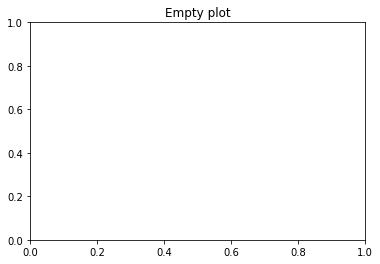

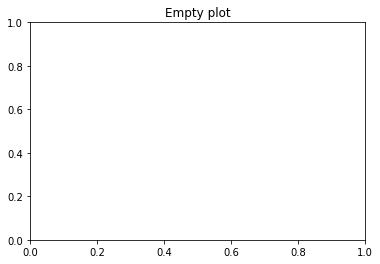

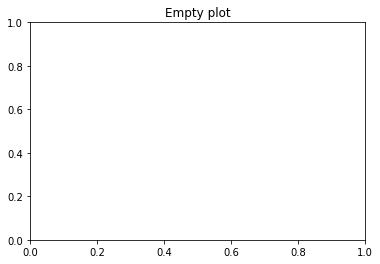

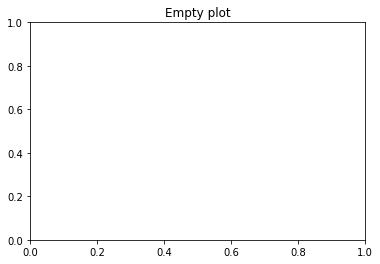

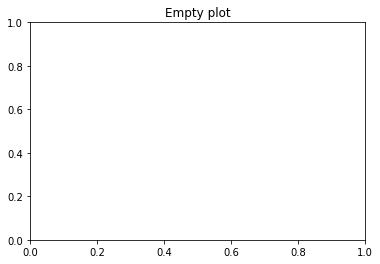

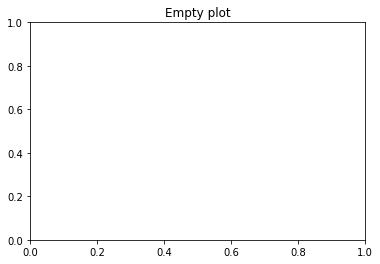

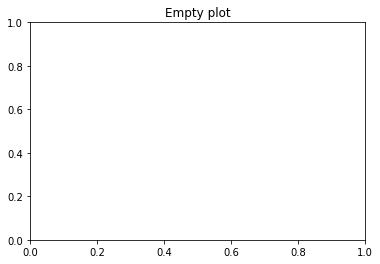

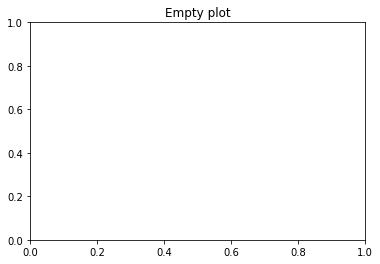

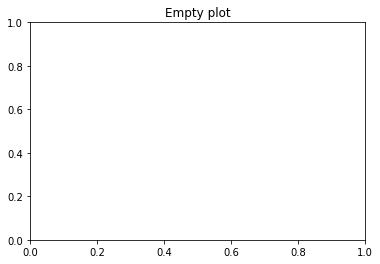

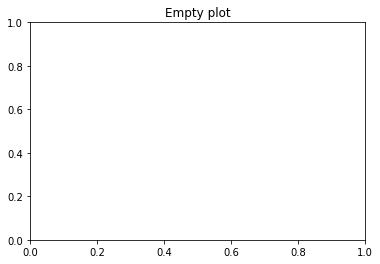

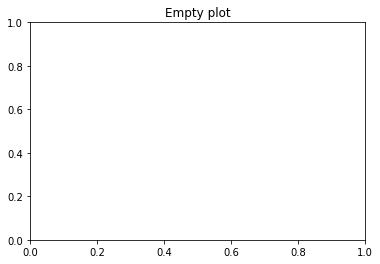

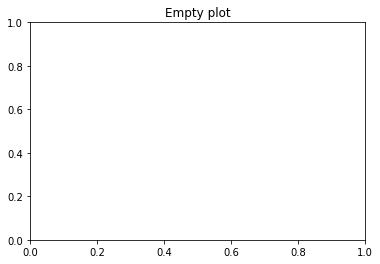

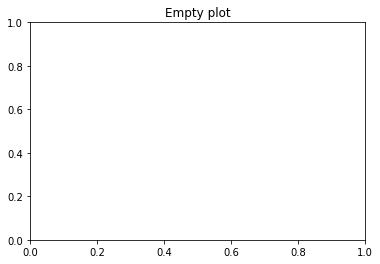

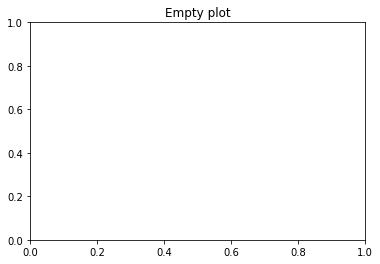

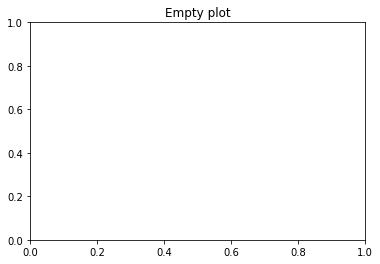

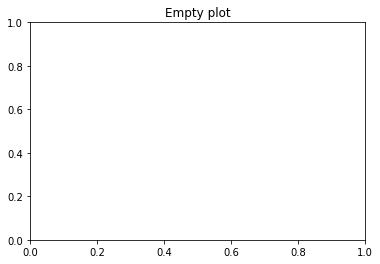

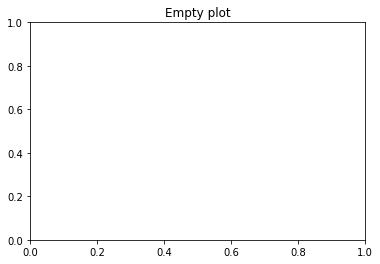

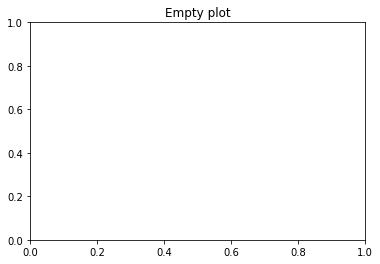

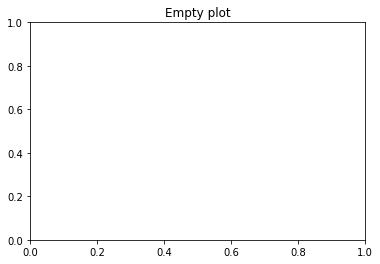

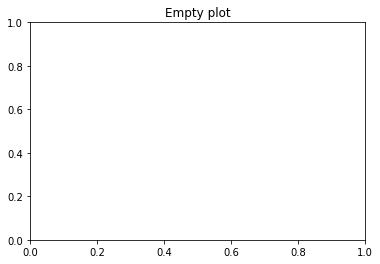

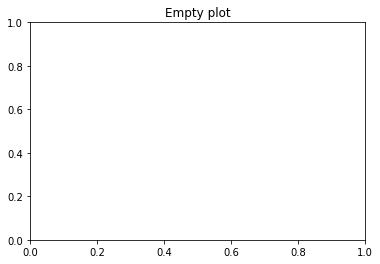

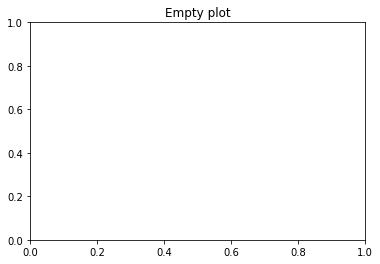

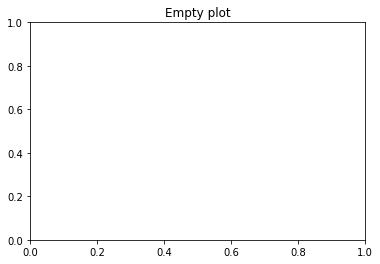

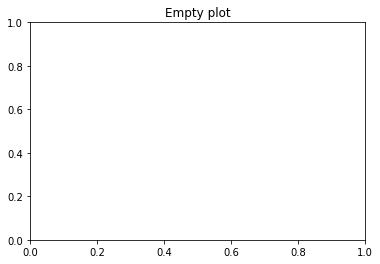

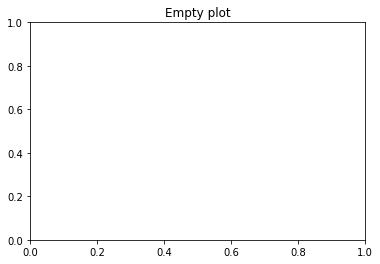

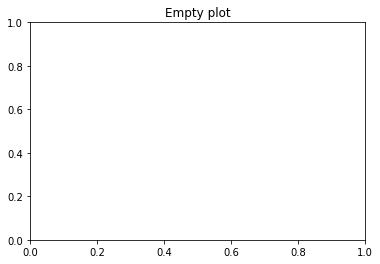

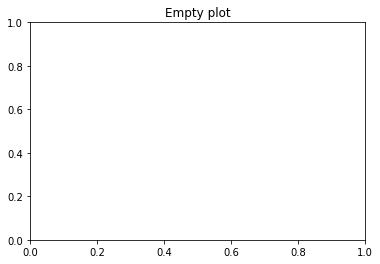

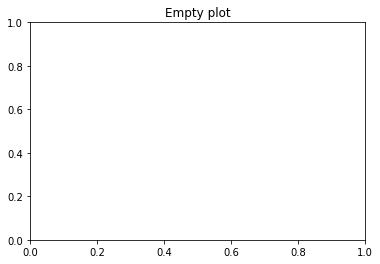

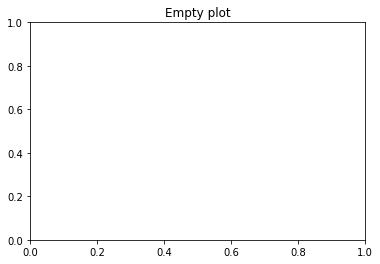

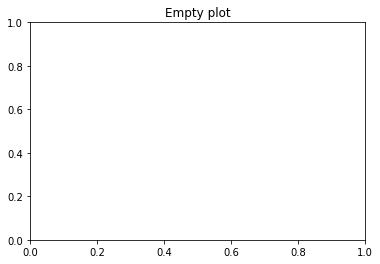

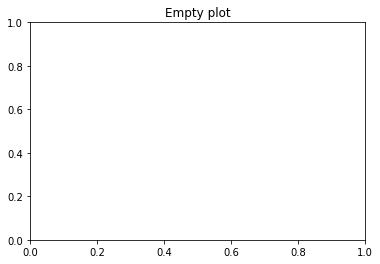

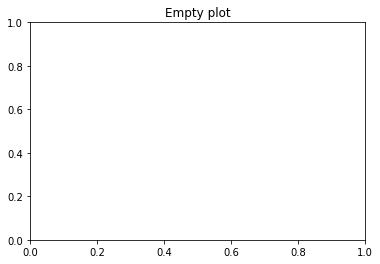

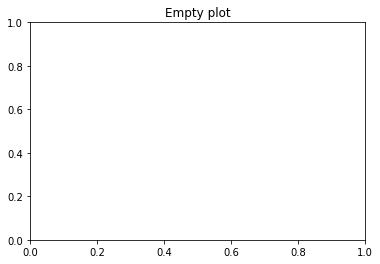

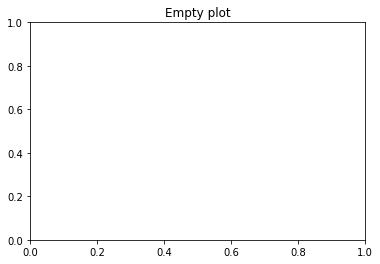

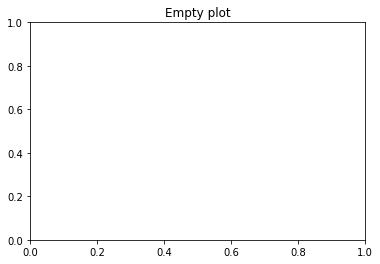

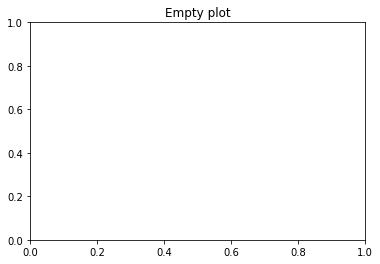

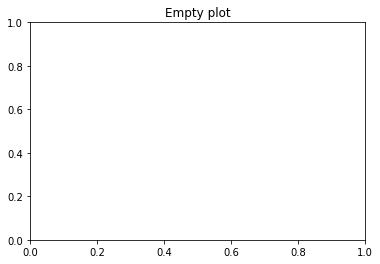

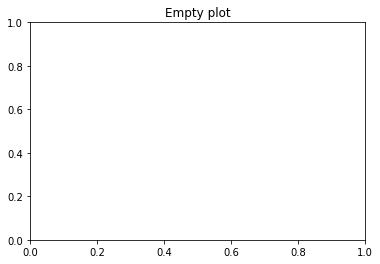

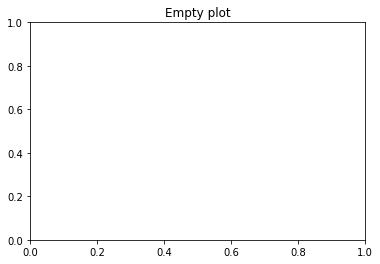

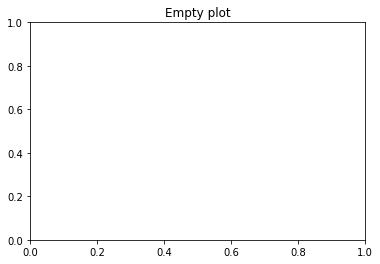

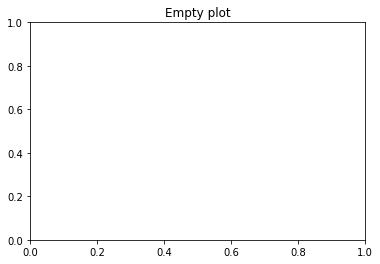

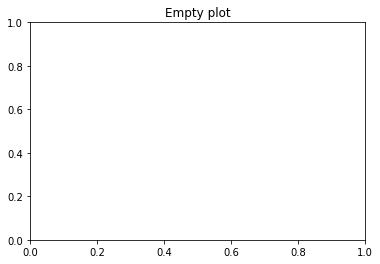

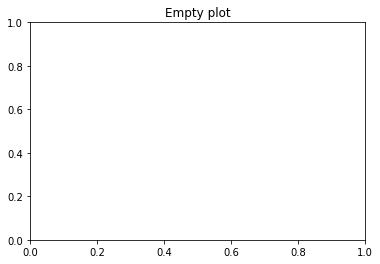

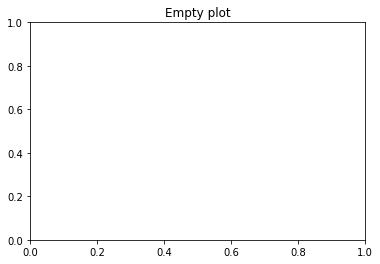

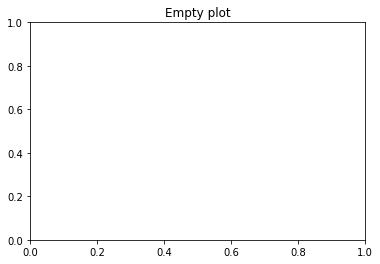

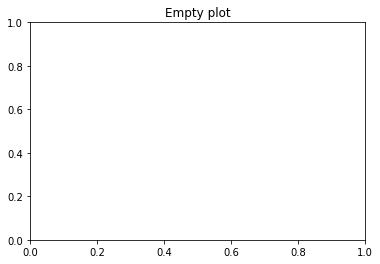

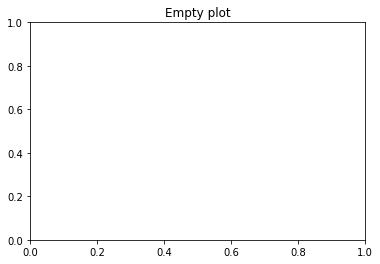

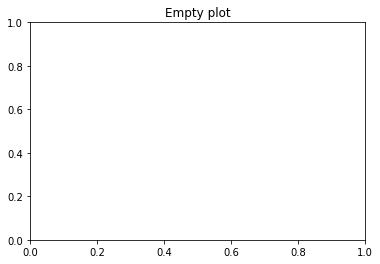

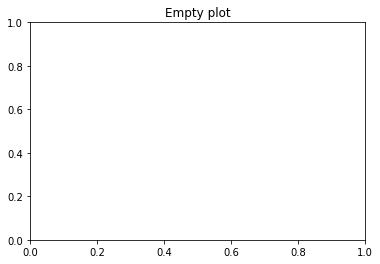

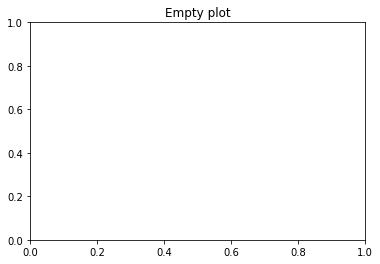

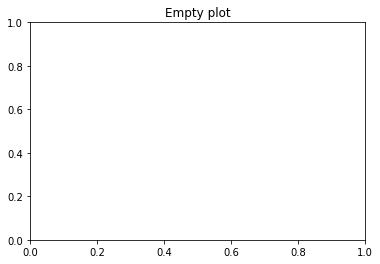

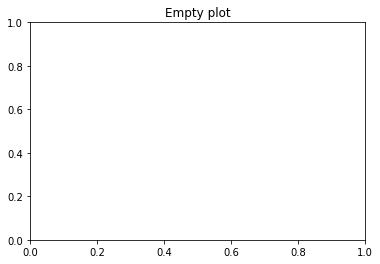

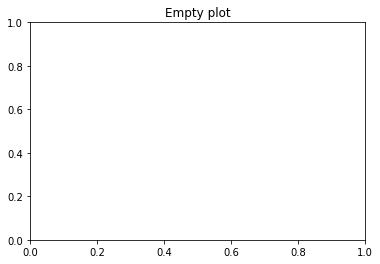

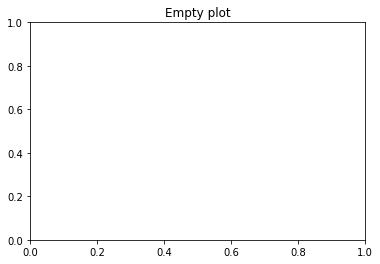

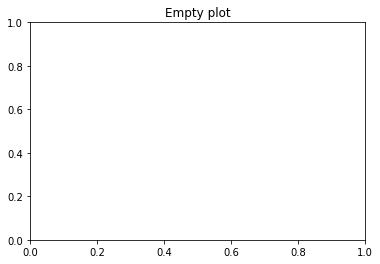

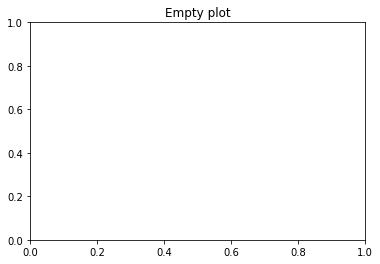

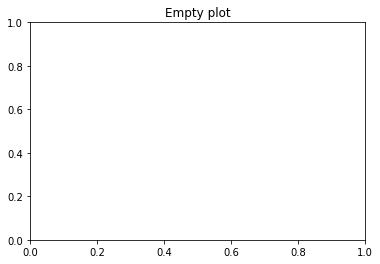

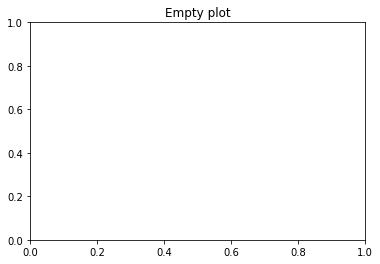

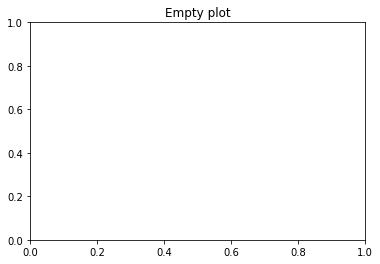

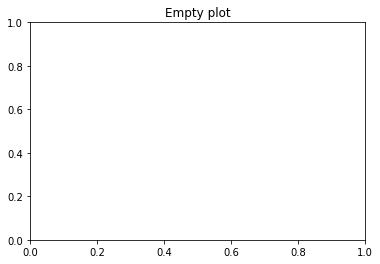

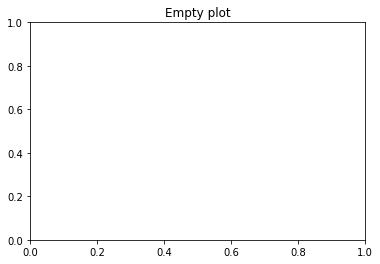

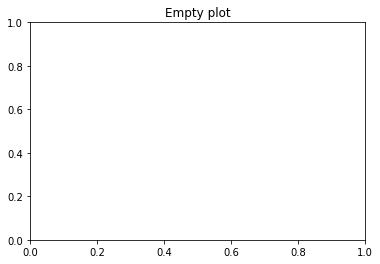

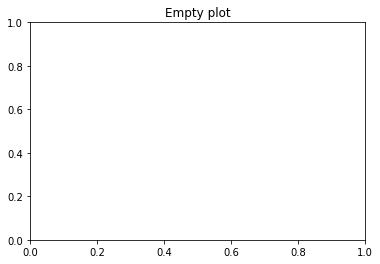

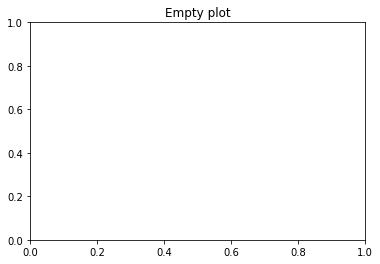

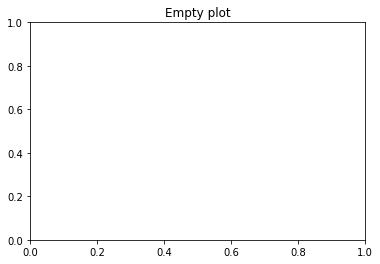

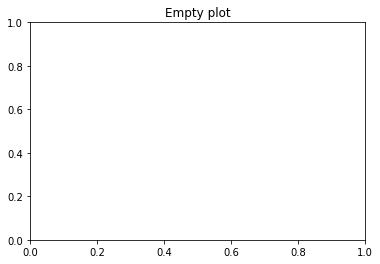

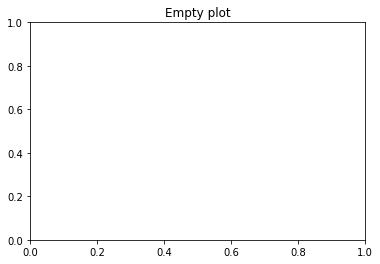

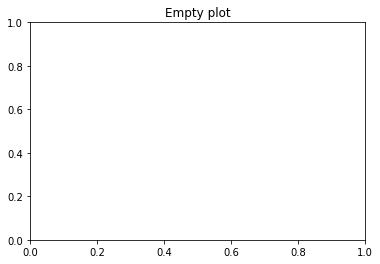

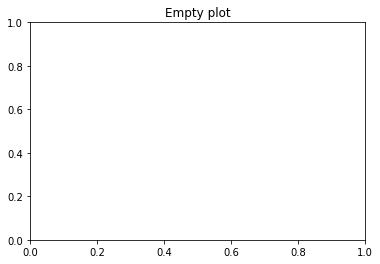

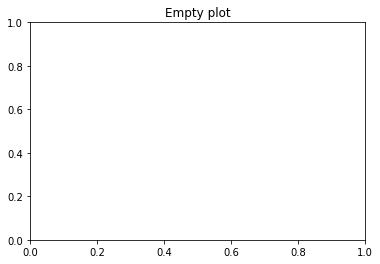

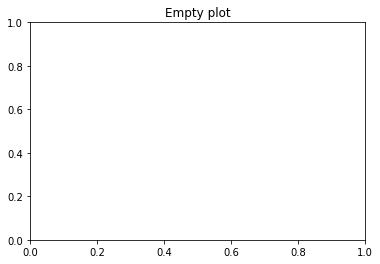

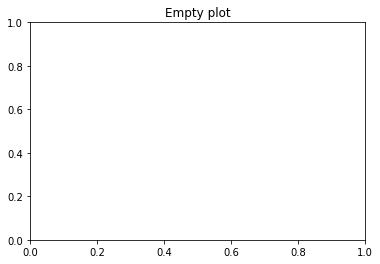

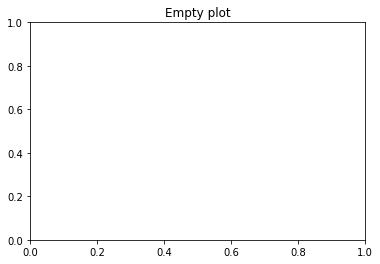

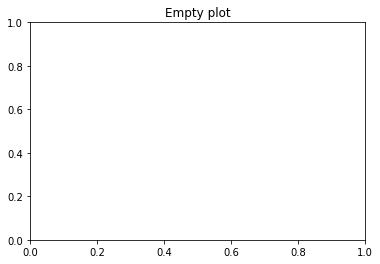

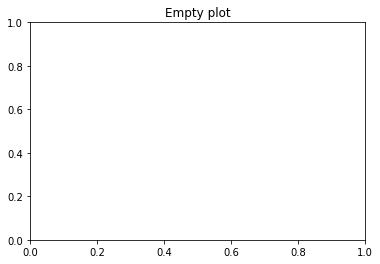

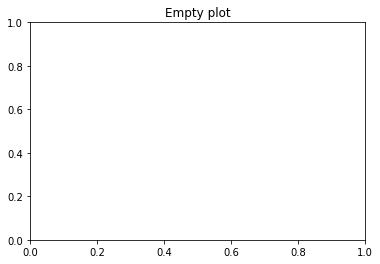

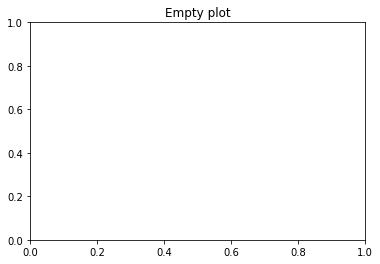

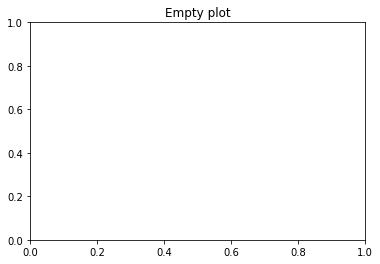

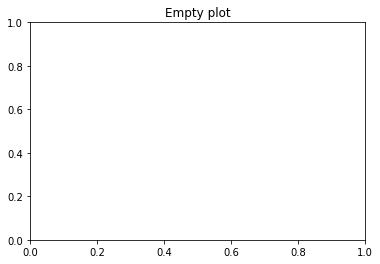

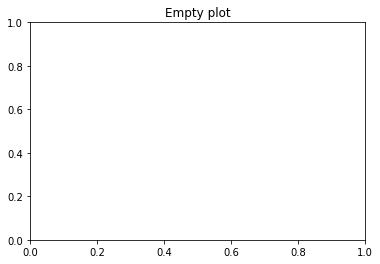

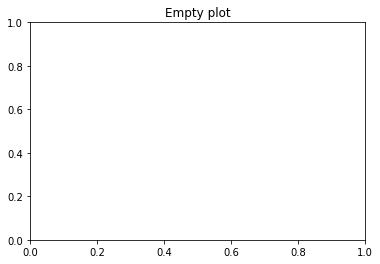

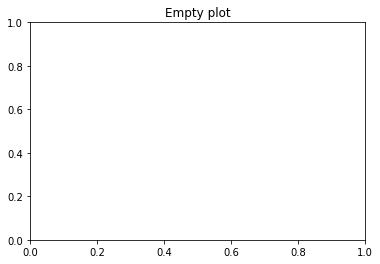

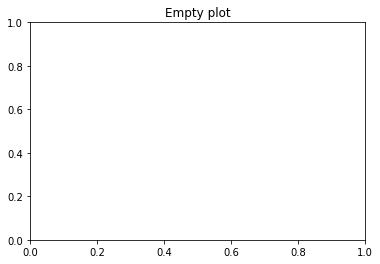

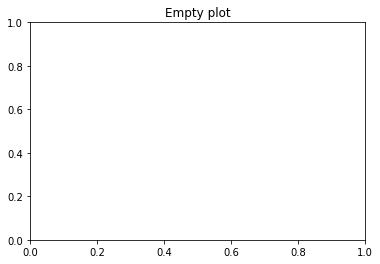

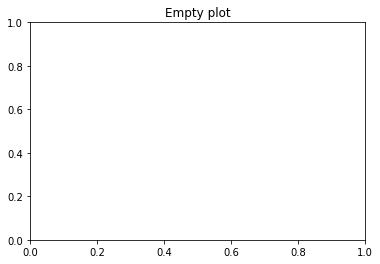

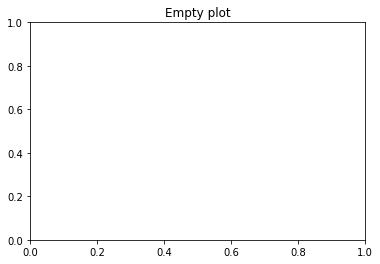

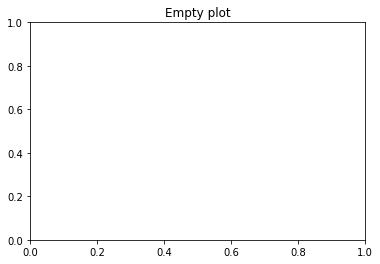

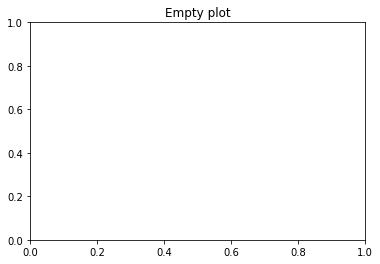

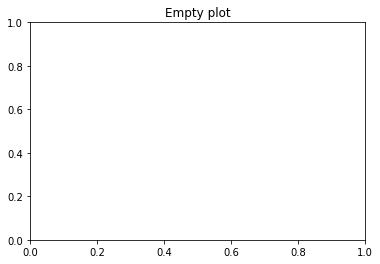

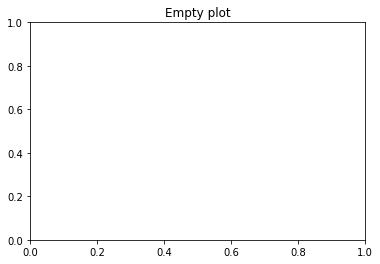

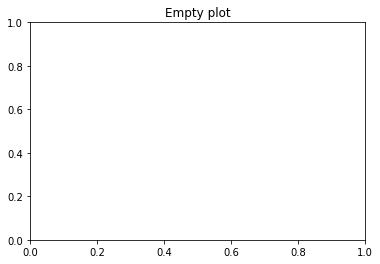

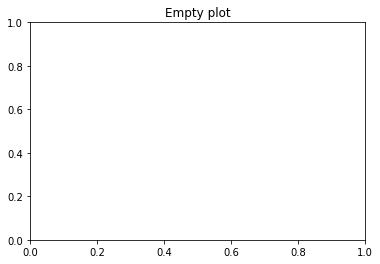

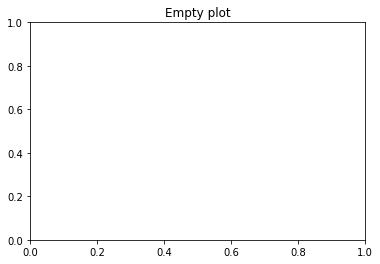

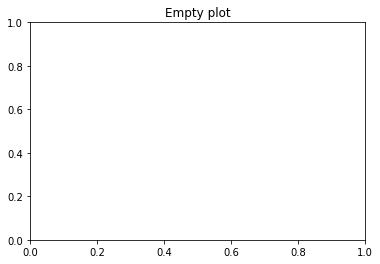

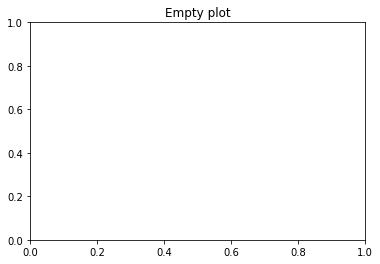

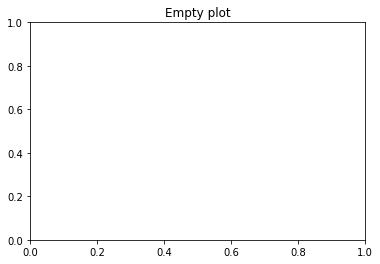

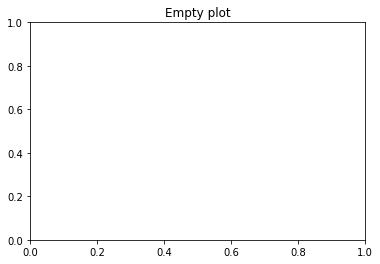

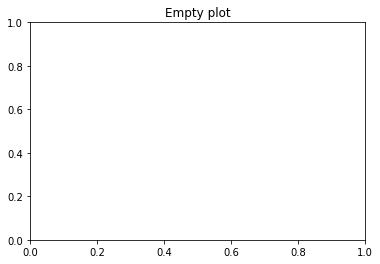

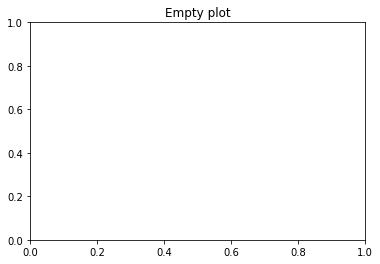

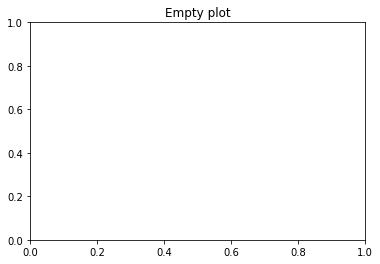

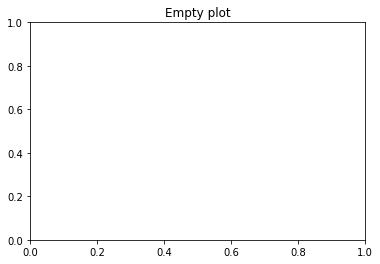

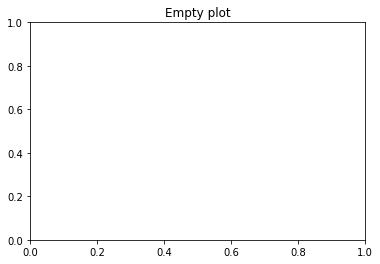

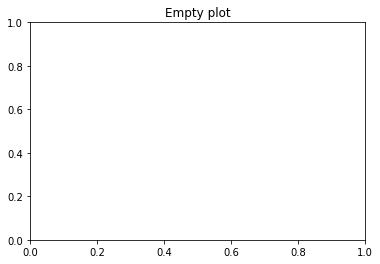

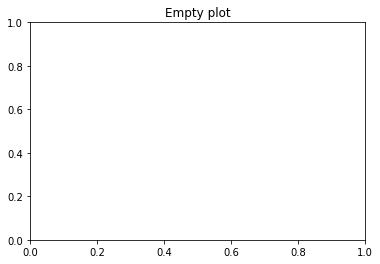

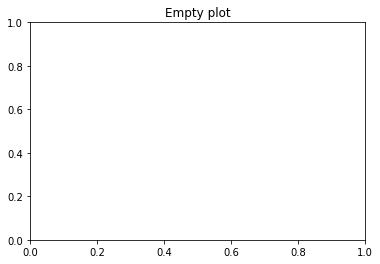

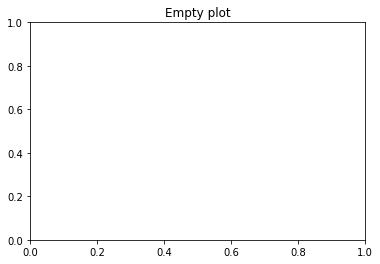

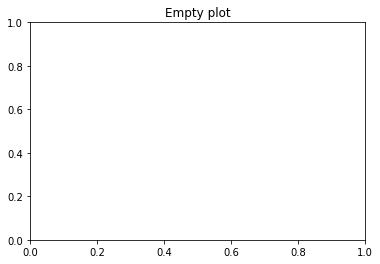

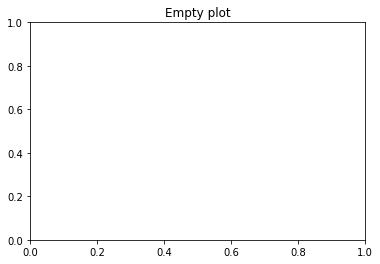

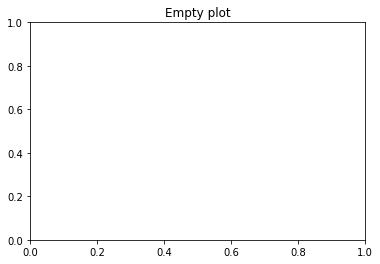

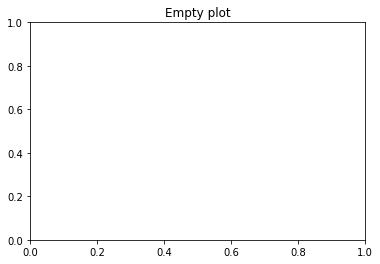

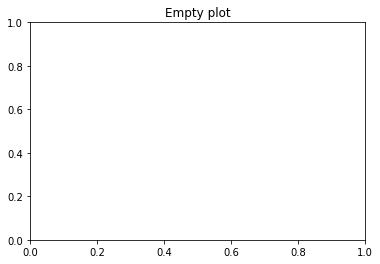

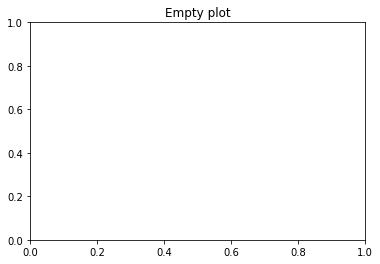

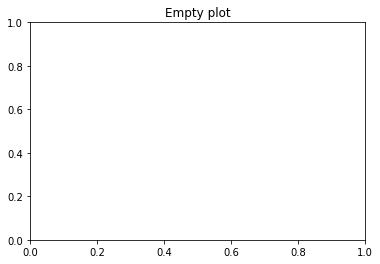

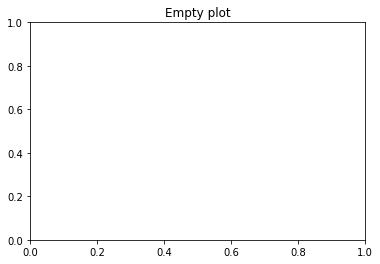

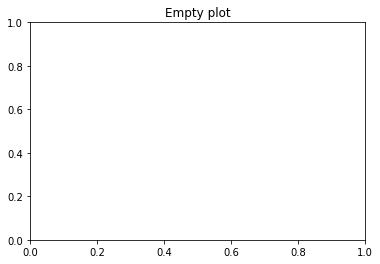

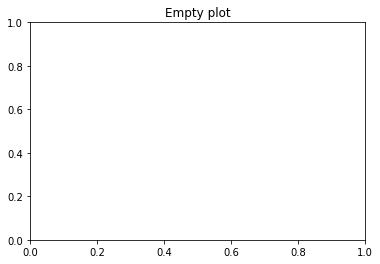

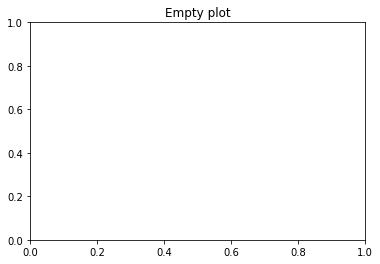

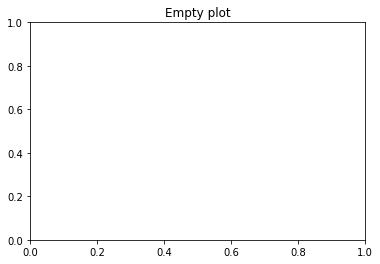

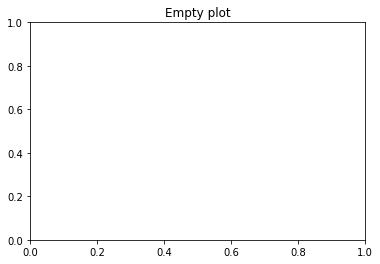

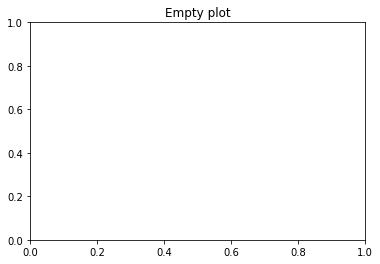

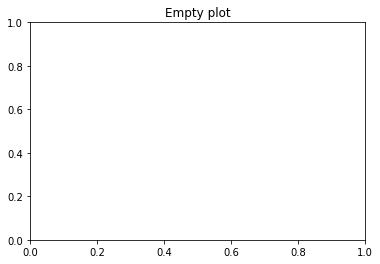

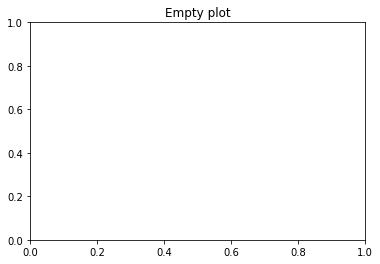

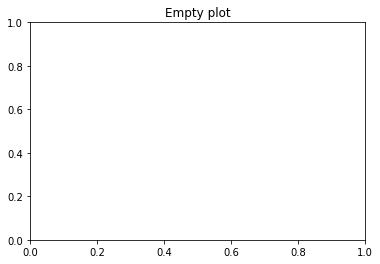

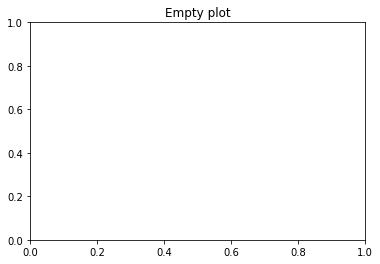

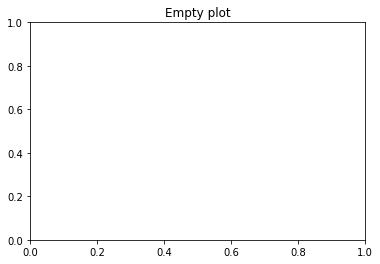

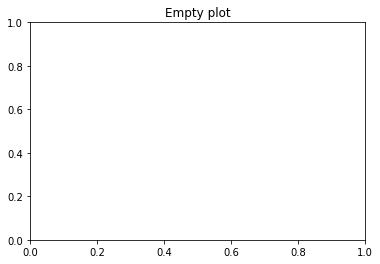

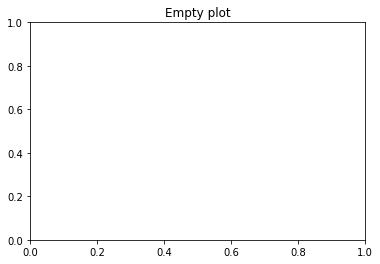

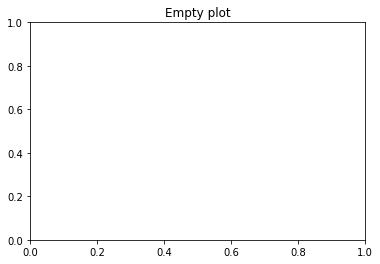

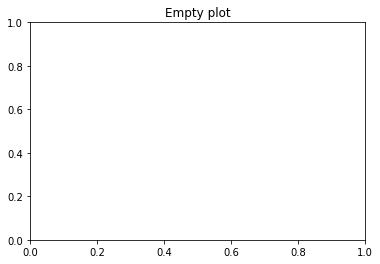

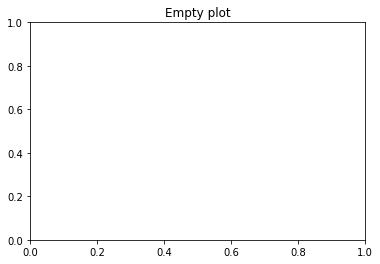

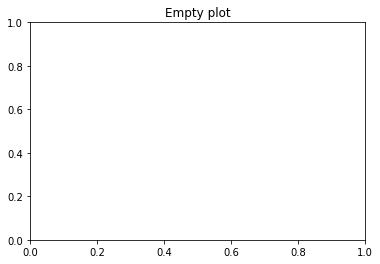

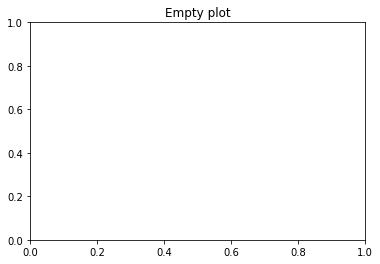

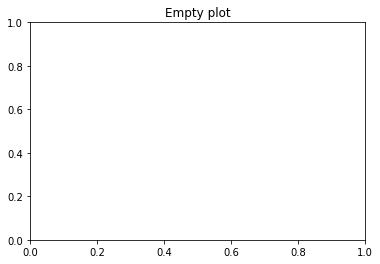

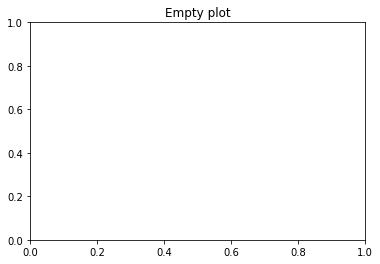

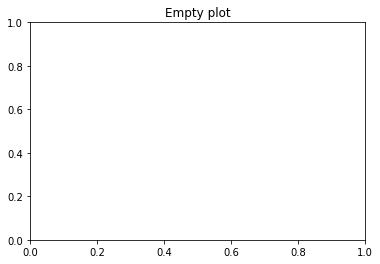

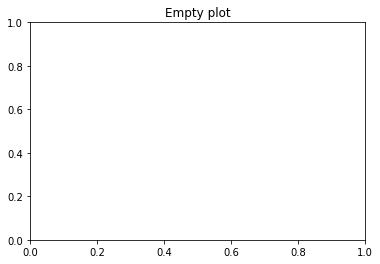

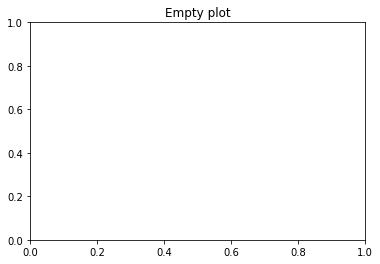

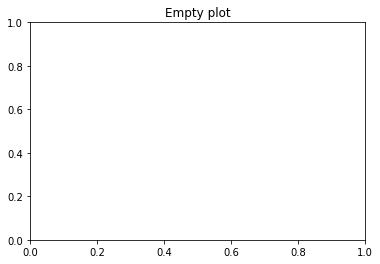

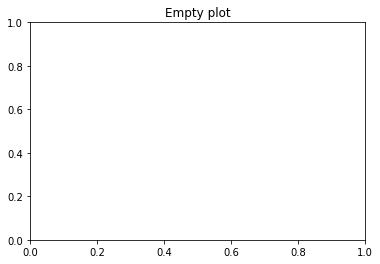

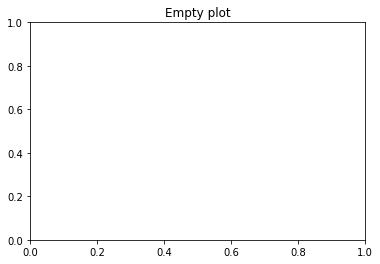

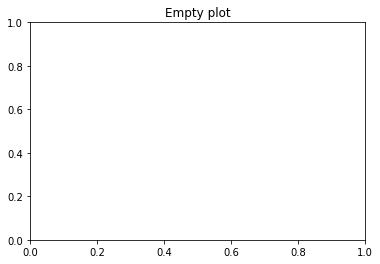

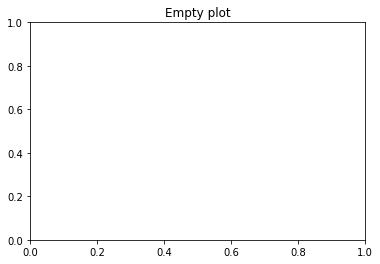

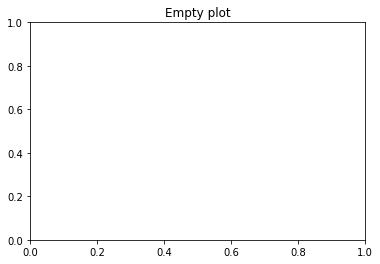

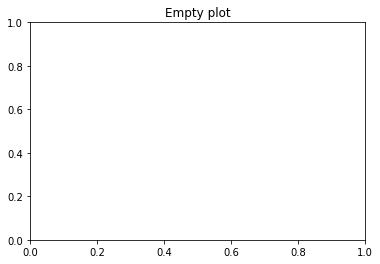

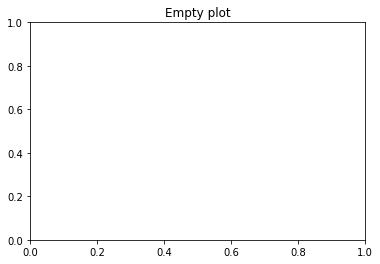

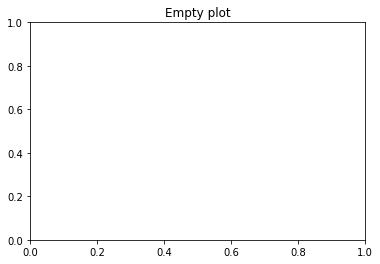

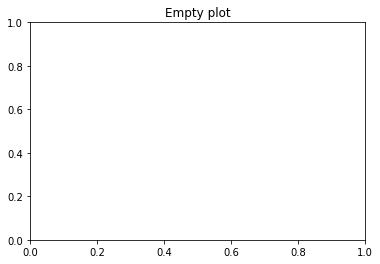

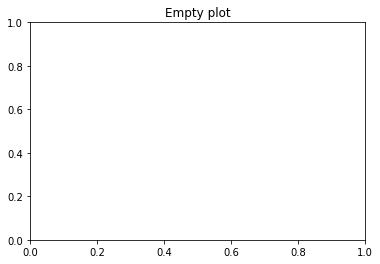

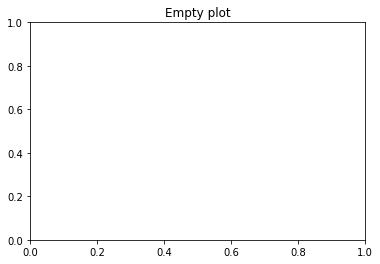

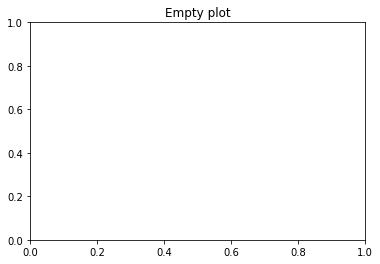

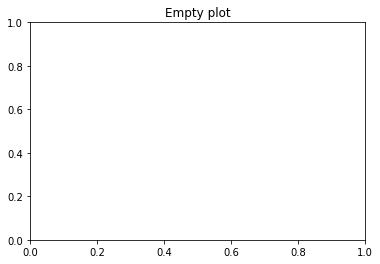

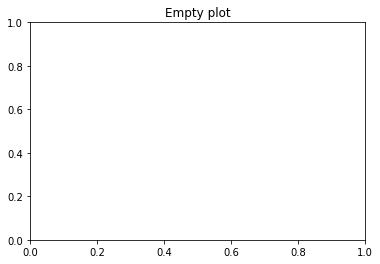

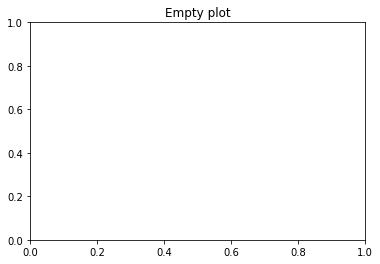

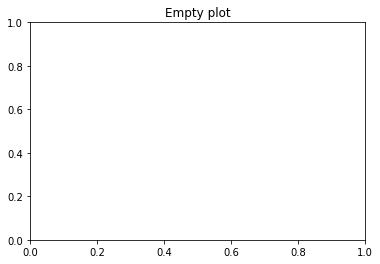

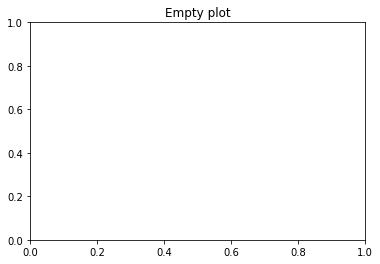

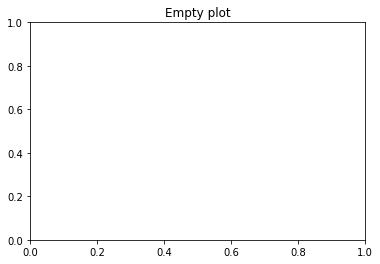

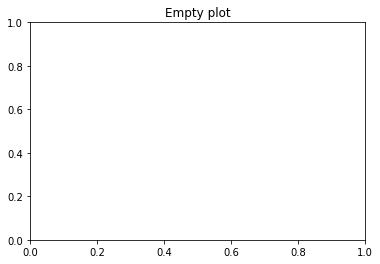

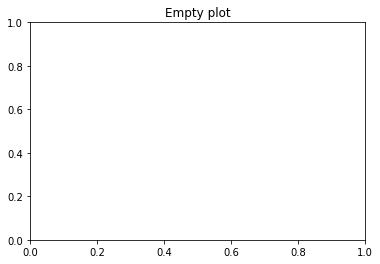

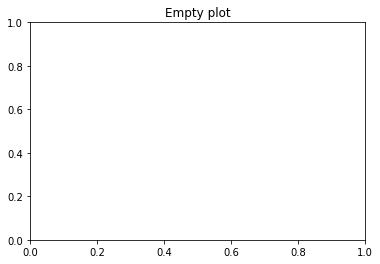

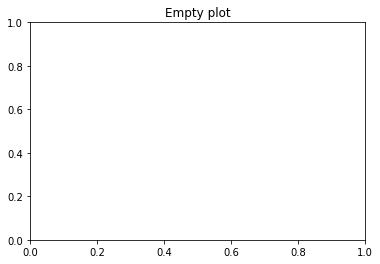

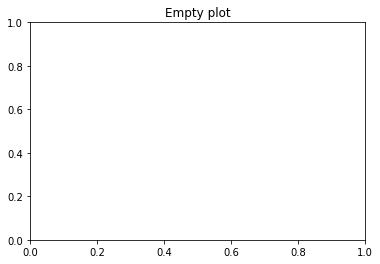

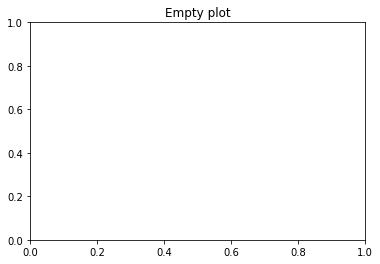

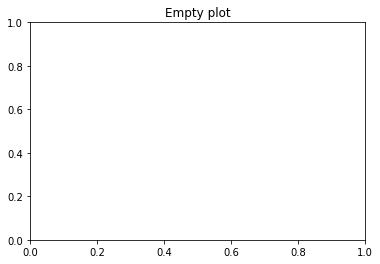

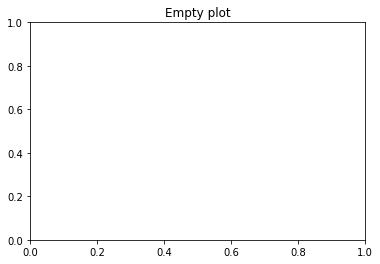

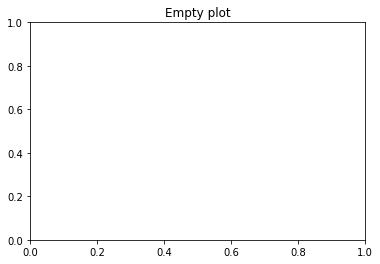

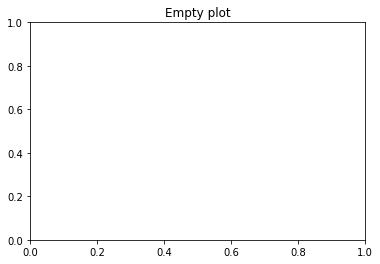

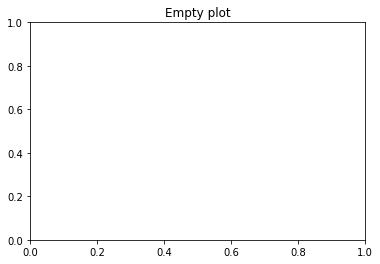

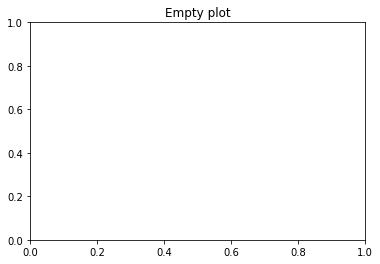

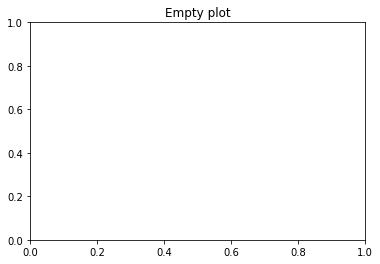

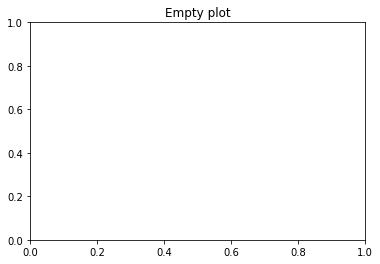

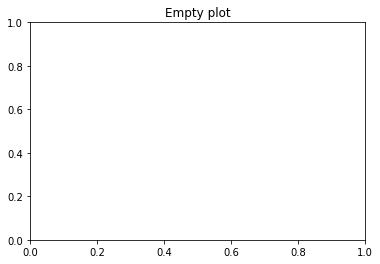

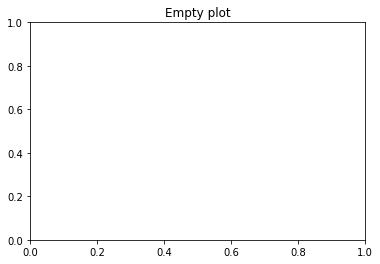

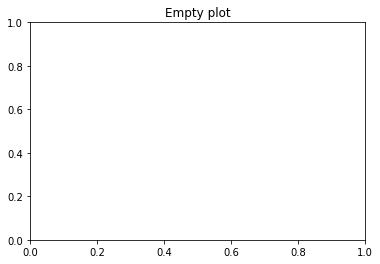

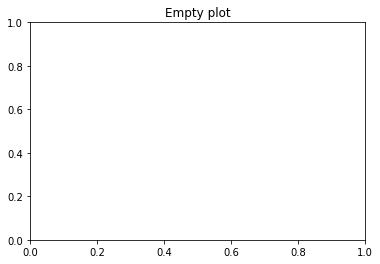

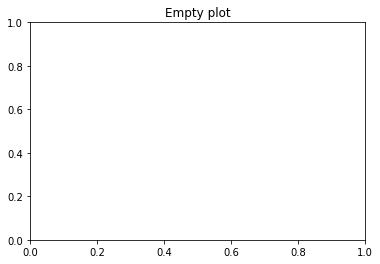

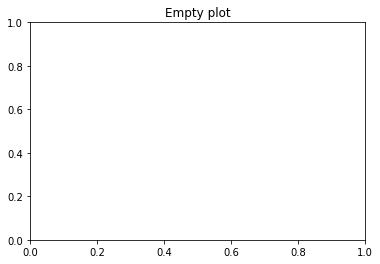

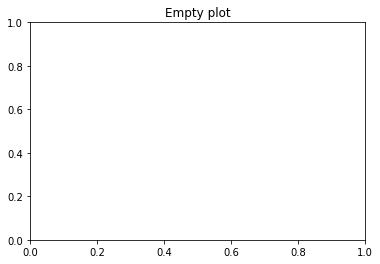

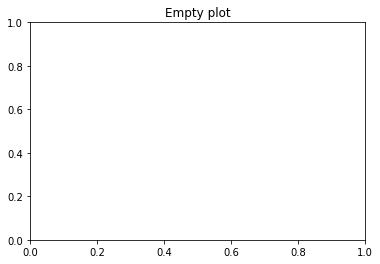

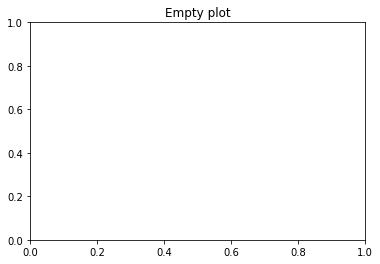

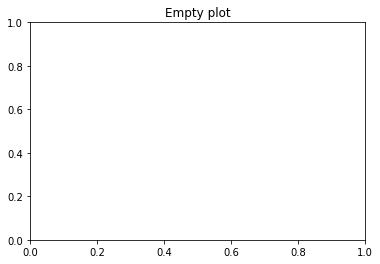

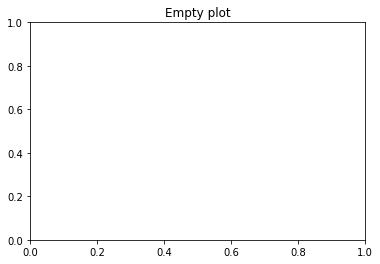

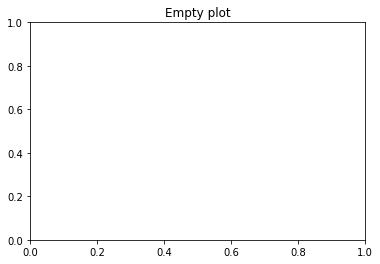

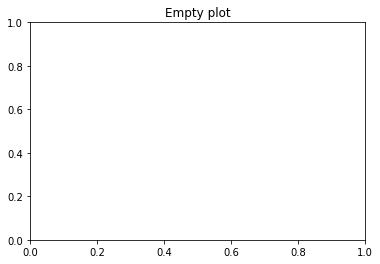

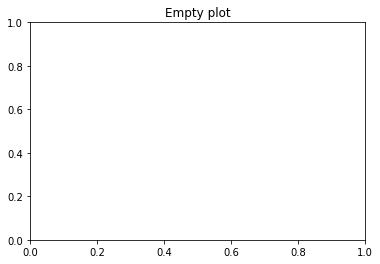

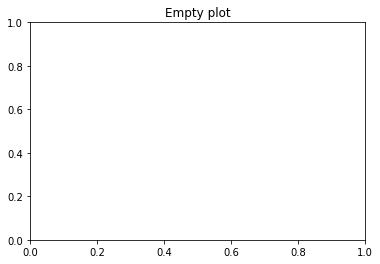

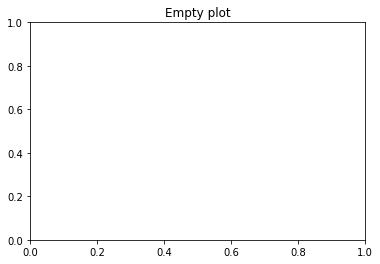

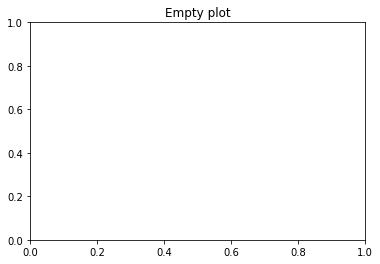

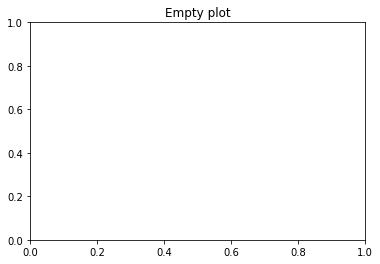

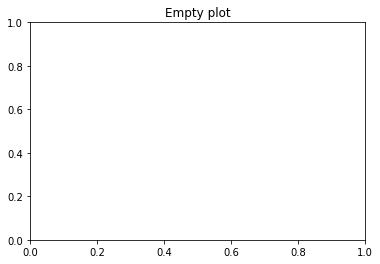

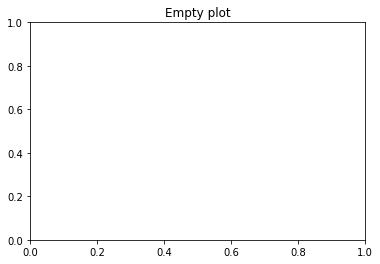

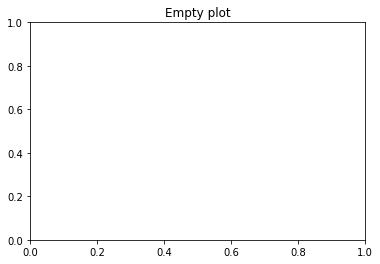

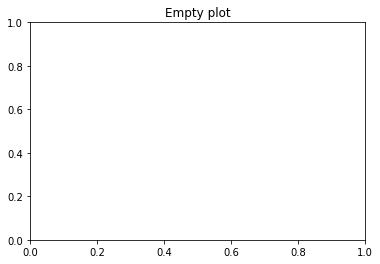

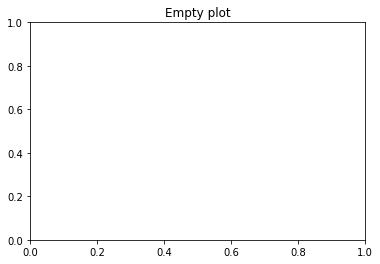

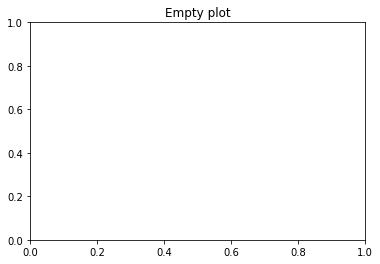

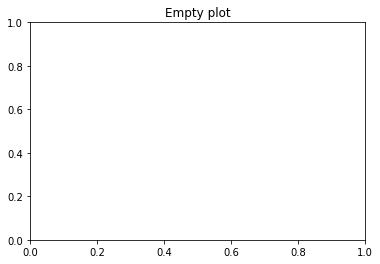

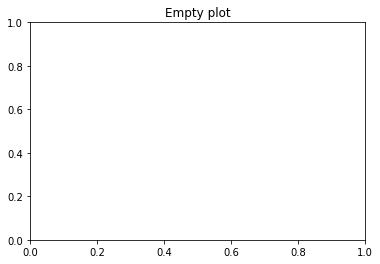

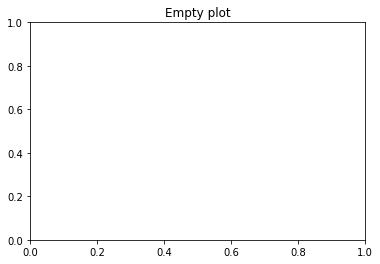

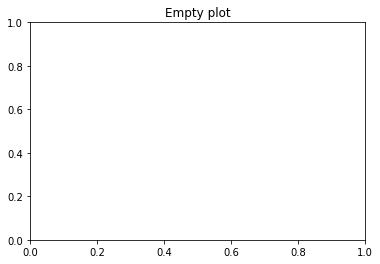

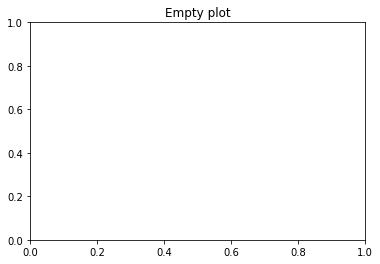

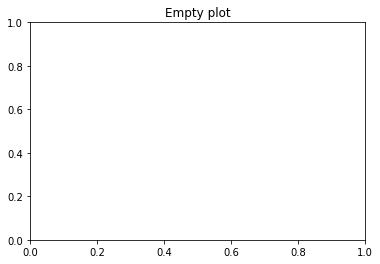

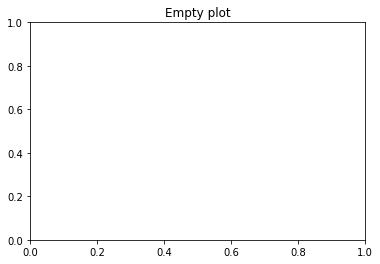

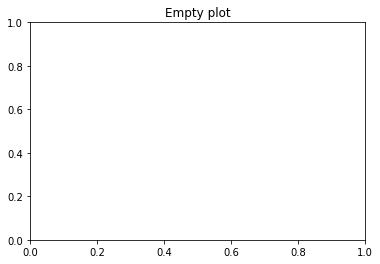

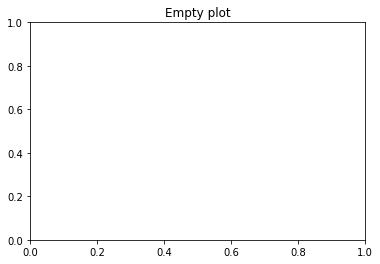

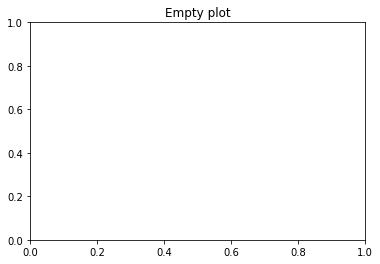

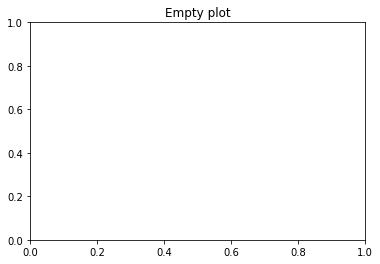

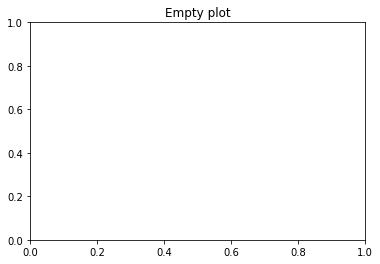

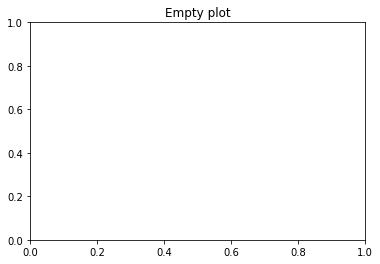

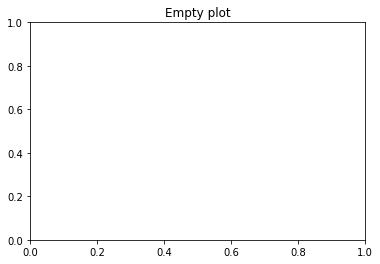

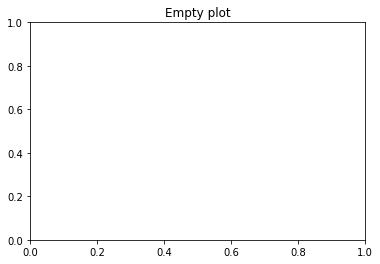

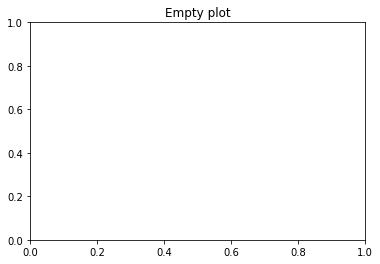

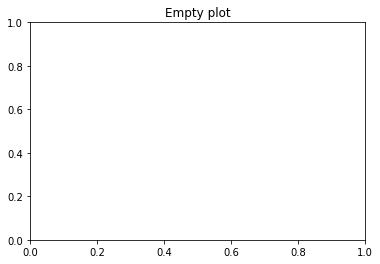

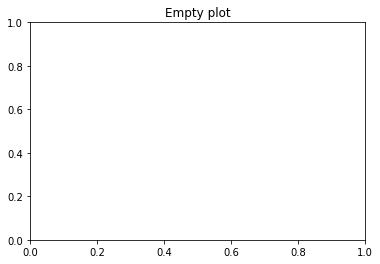

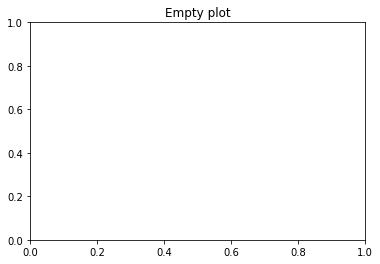

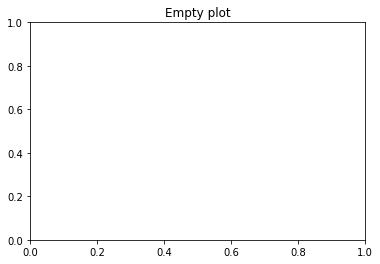

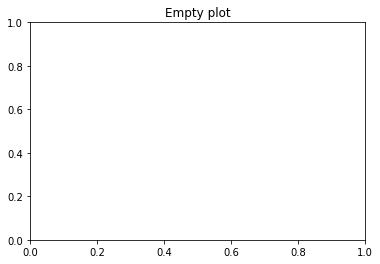

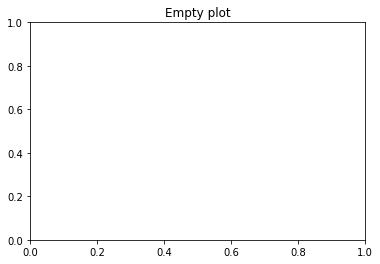

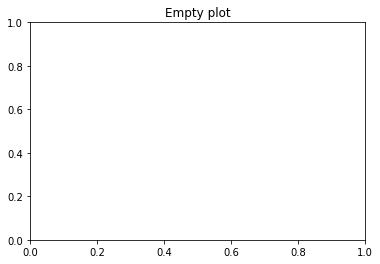

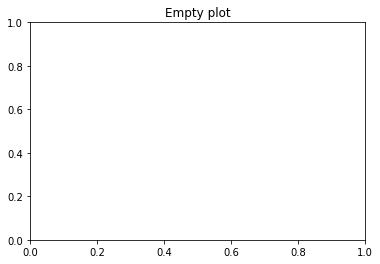

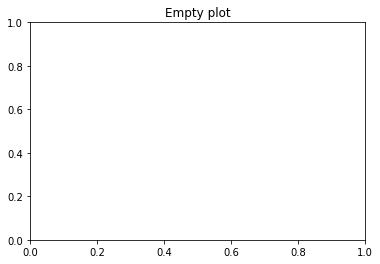

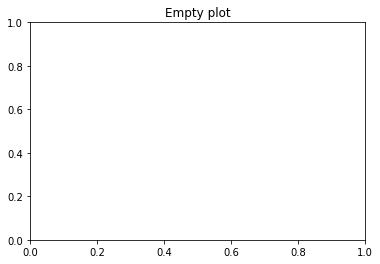

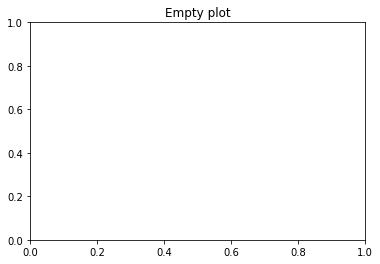

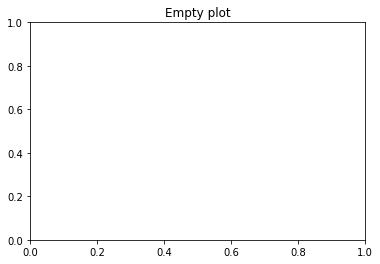

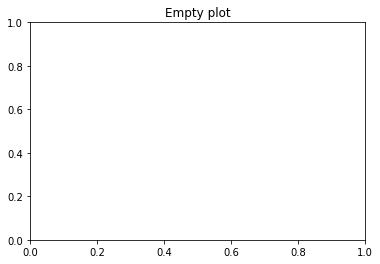

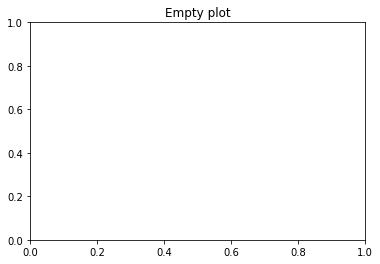

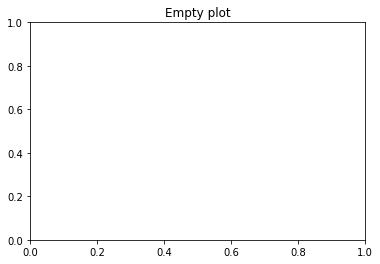

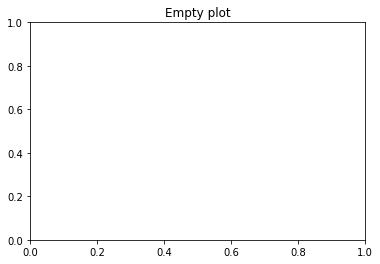

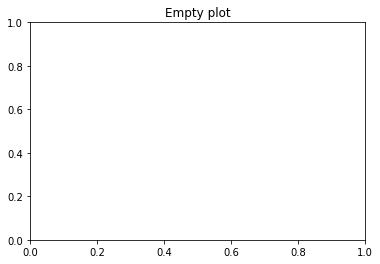

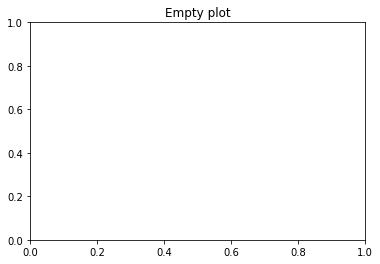

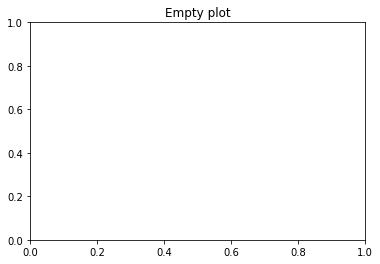

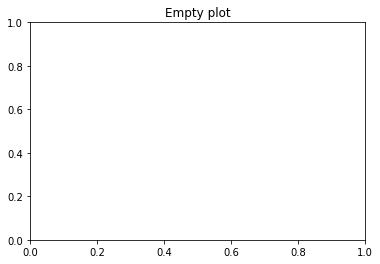

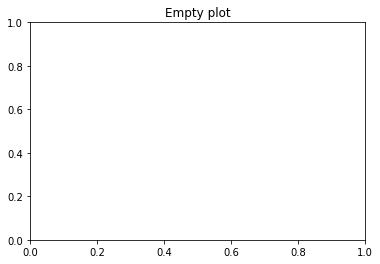

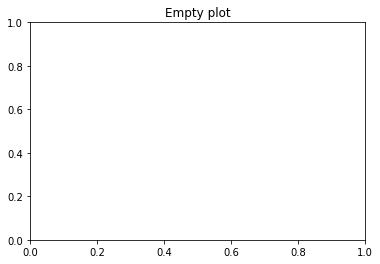

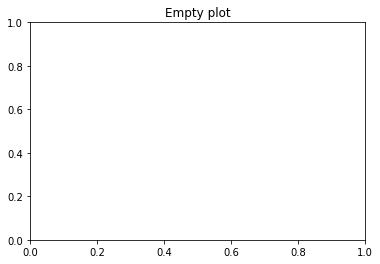

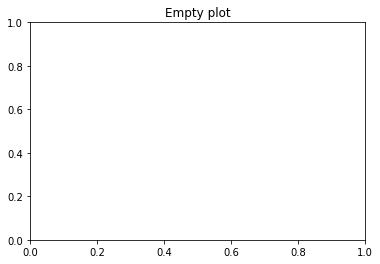

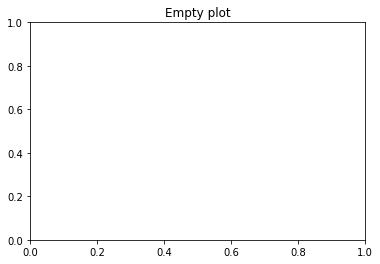

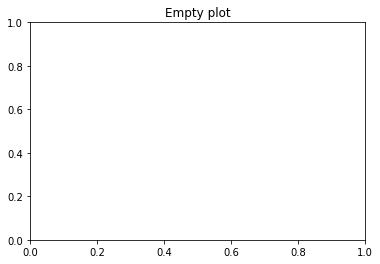

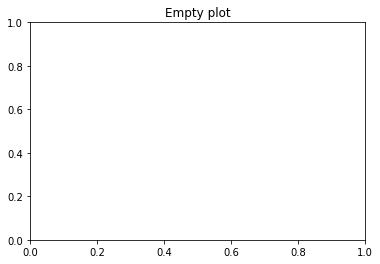

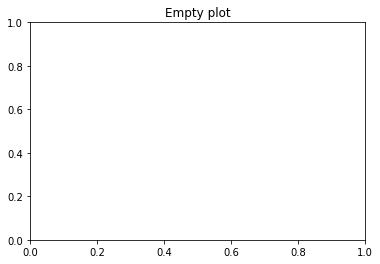

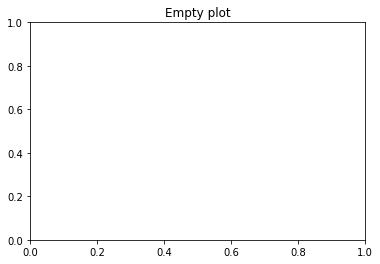

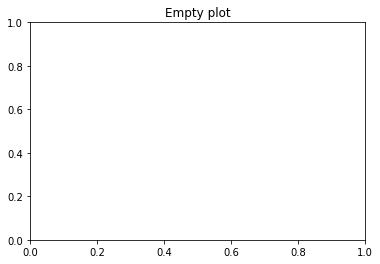

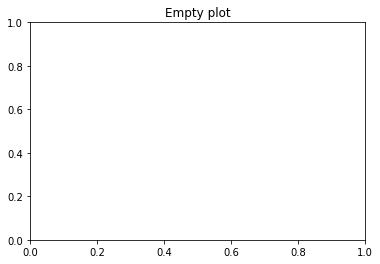

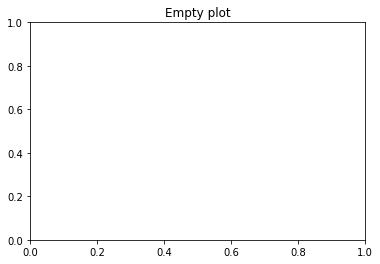

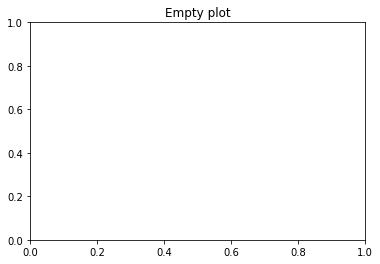

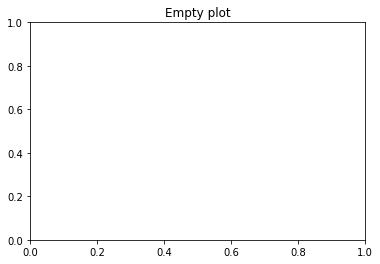

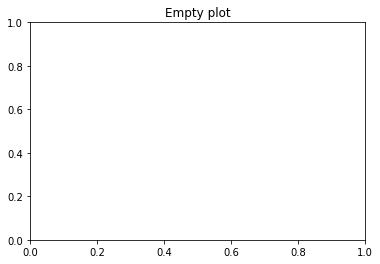

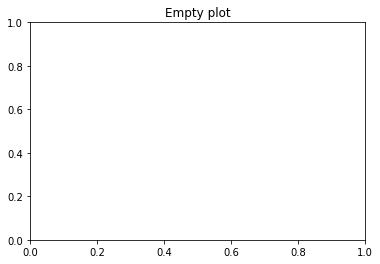

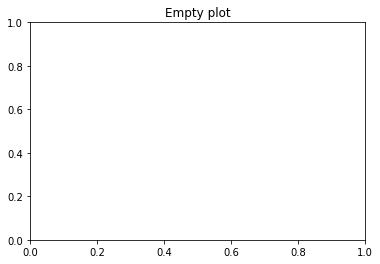

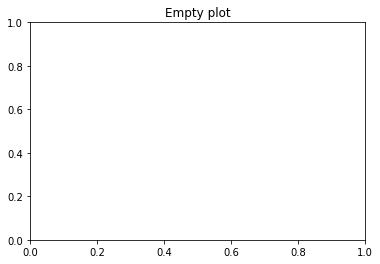

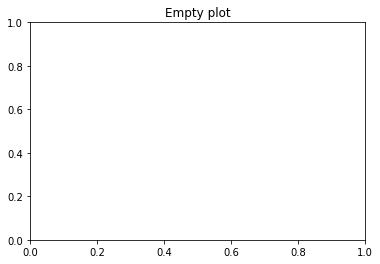

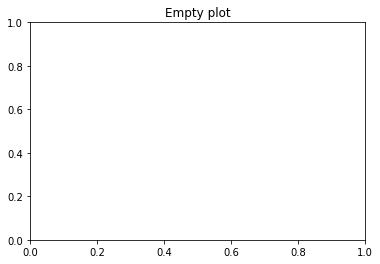

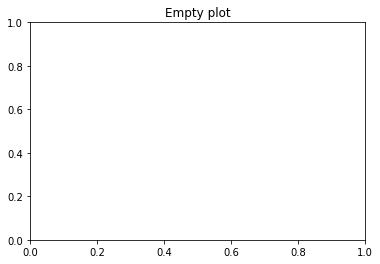

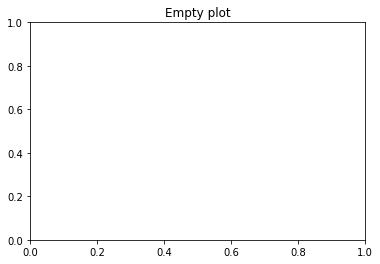

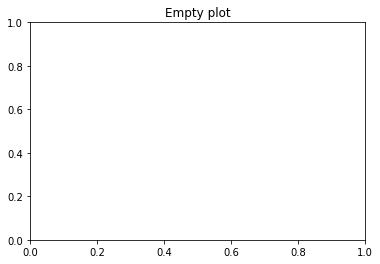

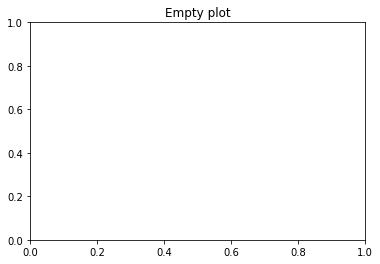

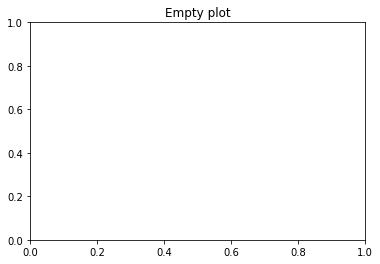

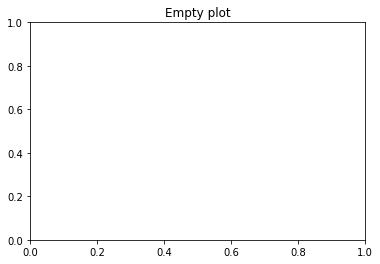

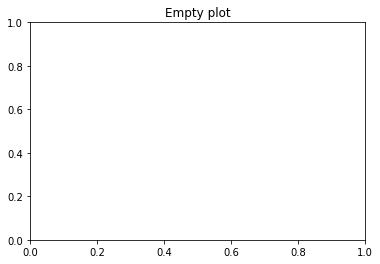

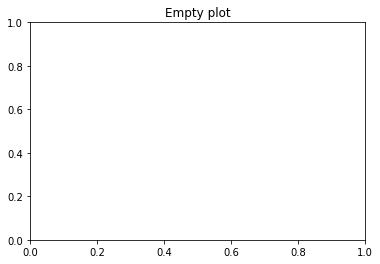

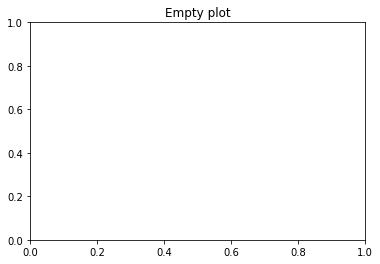

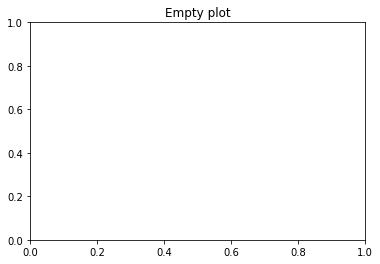

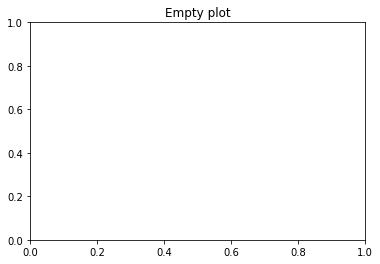

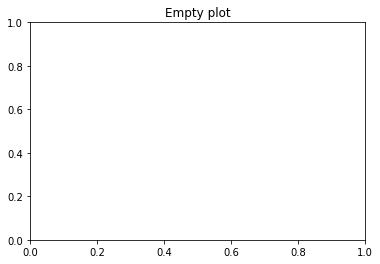

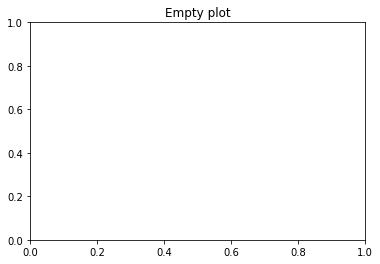

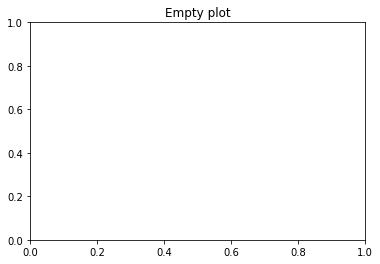

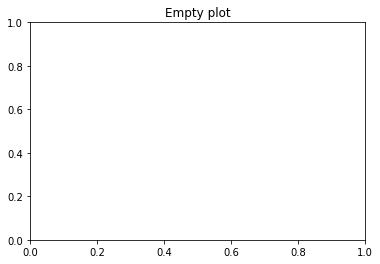

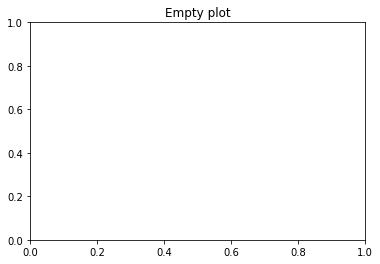

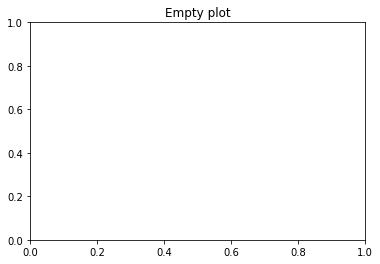

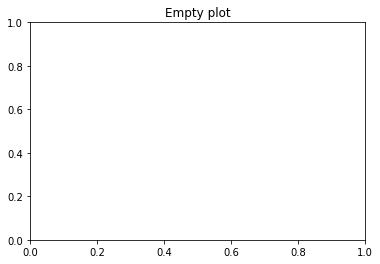

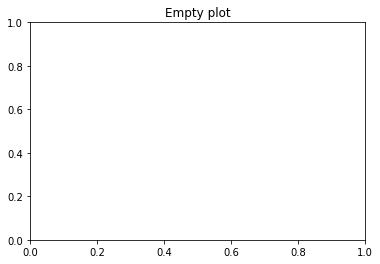

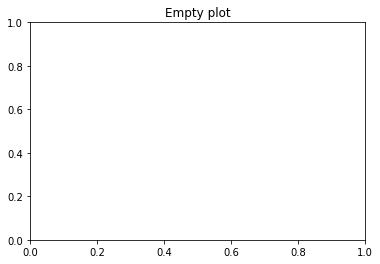

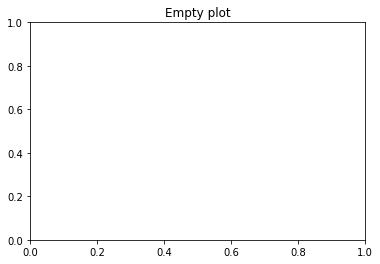

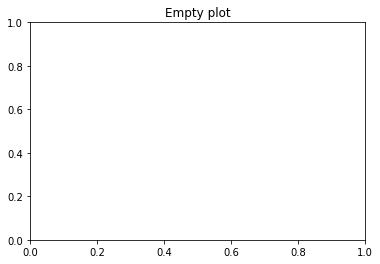

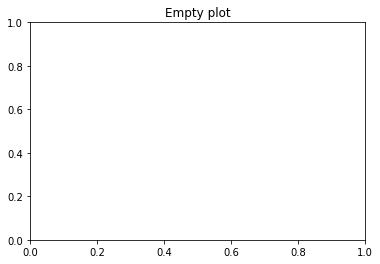

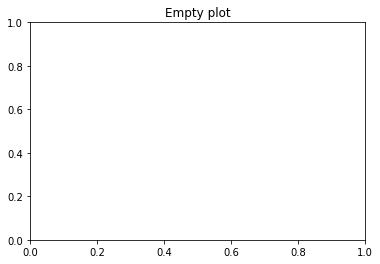

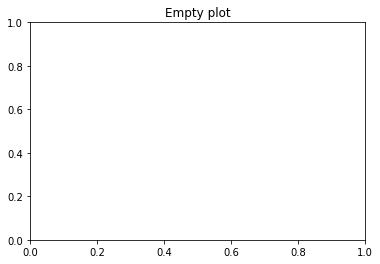

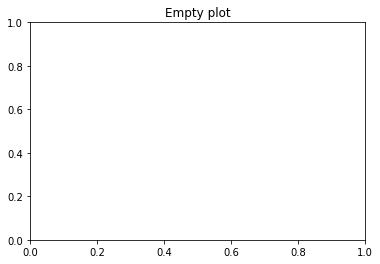

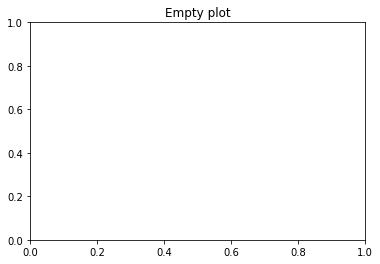

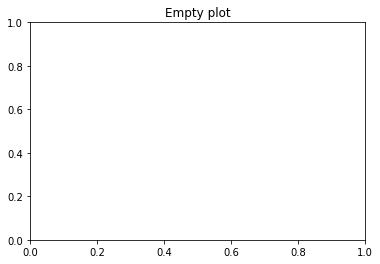

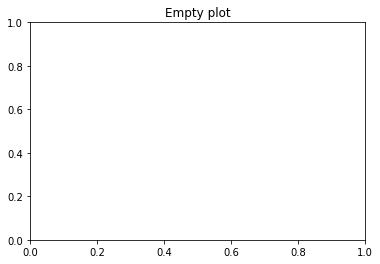

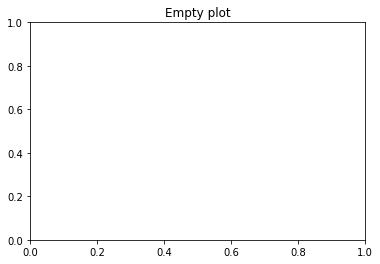

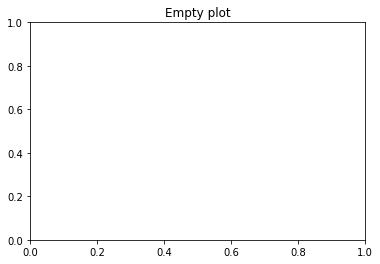

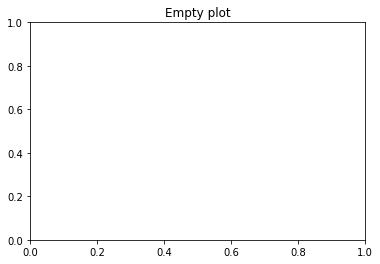

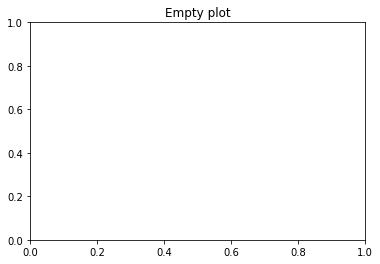

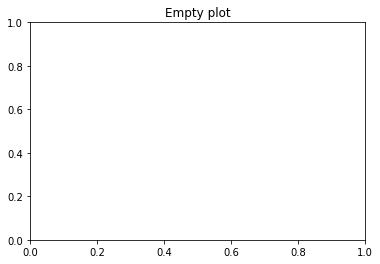

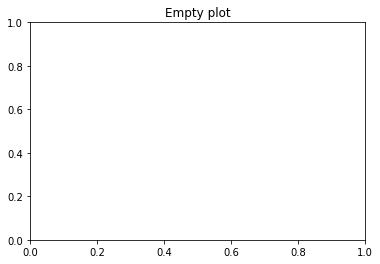

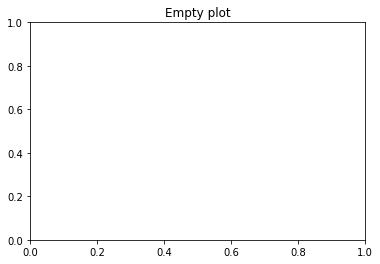

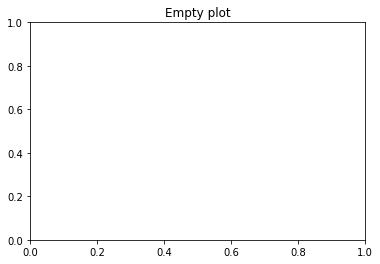

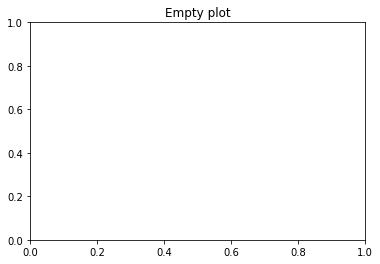

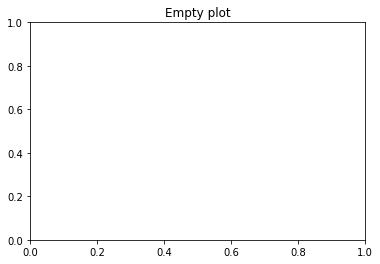

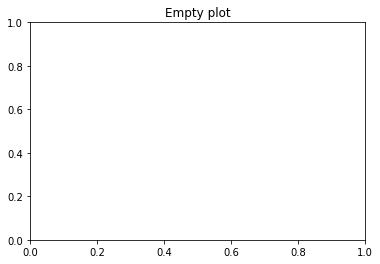

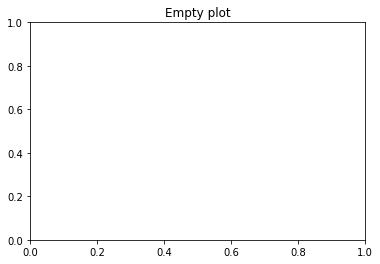

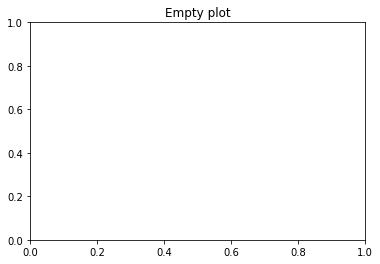

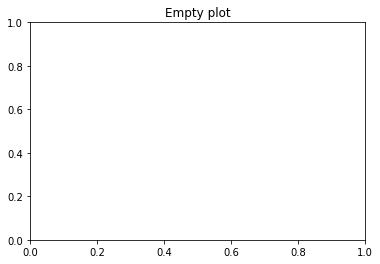

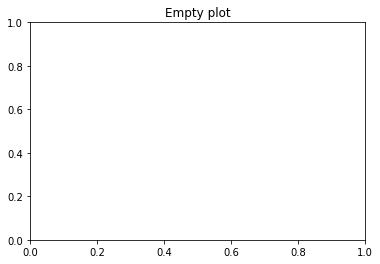

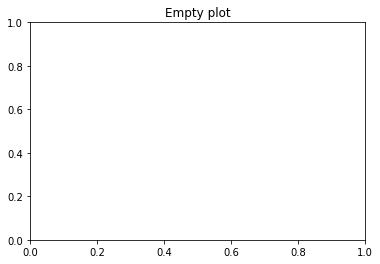

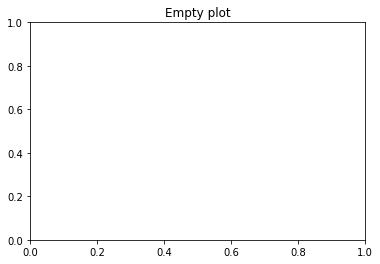

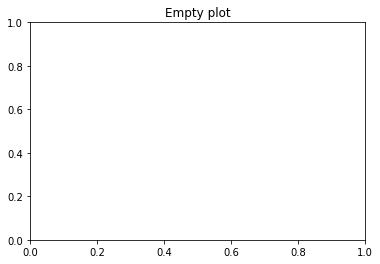

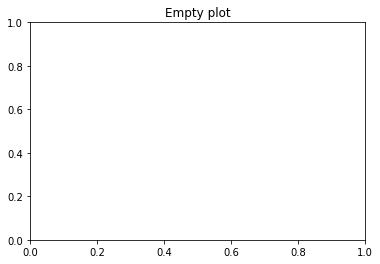

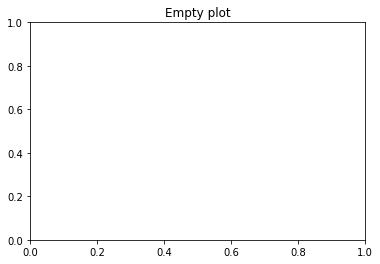

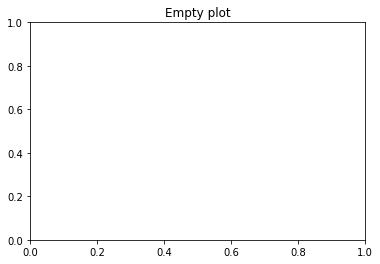

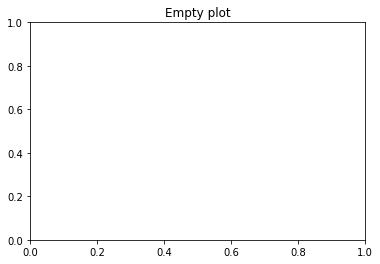

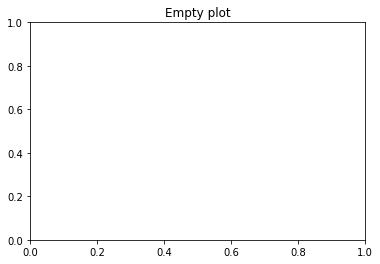

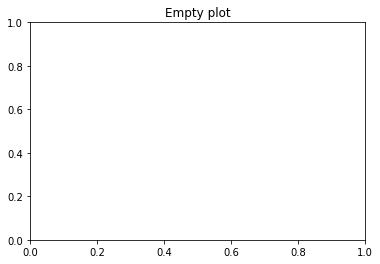

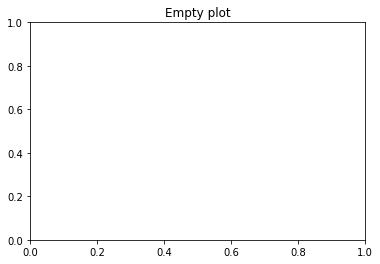

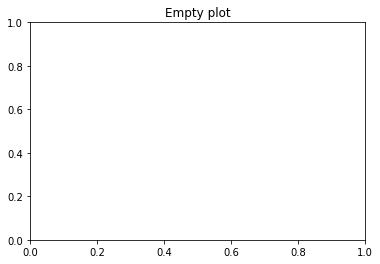

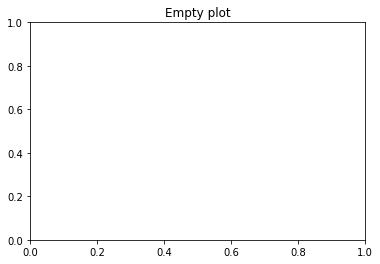

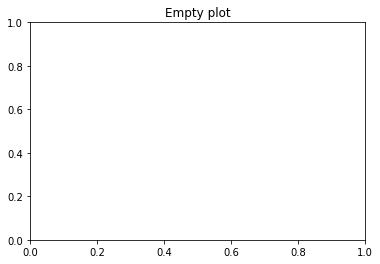

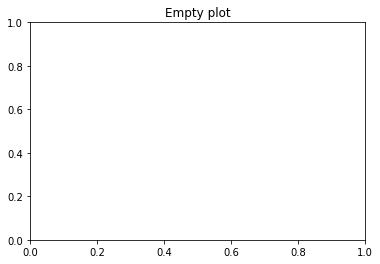

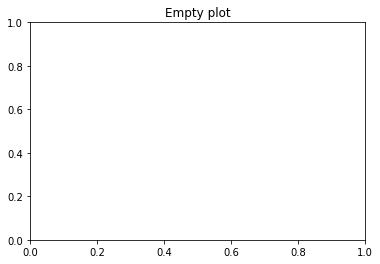

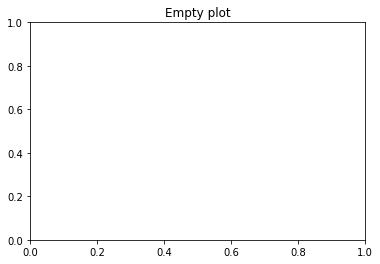

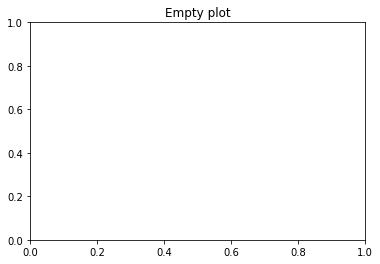

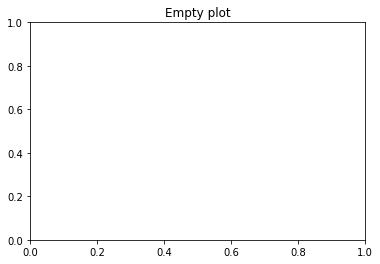

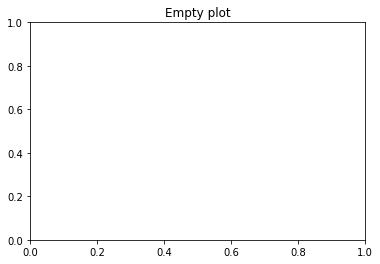

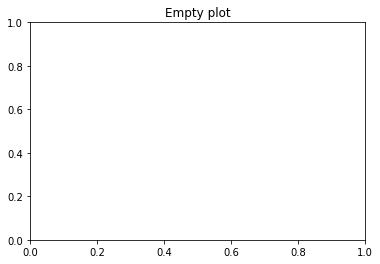

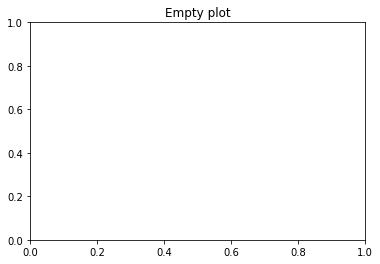

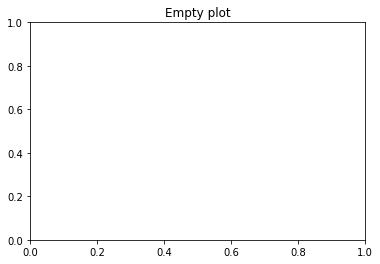

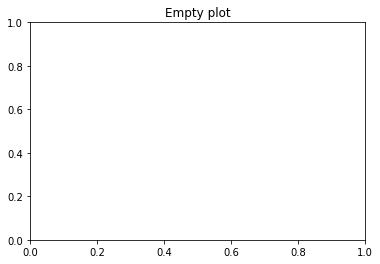

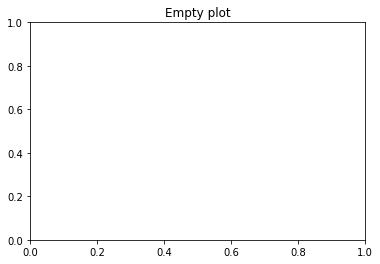

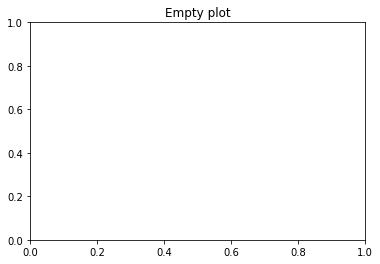

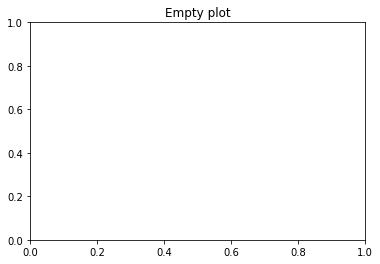

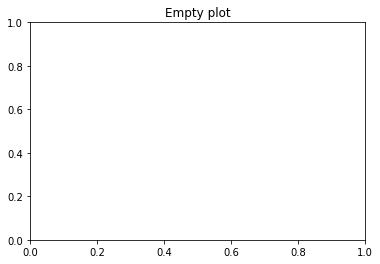

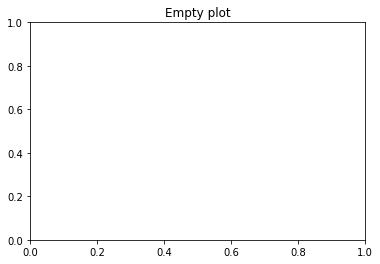

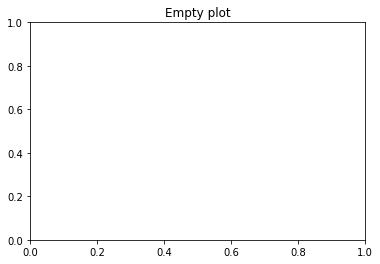

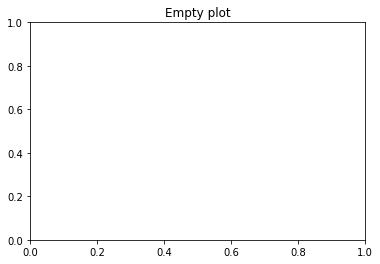

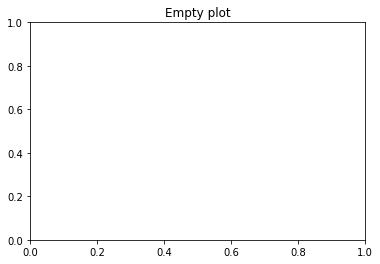

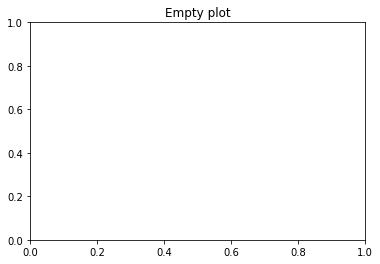

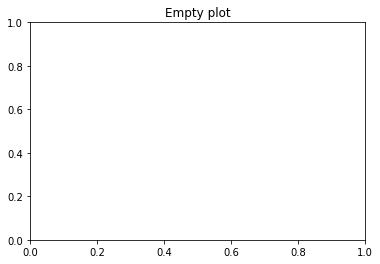

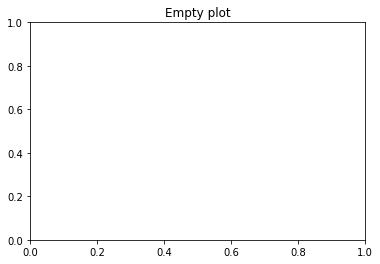

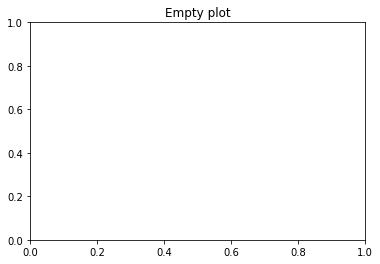

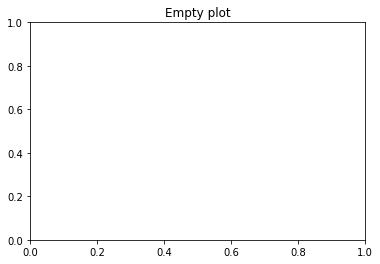

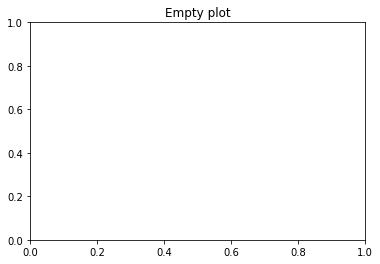

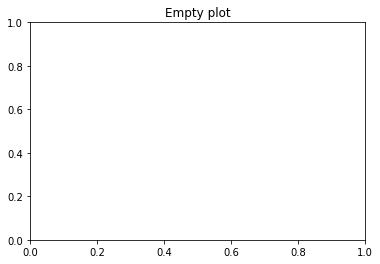

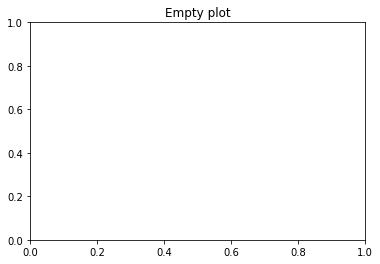

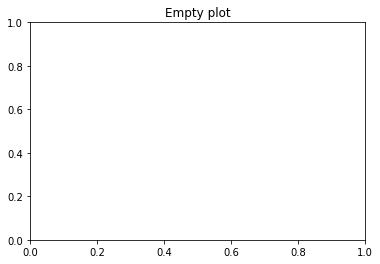

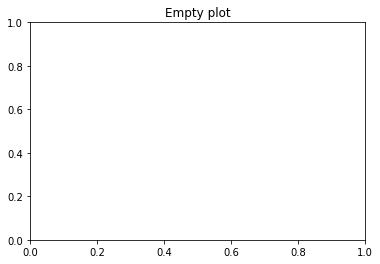

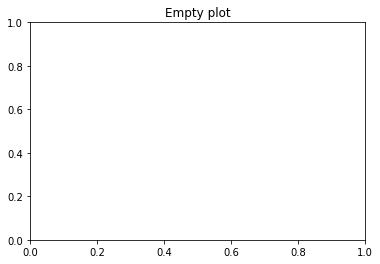

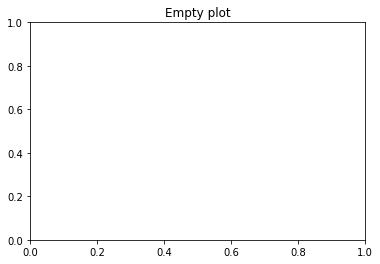

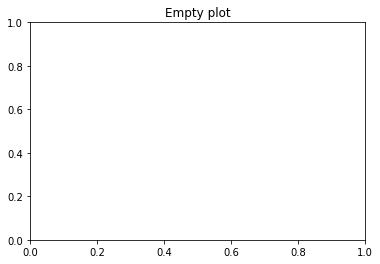

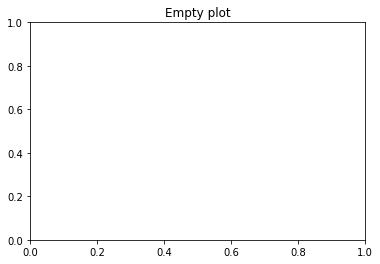

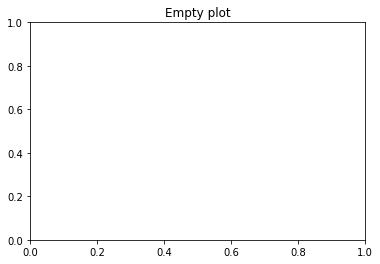

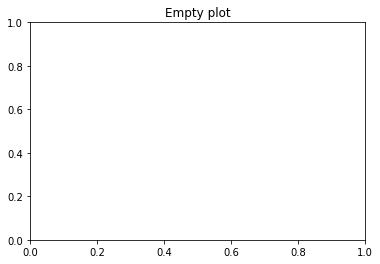

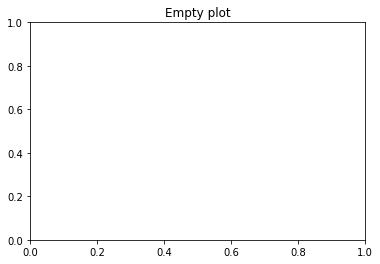

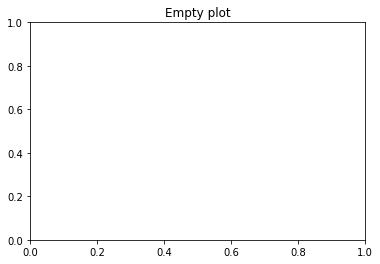

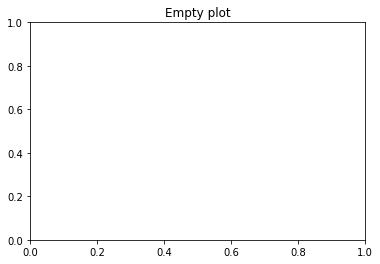

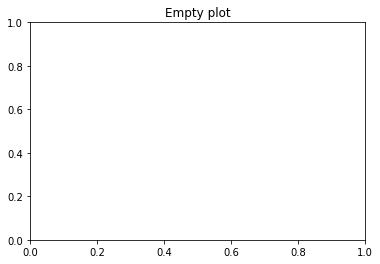

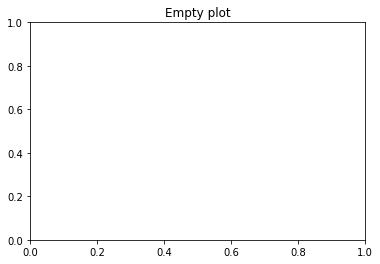

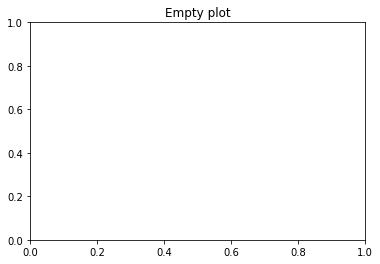

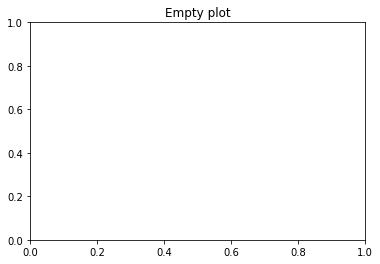

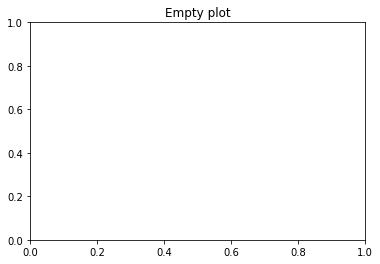

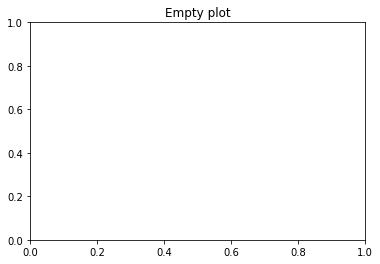

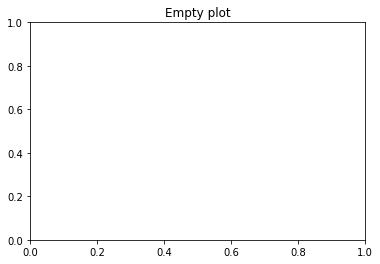

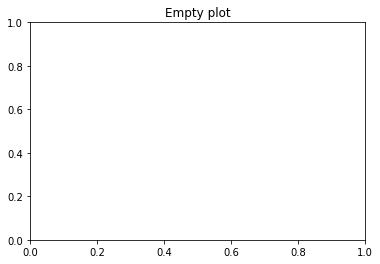

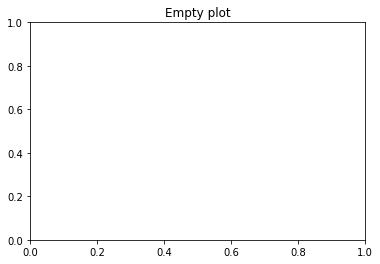

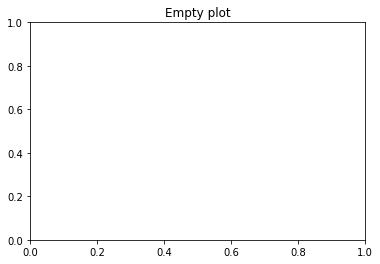

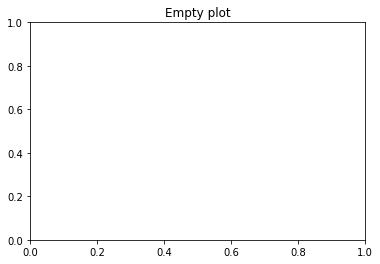

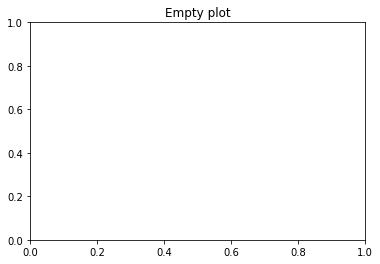

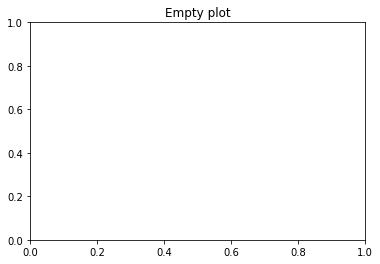

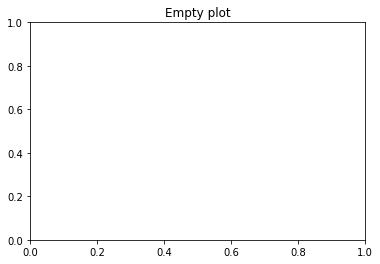

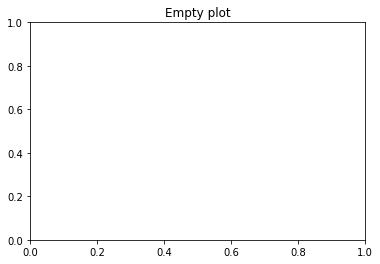

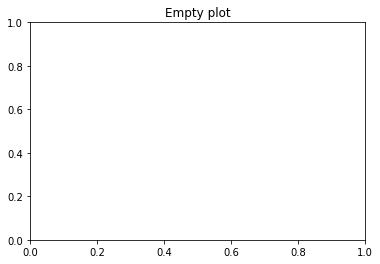

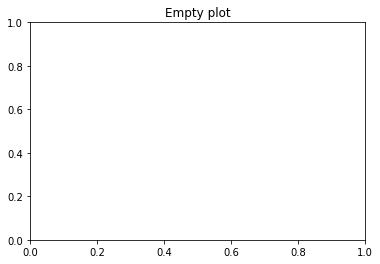

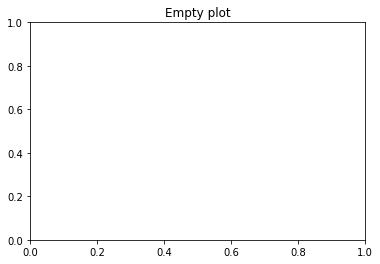

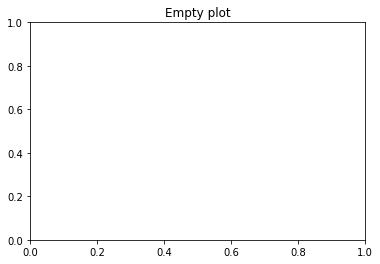

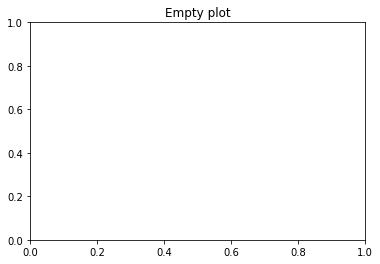

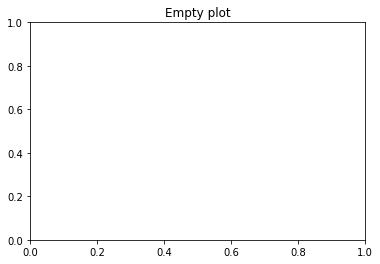

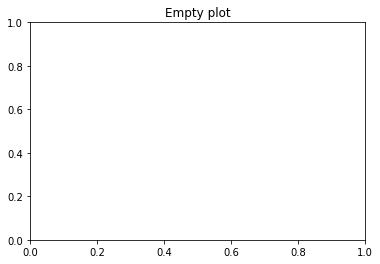

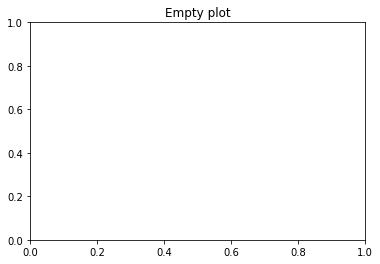

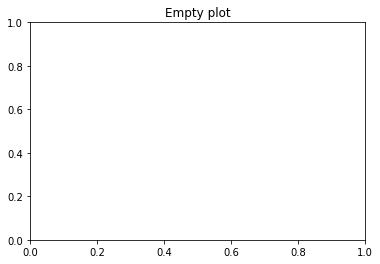

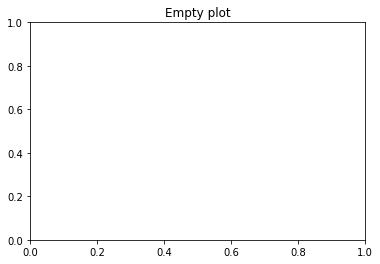

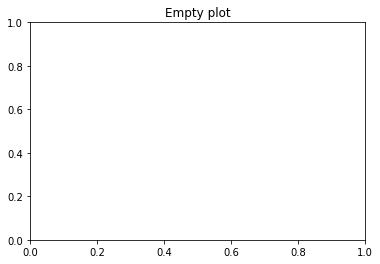

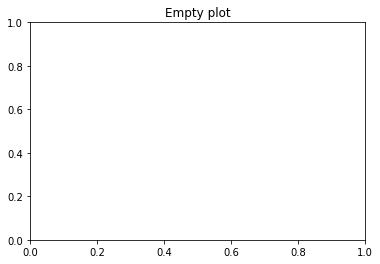

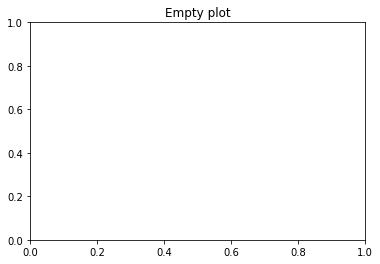

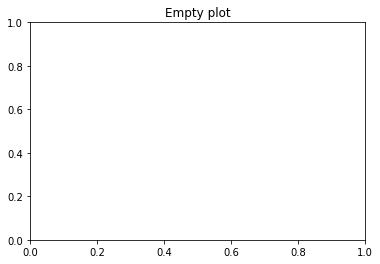

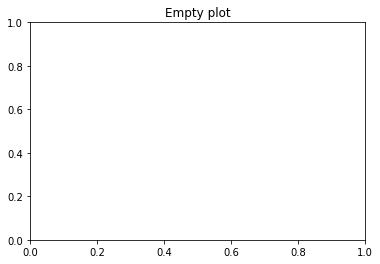

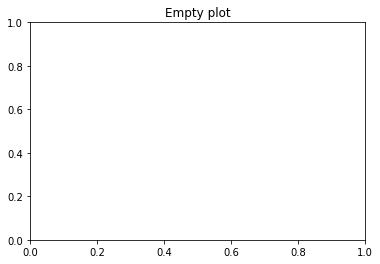

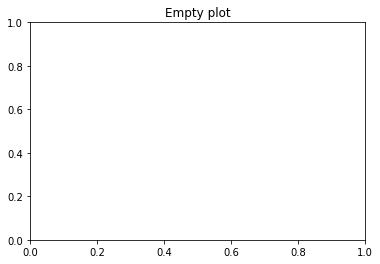

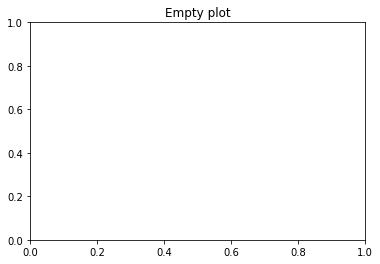

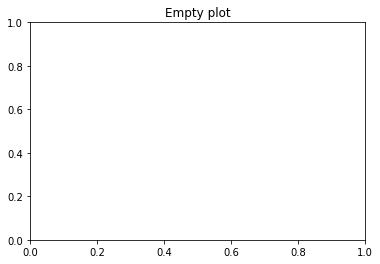

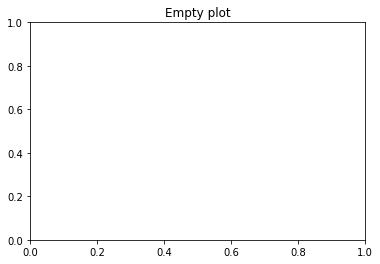

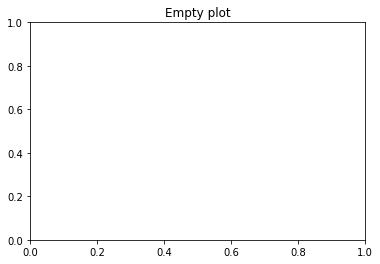

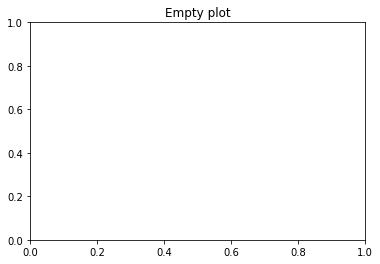

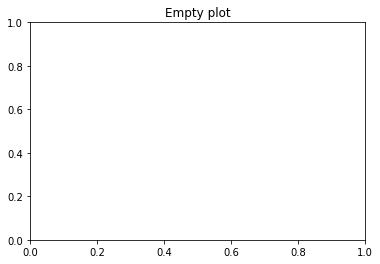

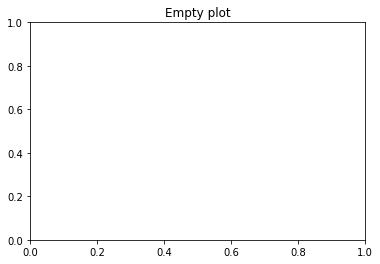

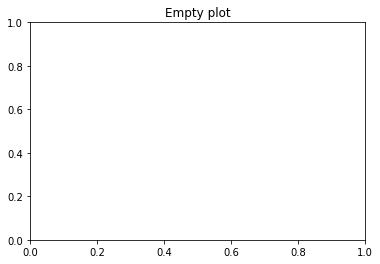

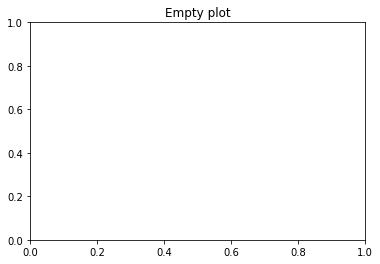

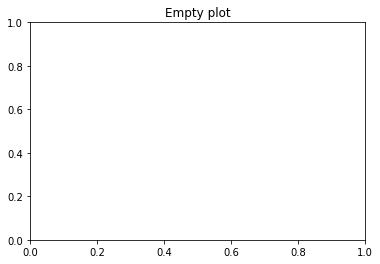

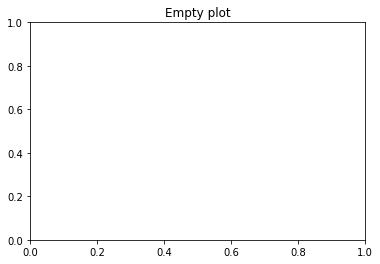

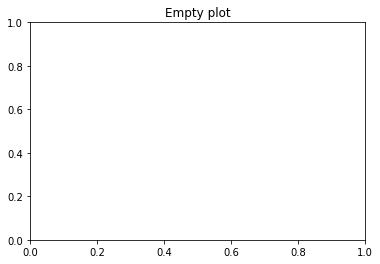

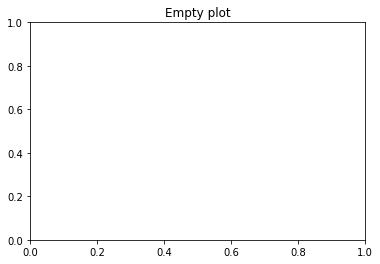

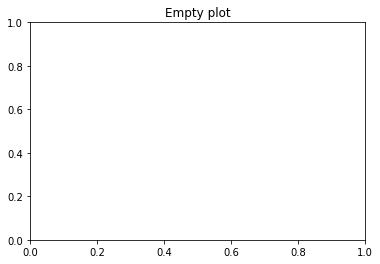

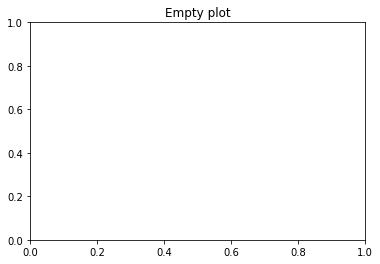

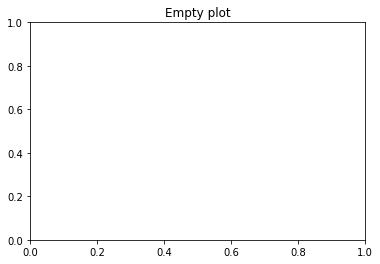

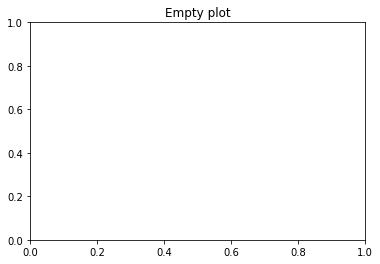

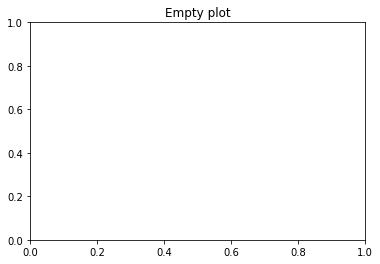

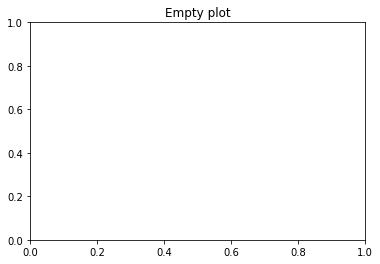

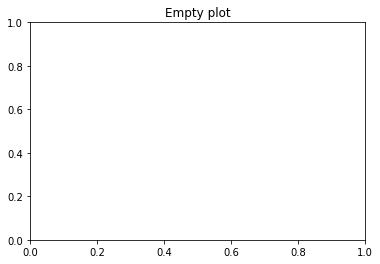

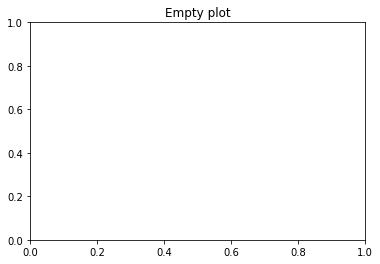

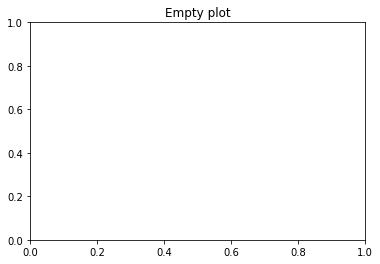

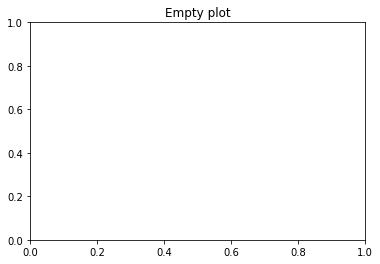

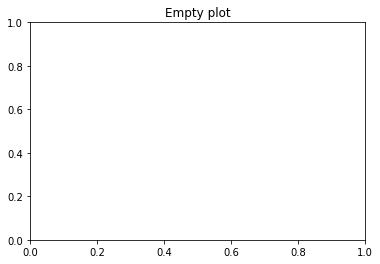

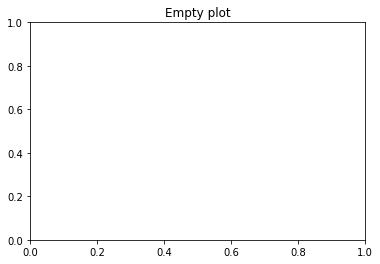

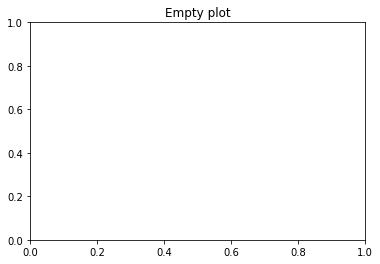

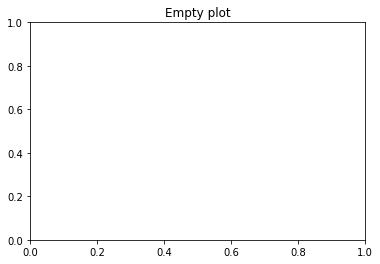

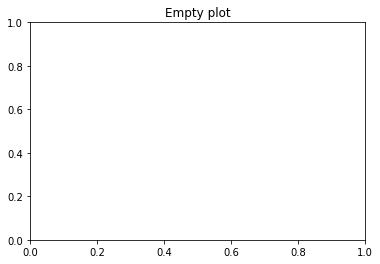

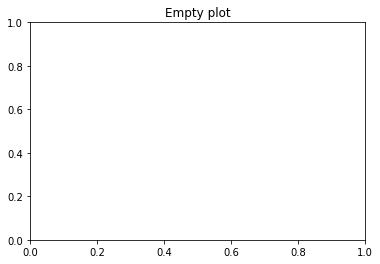

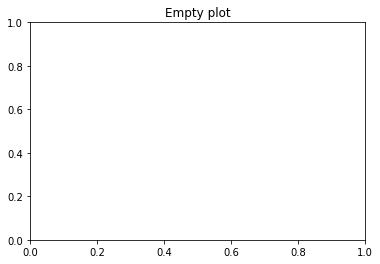

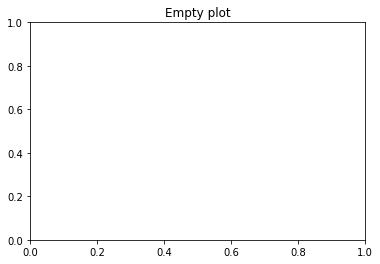

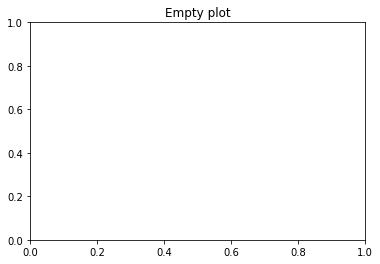

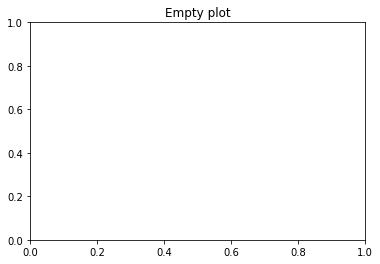

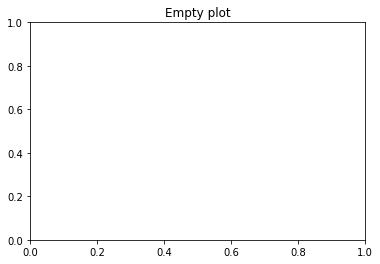

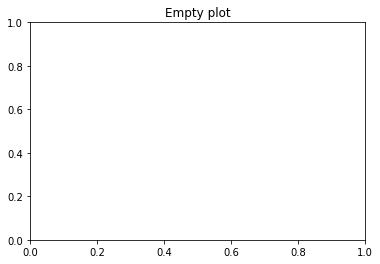

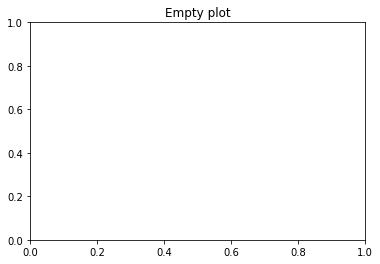

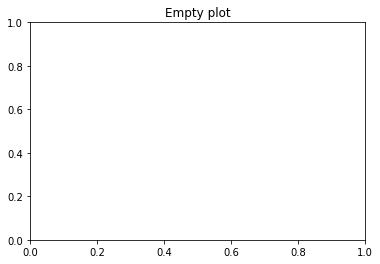

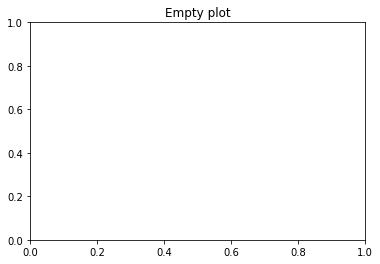

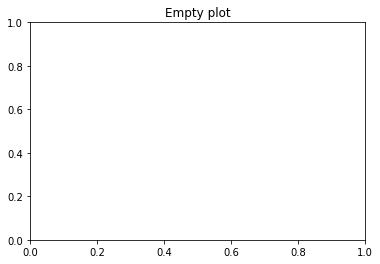

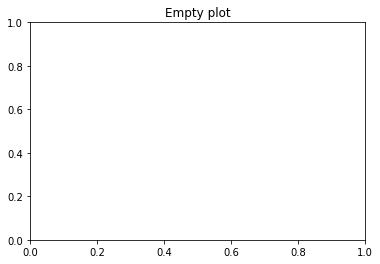

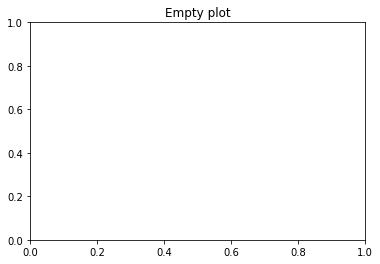

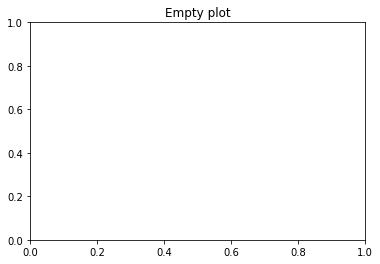

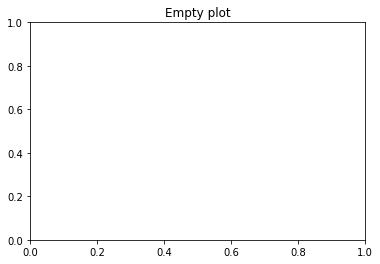

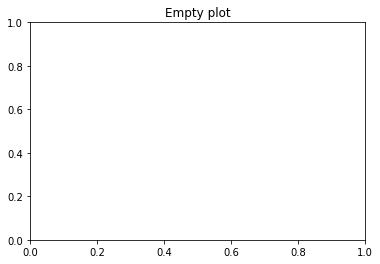

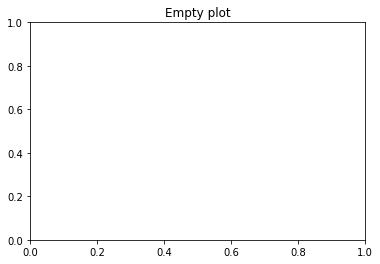

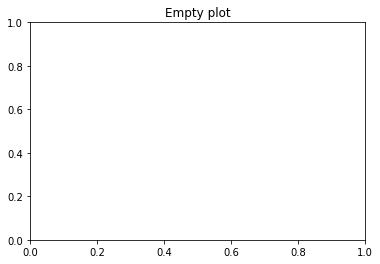

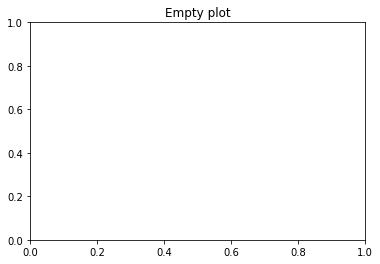

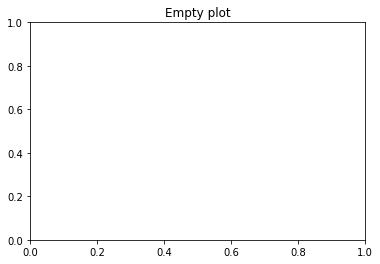

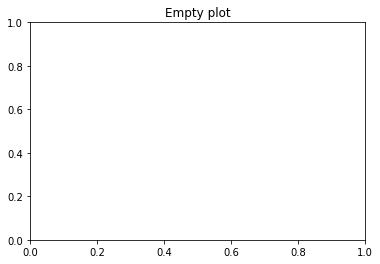

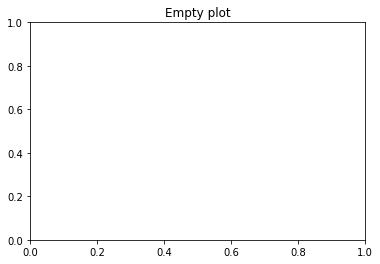

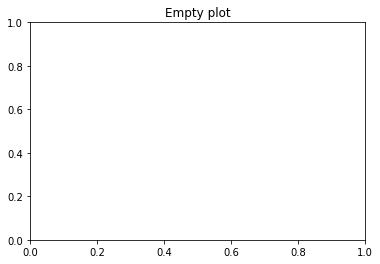

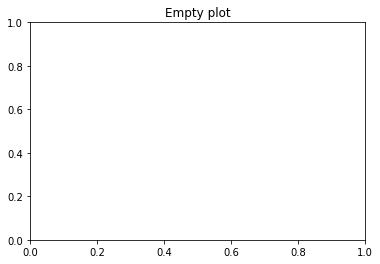

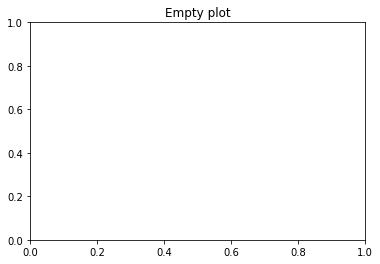

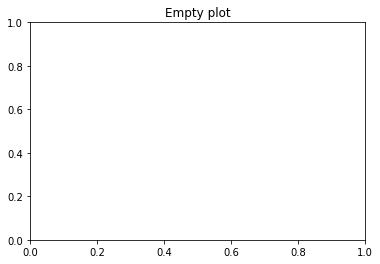

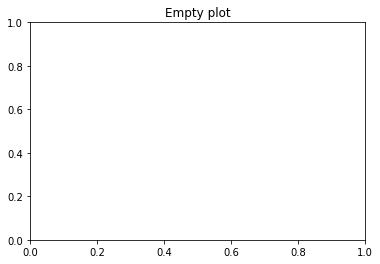

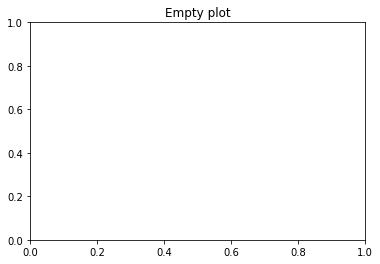

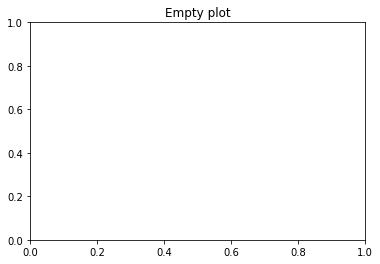

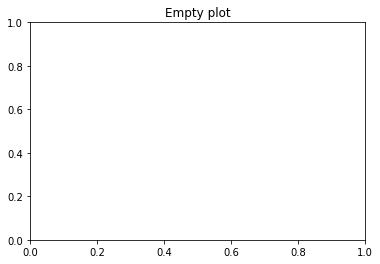

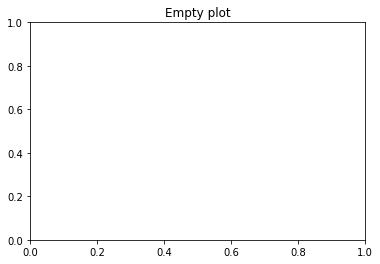

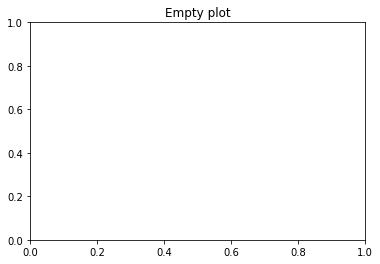

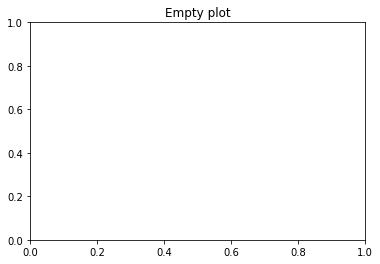

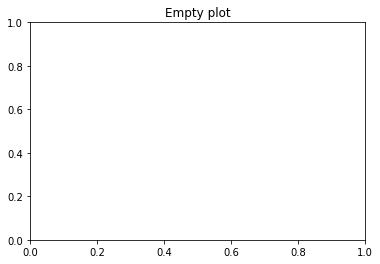

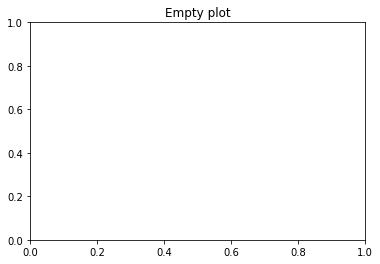

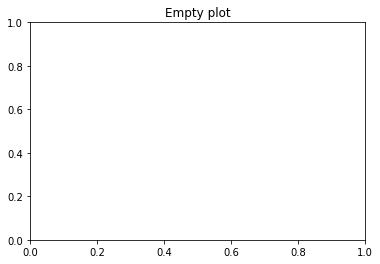

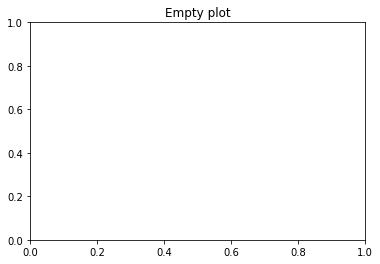

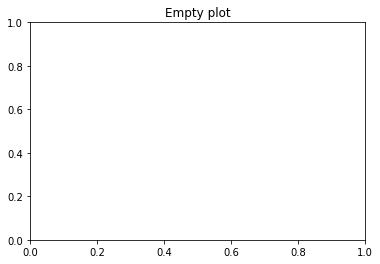

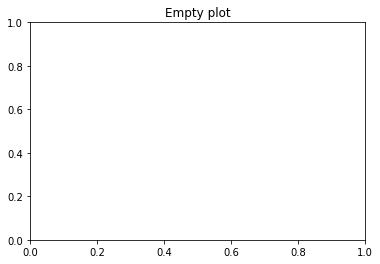

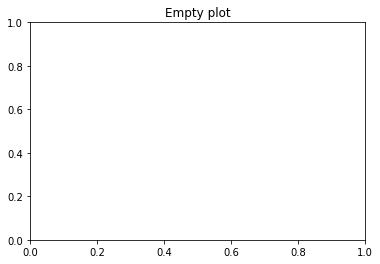

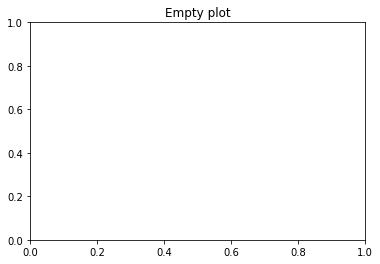

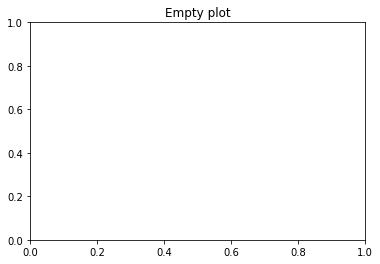

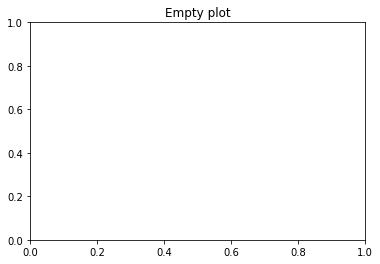

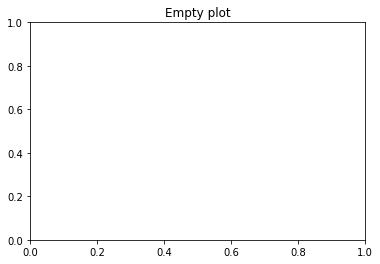

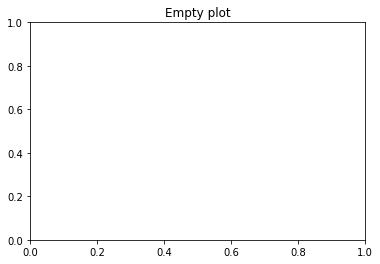

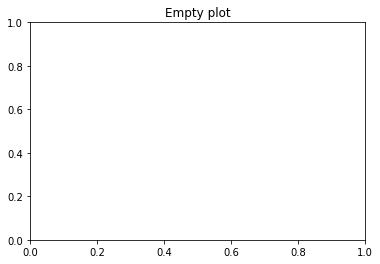

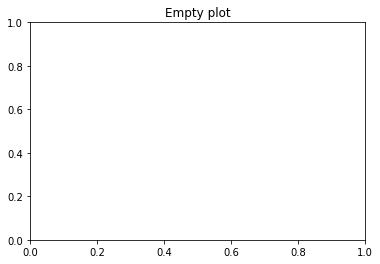

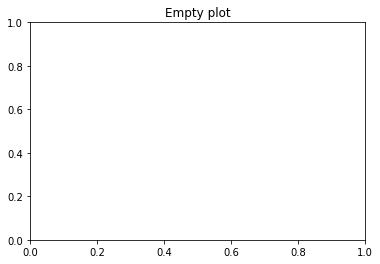

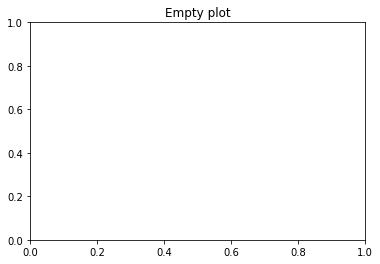

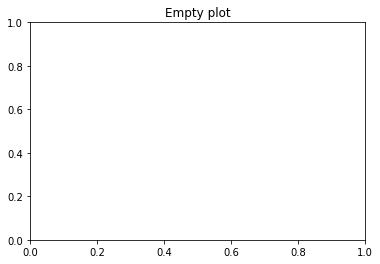

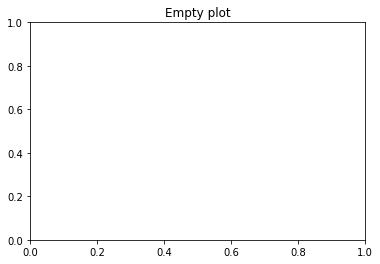

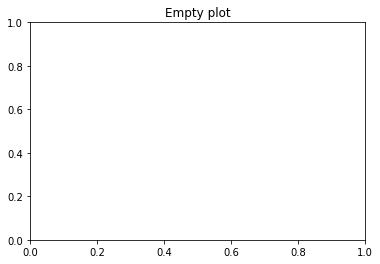

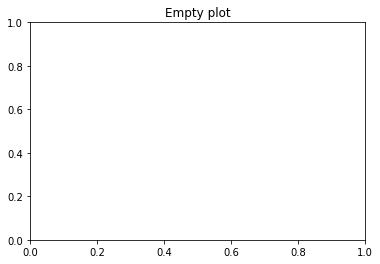

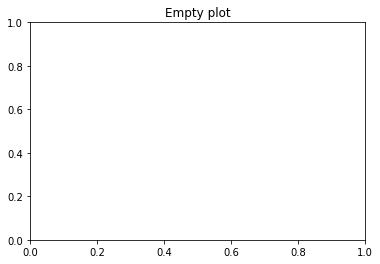

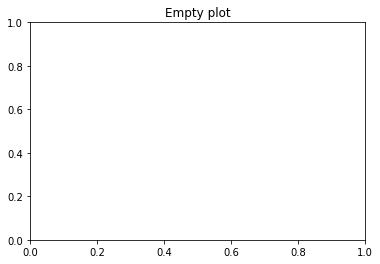

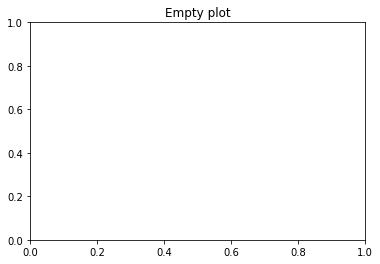

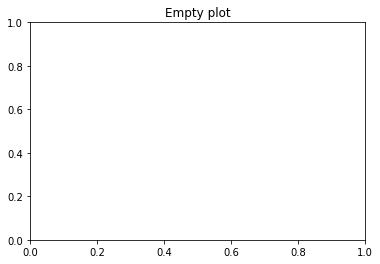

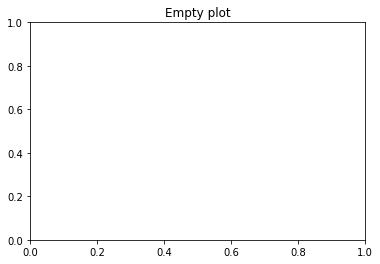

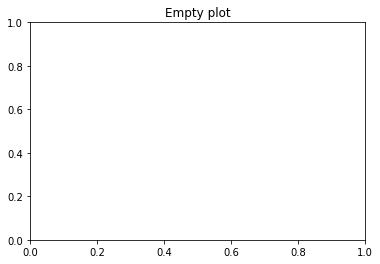

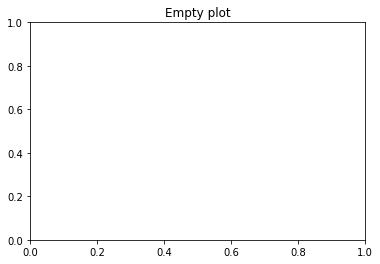

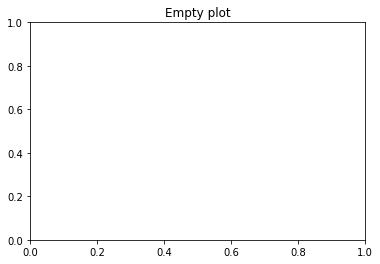

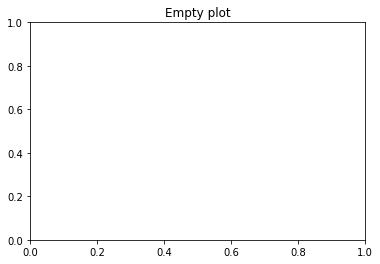

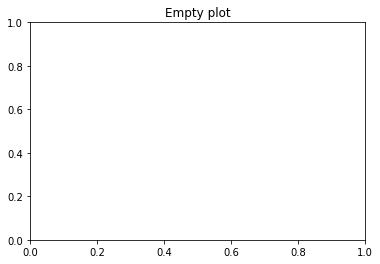

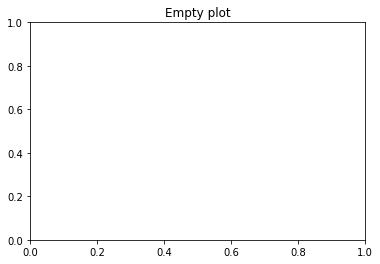

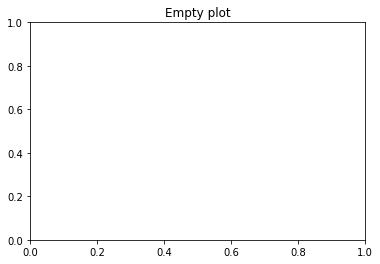

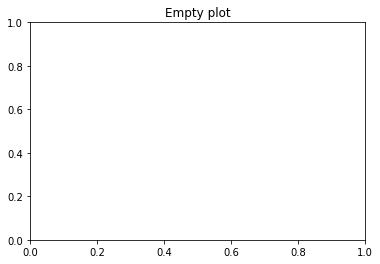

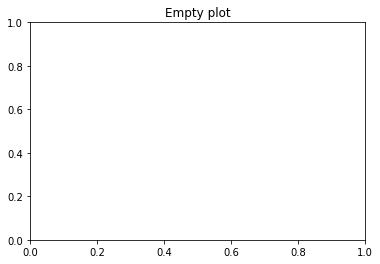

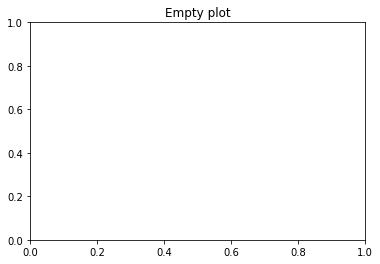

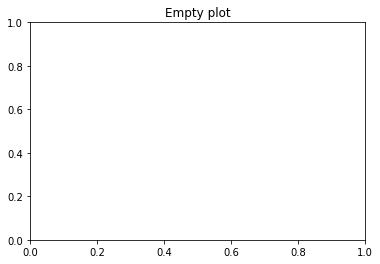

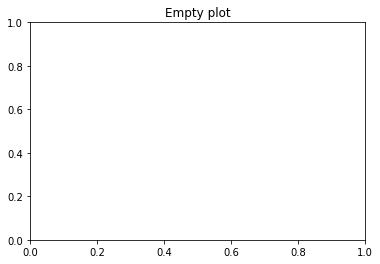

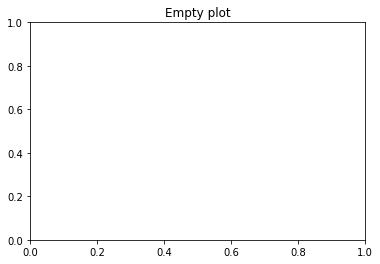

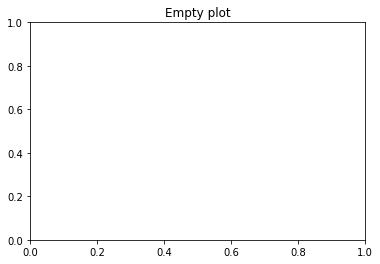

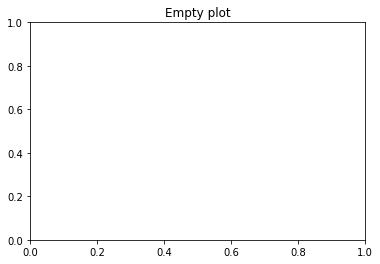

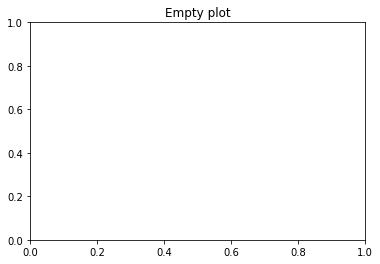

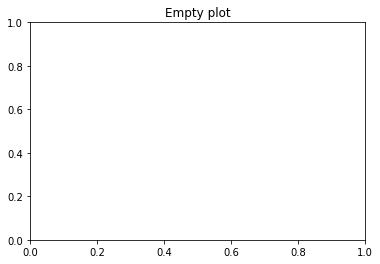

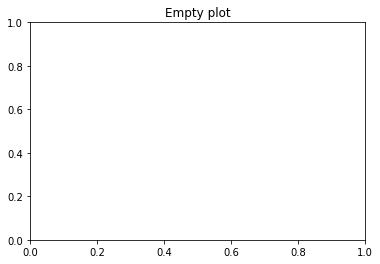

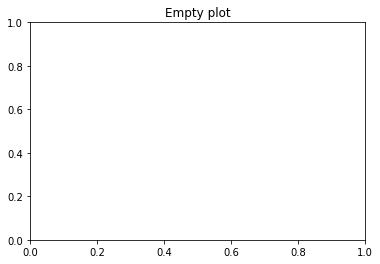

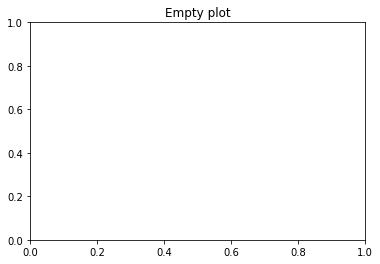

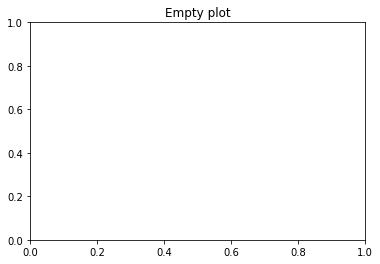

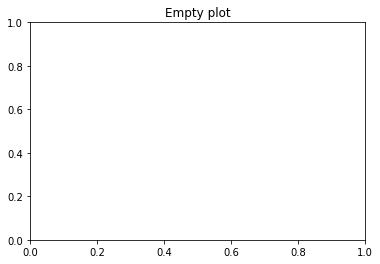

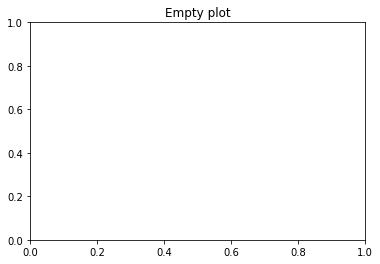

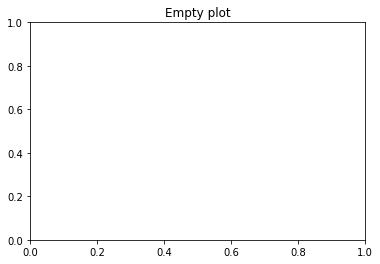

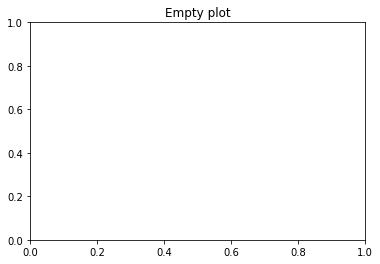

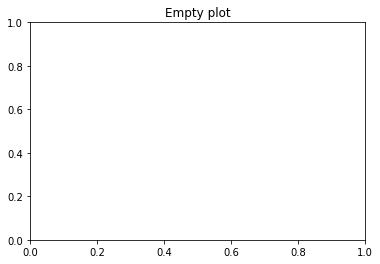

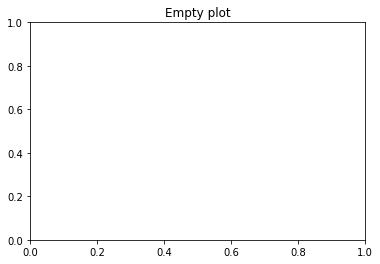

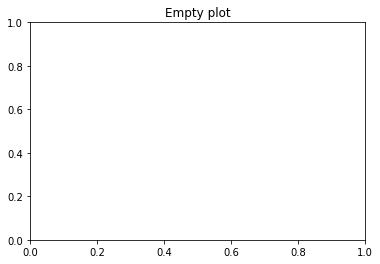

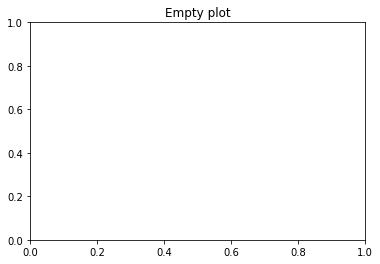

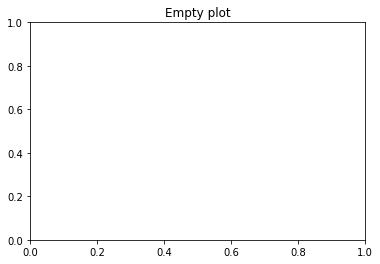

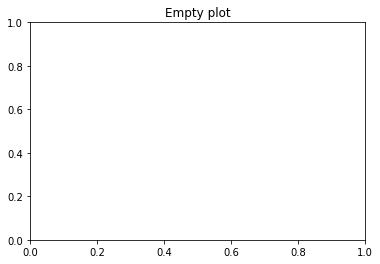

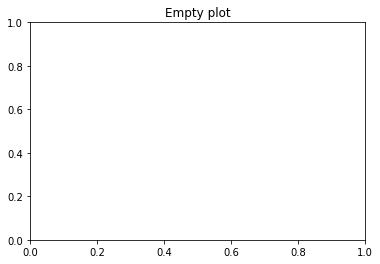

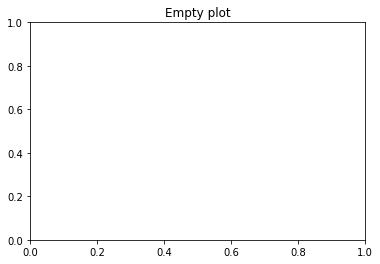

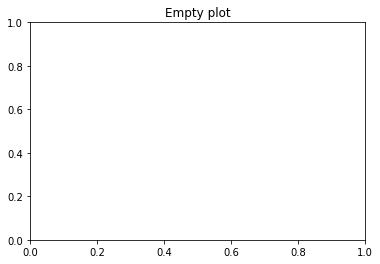

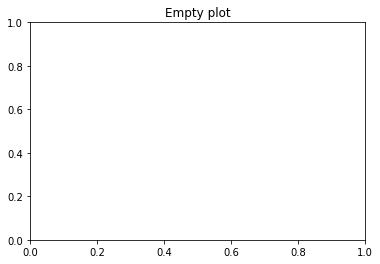

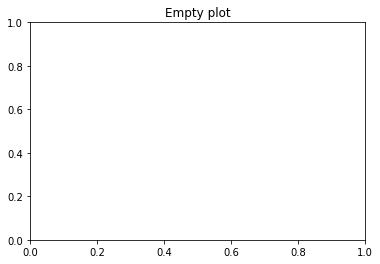

Error in callback <function flush_figures at 0x123dc7240> (for post_execute):


KeyboardInterrupt: 

In [26]:
os.chdir("/Users/dwong/Desktop/n-tuples/5_80_training/")
files = os.listdir("/Users/dwong/Desktop/n-tuples/5_80_training/")
for file_name in files:
    os.chdir("/Users/dwong/Desktop/n-tuples/5_80_training/")
    if file_name.endswith(".root")& (file_name not in train):
        each_file(file_name)

In [23]:
train = ['pi-_520_p580.root',
'photon_520_p580.root',
'muon_520_p580.root',
'positron_520_p580.root',
'pi+_520_p580.root',
'electron_520_p580.root']

In [10]:
os.chdir("/Users/wongdowling/Desktop/n-tuples/Amm_500-600/")
files = os.listdir("/Users/wongdowling/Desktop/n-tuples/Amm_500-600/")
for file_name in files:
    if file_name.endswith(".root")& (file_name not in muon_list):
        os.chdir("/Users/wongdowling/Desktop/n-tuples/Amm_500-600/")
        each_file(file_name)


AmmBrem_1.750000_z500_800_eps_-7.8_withbkg.root
AmmBrem_1.150000_z500_800_eps_-7.2_withbkg.root
AmmBrem_2.150000_z500_800_eps_-3.9_withbkg.root
AmmBrem_1.850000_z500_800_eps_-5.4_withbkg.root
AmmBrem_1.950000_z500_800_eps_-8.1_withbkg.root
AmmBrem_1.150000_z500_800_eps_-7.5_withbkg.root
AmmBrem_2.450000_z500_800_eps_-6.9_withbkg.root
AmmBrem_2.750000_z500_800_eps_-4.5_withbkg.root
AmmBrem_0.950000_z500_800_eps_-8.1_withbkg.root
AmmBrem_0.850000_z500_800_eps_-5.4_withbkg.root
AmmBrem_1.150000_z500_800_eps_-6_withbkg.root
AmmBrem_2.750000_z500_800_eps_-4.2_withbkg.root
AmmBrem_0.450000_z500_800_eps_-6_withbkg.root
AmmBrem_0.450000_z500_800_eps_-6.9_withbkg.root
AmmBrem_1.750000_z500_800_eps_-4.2_withbkg.root
AmmBrem_2.650000_z500_800_eps_-9_withbkg.root
AmmBrem_2.550000_z500_800_eps_-3_withbkg.root
AmmBrem_3.050000_z500_800_eps_-3_withbkg.root
AmmBrem_1.750000_z500_800_eps_-4.5_withbkg.root
AmmBrem_2.150000_z500_800_eps_-7.5_withbkg.root
AmmBrem_1.450000_z500_800_eps_-6.9_withbkg.root
Am

In [9]:
len(muon_list)

534